# Exploratory Visualization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats as sps
import sklearn

from google.cloud import bigquery as bq

In [4]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [5]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [27]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/paperspace/gcloud_service_account_key.json'

In [28]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Data in BigQuery has been pre-processed with Dataprep.

In [29]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned`
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
    else:
      # Validation
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
  else:
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(1, None)

In [31]:
client = bq.Client()
df_all = client.query(query).to_dataframe()

In [33]:
# Remove age outliers
age = df_all['age']
age_25 = df_all['age'].quantile(.25)
age_75 = df_all['age'].quantile(.75)
age_iqr = age_75 - age_25
age_max = age_75 + (1.5 * age_iqr)
age_min = age_25 - (1.5 * age_iqr)
age_min, age_max

df_all = df_all[(df_all['age'] <= age_max) & (df_all['age'] >= age_min)]

df_all.head()
df_all.describe()

age  concentration  hearing_impairments  musical_expertise  \
count  292.000000     188.000000           292.000000         203.000000   
mean    23.130137       3.984043             0.061644           2.566502   
std     10.852820       1.005206             0.240920           1.226466   
min      1.000000       1.000000             0.000000           1.000000   
25%     16.000000       3.000000             0.000000           2.000000   
50%     21.000000       4.000000             0.000000           3.000000   
75%     30.000000       5.000000             0.000000           3.000000   
max     51.000000       5.000000             1.000000           5.000000   

         artistic       fault  imagination        lazy     nervous  \
count  188.000000  187.000000   187.000000  188.000000  187.000000   
mean     2.345745    3.197861     3.855615    3.696809    3.647059   
std      1.254993    1.130418     1.039804    1.146299    1.113712   
min      1.000000    1.000000     1.000000    1.000000    1.000000   
25%      1.000000    2.000000     3.000000    3.000000    3.000000   
50%      2.000000    3.000000     4.000000    4.000000    4.000000   
75%      3.000000    4.000000     5.000000    4.250000    4.000000   
max      5.000000    5.000000     5.000000    5.000000    5.000000   

         outgoing              ...               music_pref_none  \
count  187.000000              ...                    292.000000   
mean     3.213904              ...                      0.006849   
std      1.216915              ...                      0.082618   
min      1.000000              ...                      0.000000   
25%      2.000000              ...                      0.000000   
50%      3.000000              ...                      0.000000   
75%      4.000000              ...                      0.000000   
max      5.000000              ...                      1.000000   

       music_pref_hiphop  music_pref_dance  music_pref_world  music_pref_rock  \
count         292.000000        292.000000        292.000000       292.000000   
mean            0.143836          0.191781          0.133562         0.431507   
std             0.351525          0.394377          0.340765         0.496137   
min             0.000000          0.000000          0.000000         0.000000   
25%             0.000000          0.000000          0.000000         0.000000   
50%             0.000000          0.000000          0.000000         0.000000   
75%             0.000000          0.000000          0.000000         1.000000   
max             1.000000          1.000000          1.000000         1.000000   

       music_pref_pop  music_pref_classical  music_pref_jazz  music_pref_folk  \
count      292.000000            292.000000       292.000000       292.000000   
mean         0.684932              0.291096         0.167808         0.085616   
std          0.465341              0.455047         0.374337         0.280277   
min          0.000000              0.000000         0.000000         0.000000   
25%          0.000000              0.000000         0.000000         0.000000   
50%          1.000000              0.000000         0.000000         0.000000   
75%          1.000000              1.000000         0.000000         0.000000   
max          1.000000              1.000000         1.000000         1.000000   

       music_pref_traditional_irish  
count                    292.000000  
mean                       0.044521  
std                        0.206603  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000  

[8 rows x 30 columns]

In [34]:
df_reaction = df_all[df_all['hallelujah_reaction'] == True]
df_no_reaction = df_all[df_all['hallelujah_reaction'] == False]

In [35]:
df_all.columns

Index(['id', 'age', 'concentration', 'hearing_impairments',
       'musical_expertise', 'nationality', 'artistic', 'fault', 'imagination',
       'lazy', 'nervous', 'outgoing', 'reserved', 'stress', 'thorough',
       'trusting', 'activity', 'engagement', 'familiarity', 'like_dislike',
       'positivity', 'tension', 'sex', 'hallelujah_reaction', 'location',
       'language', 'music_pref_none', 'music_pref_hiphop', 'music_pref_dance',
       'music_pref_world', 'music_pref_rock', 'music_pref_pop',
       'music_pref_classical', 'music_pref_jazz', 'music_pref_folk',
       'music_pref_traditional_irish'],
      dtype='object')

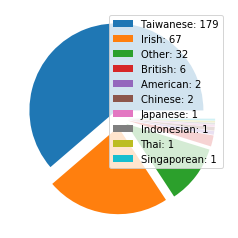

In [36]:
nationality_counts = df_all['nationality'].value_counts()
patches, texts = plt.pie(nationality_counts, 
                                    explode=[0.1] * len(nationality_counts));

labels = ['{}: {}'.format(x.capitalize(), nationality_counts[x]) for x in nationality_counts.index]

plt.legend(patches, labels)
plt.savefig('hallelujah_reaction_pie_nationalities.pdf')

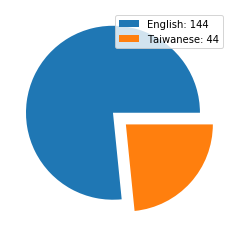

In [37]:
language_counts = df_all['language'].value_counts()
patches, texts = plt.pie(language_counts, 
                                    explode=[0.1] * len(language_counts));

languages = list(language_counts.index)
for i in range(len(languages)):
    language = languages[i]
    if language == 'en':
        languages[i] = 'English'
    elif language == 'zh_TW':
        languages[i] = 'Taiwanese'

labels = ['{}: {}'.format(languages[i].capitalize(), language_counts[x]) for i, x in enumerate(language_counts.index)]

plt.legend(patches, labels)
plt.savefig('hallelujah_reaction_pie_languages.pdf')

In [41]:
def mardia(data, unbiased_cov=True):
    """
    data should have observations in rows
    """
    import numpy as np
    import scipy.stats as sps
    
    n = data.shape[0]
    p = data.shape[1]

    S = None
    if unbiased_cov:
        S = ((n - 1.) / n) * np.cov(data, rowvar=False)
    else:
        S = np.cov(data, rowvar=False)

    data_scaled = (data - data.mean(axis=0))

    D = np.matmul(np.matmul(data_scaled, np.linalg.pinv(S, rcond=1e-25)), data_scaled.T)

    product = D * D * D
    skewness = np.sum(product) / n**2
    kurtosis = (D * D).diagonal().sum() / n
    df = p * (p + 1) * (p + 2) / 6
    k = ((p + 1)*(n + 1)*(n + 3))/(n*((n + 1)*(p + 1) - 6))
    
    skew, kurt, skew_p, kurt_p = None, None, None, None
    if n < 20:
        skew = n * k * skewness / 6.
    else:
        skew = n * skewness / 6.
    
    chi2_test_skew = sps.chi2(df)
    skew_p = 1. - chi2_test_skew.cdf(skew)
    
    skew_result = False
    if skew_p > 0.05:
        skew_result = True
    
    kurt = (kurtosis - p * (p + 2)) * np.sqrt(n / (8 * p * (p + 2)))
    
    normal_test_kurt = sps.norm()
    kurt_p = 2. * (1. - normal_test_kurt.cdf(np.abs(kurt)))
    
    kurt_result = False
    if kurt_p  > 0.05:
        kurt_result = True
    
    result_skewness = {
        'test': 'Mardia Skewness',
        'statistic': skew,
        'p-value': skew_p,
        'result': skew_result
    }
    
    result_kurtosis = {
        'test': 'Mardia Kurtosis',
        'statistic': kurt,
        'p-value': kurt_p,
        'result': kurt_result
    }
    
    result = {
        'test': 'MVN',
        'statistic': None,
        'p-value': None,
        'result': skew_result and kurt_result
    }
    
    return result_skewness, result_kurtosis, result

In [46]:
def run_tests(x_label, dist_var, bins=None, normed=False, kde=True, bw='normal_reference', x_lim=None, plots=False, print_output=False):
    
    if plots:
        f = plt.figure(figsize=(8, 4))
        sns.distplot(df_all[dist_var].dropna(), bins=bins, norm_hist=normed, kde=kde, rug=True, kde_kws={'bw': bw})
        plt.xlabel('')
        if x_lim is not None:
            plt.xlim([0.5, 5.5])

        g = sns.FacetGrid(df_all, hue='hallelujah_reaction', height=4, aspect=2)
        g.map(sns.distplot, dist_var, bins=bins, norm_hist=normed, kde=kde, kde_kws={'bw': bw})
        g.set_xlabels(x_label)
        if x_lim is not None:
            g.axes[0,0].set_xlim([0.5, 5.5])
        g.fig.suptitle('Distribution of {} by reaction group'.format(dist_var), y=1.0)
        g.add_legend(title='Hallelujah Reaction');

        fig_file = 'hallelujah_reaction_distribution_all_stimuli_{}.pdf'.format(dist_var)
        g.savefig(fig_file, orientation='landscape')
        
    mean_true = df_all[df_all['hallelujah_reaction'] == True][dist_var].dropna()
    mean_false = df_all[df_all['hallelujah_reaction'] == False][dist_var].dropna()
    
    all_normtest = sps.normaltest(df_all[dist_var])
    true_normtest = sps.normaltest(df_all[df_all['hallelujah_reaction'] == True][dist_var])
    false_normtest = sps.normaltest(df_all[df_all['hallelujah_reaction'] == False][dist_var])
    if print_output:
        print(f'All normal test results: {all_normtest}')
        print(f'Reaction normal test results: {true_normtest}')
        print(f'No-reaction normal test results: {false_normtest}')
    
    alpha = 0.05
    _, equal_variance_p = sps.levene(mean_true, mean_false)
    
    equal_var = None
    if equal_variance_p >= alpha:
        equal_var = True
    else:
        equal_var = False
    
    t_stat, t_p = sps.ttest_ind(mean_true, mean_false, equal_var=equal_var)
    u_stat, u_p = sps.mannwhitneyu(mean_true, mean_false, alternative='two-sided')

    if print_output:
        print('Student\'s t-test for difference in mean {} between Hallelujah Reaction groups'.format(x_label.capitalize()))

        print('T test statistic: {:.4f}'.format(t_stat))
        print('T test p-value: {:.4f}'.format(t_p))

        print('Mann-Whitney U test statistic: {:.4f}'.format(u_stat))
        print('Mann-Whitney U test p-value: {:.4f}'.format(u_p))

        if t_p <= alpha or u_p <= alpha:
            print('**** Significant Result ****')
    
    return {
        'mean_true': mean_true.mean(),
        'mean_false': mean_false.mean(),
        'median_true': mean_true.median(),
        'median_false': mean_false.median(),
        't_stat': t_stat,
        't_p': t_p,
        'u_stat': u_stat,
        'u_p': u_p
    }

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


All normal test results: NormaltestResult(statistic=17.671619743094364, pvalue=0.0001454308457109903)
Reaction normal test results: NormaltestResult(statistic=8.799630014804267, pvalue=0.012279611330164125)
No-reaction normal test results: NormaltestResult(statistic=13.691537931140216, pvalue=0.0010639477828134568)
Student's t-test for difference in mean Age [years] between Hallelujah Reaction groups
T test statistic: -0.7241
T test p-value: 0.4701
Mann-Whitney U test statistic: 8079.5000
Mann-Whitney U test p-value: 0.9835


{'mean_true': 22.41891891891892,
 'mean_false': 23.371559633027523,
 'median_true': 21.0,
 'median_false': 21.0,
 't_stat': -0.7241469808788683,
 't_p': 0.4700676278529339,
 'u_stat': 8079.5,
 'u_p': 0.9834558798558084}

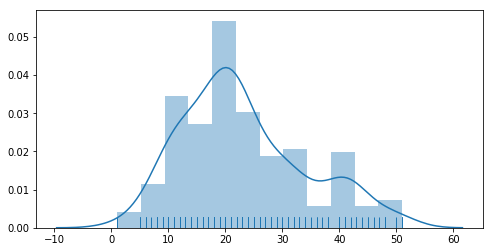

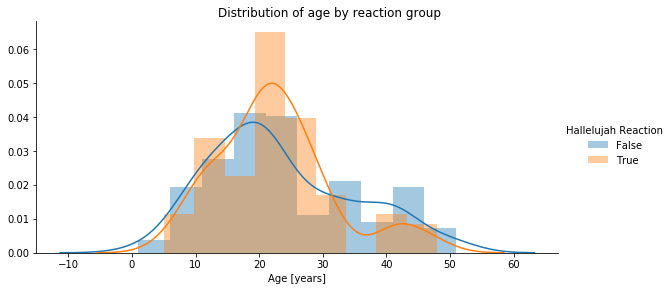

In [48]:
run_tests('Age [years]', 'age', plots=True, print_output=True)

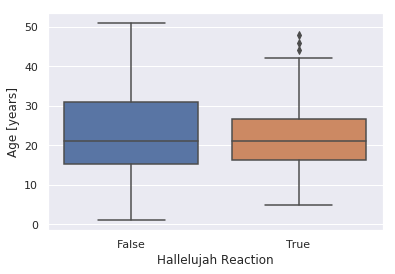

In [963]:
b = sns.boxplot(x='hallelujah_reaction', y='age', data=df_all)
b.set_xlabel('Hallelujah Reaction')
b.set_ylabel('Age [years]')
plt.savefig('hallelujah_reaction_age_box.pdf')

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Concentration between Hallelujah Reaction groups
T test statistic: -0.4970
T test p-value: 0.6198
Mann-Whitney U test statistic: 3464.0000
Mann-Whitney U test p-value: 0.5489


{'mean_true': 3.9272727272727272,
 'mean_false': 4.007518796992481,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': -0.49695918784660775,
 't_p': 0.6198047165227855,
 'u_stat': 3464.0,
 'u_p': 0.5488513299033971}

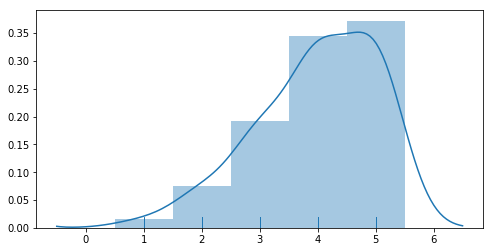

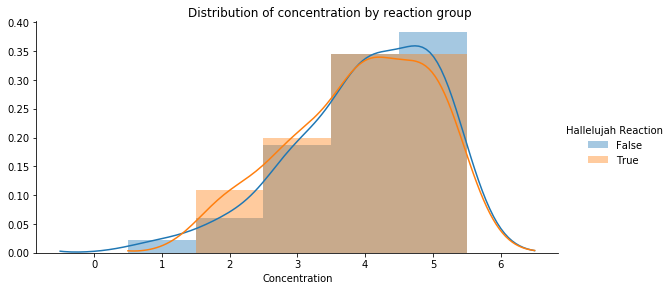

In [49]:
run_tests('Concentration', 'concentration', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

Student's t-test for difference in mean Hearing impairments between Hallelujah Reaction groups
Variances are equal
T test statistic: 0.8027
T test p-value: 0.4228
Mann-Whitney U test statistic: 8276.0000
Mann-Whitney U test p-value: 0.4229


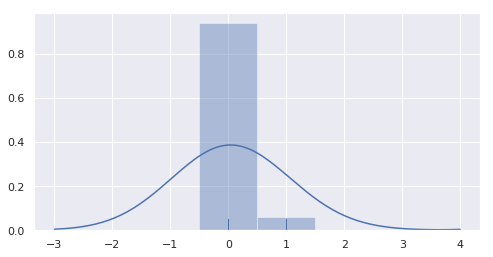

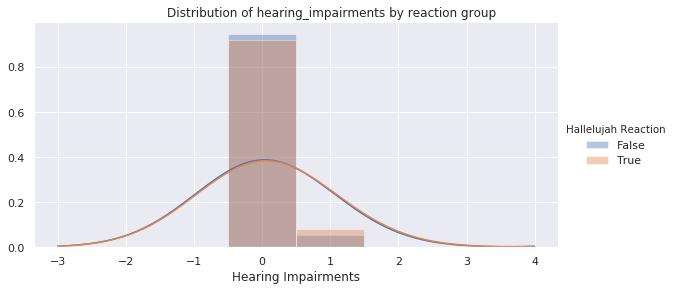

In [965]:
plot_histograms('Hearing Impairments', 'hearing_impairments', bins=[-0.5, 0.5, 1.5], normed=False, kde=True, bw=1)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Musical expertise between Hallelujah Reaction groups
T test statistic: -1.5711
T test p-value: 0.1177
Mann-Whitney U test statistic: 3501.0000
Mann-Whitney U test p-value: 0.1155


{'mean_true': 2.3454545454545452,
 'mean_false': 2.6486486486486487,
 'median_true': 2.0,
 'median_false': 3.0,
 't_stat': -1.5710939136671587,
 't_p': 0.11773365138497931,
 'u_stat': 3501.0,
 'u_p': 0.11546832089538075}

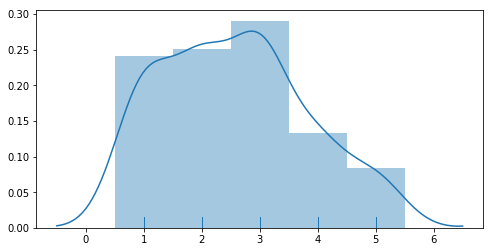

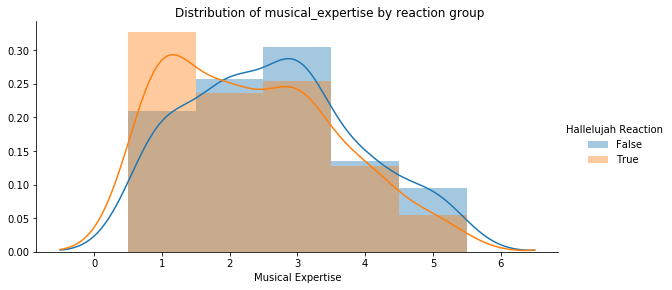

In [50]:
run_tests('Musical Expertise', 'musical_expertise', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

In [57]:
run_tests('Artistic', 'artistic', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Artistic between Hallelujah Reaction groups
T test statistic: 0.2528
T test p-value: 0.8007
Mann-Whitney U test statistic: 3797.5000
Mann-Whitney U test p-value: 0.6697


{'mean_true': 2.381818181818182,
 'mean_false': 2.330827067669173,
 'median_true': 2.0,
 'median_false': 2.0,
 't_stat': 0.25280843322385743,
 't_p': 0.8006954265462966,
 'u_stat': 3797.5,
 'u_p': 0.6696509991221516}

In [59]:
run_tests('Fault', 'fault', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Fault between Hallelujah Reaction groups
T test statistic: 1.9143
T test p-value: 0.0571
Mann-Whitney U test statistic: 4140.0000
Mann-Whitney U test p-value: 0.0871


{'mean_true': 3.4444444444444446,
 'mean_false': 3.0977443609022557,
 'median_true': 4.0,
 'median_false': 3.0,
 't_stat': 1.9142795565285533,
 't_p': 0.057127735196931345,
 'u_stat': 4140.0,
 'u_p': 0.08706302944794662}

In [60]:
run_tests('Imagination', 'imagination', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Imagination between Hallelujah Reaction groups
T test statistic: -0.3411
T test p-value: 0.7334
Mann-Whitney U test statistic: 3392.0000
Mann-Whitney U test p-value: 0.5324


{'mean_true': 3.814814814814815,
 'mean_false': 3.8721804511278197,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': -0.3410894798173458,
 't_p': 0.7334232884706972,
 'u_stat': 3392.0,
 'u_p': 0.5323646951694092}

In [61]:
run_tests('Lazy', 'lazy', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Lazy between Hallelujah Reaction groups
T test statistic: 1.4504
T test p-value: 0.1490
Mann-Whitney U test statistic: 3796.0000
Mann-Whitney U test p-value: 0.6682


{'mean_true': 3.8545454545454545,
 'mean_false': 3.6315789473684212,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 1.450430529528719,
 't_p': 0.14896924203492468,
 'u_stat': 3796.0,
 'u_p': 0.6681841529673529}

In [62]:
run_tests('Nervous', 'nervous', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Nervous between Hallelujah Reaction groups
T test statistic: 1.4618
T test p-value: 0.1455
Mann-Whitney U test statistic: 3941.5000
Mann-Whitney U test p-value: 0.2733


{'mean_true': 3.8333333333333335,
 'mean_false': 3.5714285714285716,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 1.461826110036426,
 't_p': 0.14548541977329782,
 'u_stat': 3941.5,
 'u_p': 0.27328600498352074}

In [63]:
run_tests('Outgoing', 'outgoing', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Outgoing between Hallelujah Reaction groups
T test statistic: -1.9103
T test p-value: 0.0587
Mann-Whitney U test statistic: 2975.0000
Mann-Whitney U test p-value: 0.0594


{'mean_true': 2.962962962962963,
 'mean_false': 3.3157894736842106,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': -1.9103278725392832,
 't_p': 0.05866650165066385,
 'u_stat': 2975.0,
 'u_p': 0.05938718972353949}

In [64]:
run_tests('Reserved', 'reserved', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Reserved between Hallelujah Reaction groups
T test statistic: 1.3654
T test p-value: 0.1738
Mann-Whitney U test statistic: 4054.5000
Mann-Whitney U test p-value: 0.2240


{'mean_true': 3.327272727272727,
 'mean_false': 3.082706766917293,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': 1.365369679501215,
 't_p': 0.17378591151417275,
 'u_stat': 4054.5,
 'u_p': 0.22404790250164774}

In [65]:
run_tests('Stress', 'stress', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Stress between Hallelujah Reaction groups
T test statistic: -2.0289
T test p-value: 0.0439
Mann-Whitney U test statistic: 2995.0000
Mann-Whitney U test p-value: 0.0446
**** Significant Result ****


{'mean_true': 2.8,
 'mean_false': 3.180451127819549,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': -2.028925027914428,
 't_p': 0.04389141893514047,
 'u_stat': 2995.0,
 'u_p': 0.04460488939226947}

In [66]:
run_tests('Thorough', 'thorough', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Thorough between Hallelujah Reaction groups
T test statistic: 1.3017
T test p-value: 0.1946
Mann-Whitney U test statistic: 4015.0000
Mann-Whitney U test p-value: 0.1905


{'mean_true': 3.259259259259259,
 'mean_false': 3.030075187969925,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': 1.3017097693123738,
 't_p': 0.19463418447752145,
 'u_stat': 4015.0,
 'u_p': 0.19047298339708474}

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Trusting between Hallelujah Reaction groups
T test statistic: -1.4146
T test p-value: 0.1589
Mann-Whitney U test statistic: 3293.0000
Mann-Whitney U test p-value: 0.2505


{'mean_true': 3.5272727272727273,
 'mean_false': 3.774436090225564,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': -1.4145864613958519,
 't_p': 0.15886161941386992,
 'u_stat': 3293.0,
 'u_p': 0.2504501429798591}

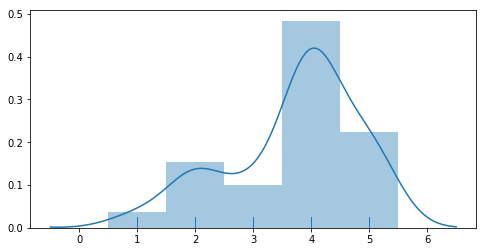

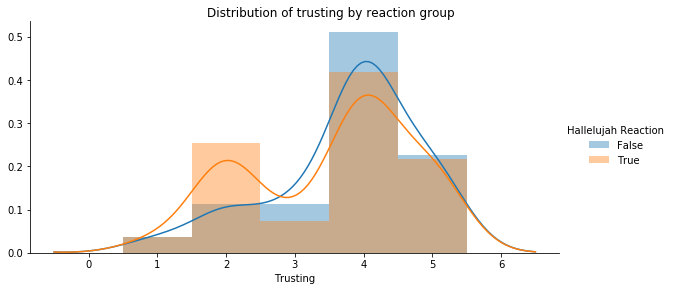

In [68]:
run_tests('Trusting', 'trusting', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=12.404719003200334, pvalue=0.0020246478361931326)
Reaction normal test results: NormaltestResult(statistic=1.861915735871851, pvalue=0.3941759609693383)
No-reaction normal test results: NormaltestResult(statistic=10.482554306534496, pvalue=0.005293491916374269)
Student's t-test for difference in mean Activity between Hallelujah Reaction groups
T test statistic: -1.7582
T test p-value: 0.0798
Mann-Whitney U test statistic: 6944.5000
Mann-Whitney U test p-value: 0.0629


{'mean_true': 3.189189189189189,
 'mean_false': 3.44954128440367,
 'median_true': 3.0,
 'median_false': 4.0,
 't_stat': -1.758231132622371,
 't_p': 0.07976303817859073,
 'u_stat': 6944.5,
 'u_p': 0.06291372490478749}

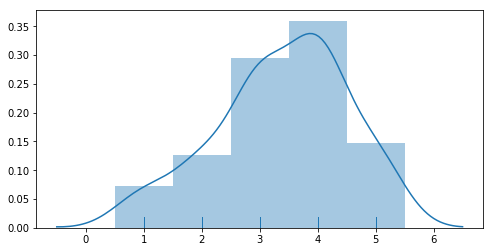

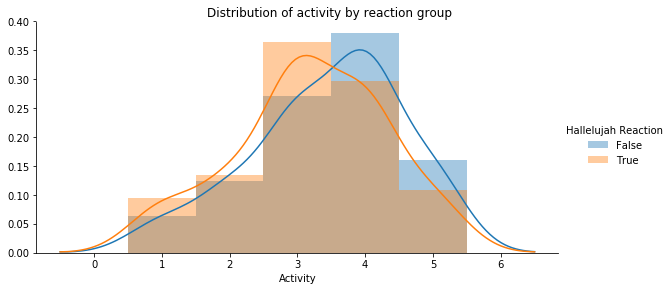

In [51]:
run_tests('Activity', 'activity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=76.35643063541677, pvalue=2.6267077690385964e-17)
Reaction normal test results: NormaltestResult(statistic=9.724907981967412, pvalue=0.007731487591455645)
No-reaction normal test results: NormaltestResult(statistic=73.55201706255988, pvalue=1.0675357517118451e-16)
Student's t-test for difference in mean Engagement between Hallelujah Reaction groups
T test statistic: 0.9124
T test p-value: 0.3623
Mann-Whitney U test statistic: 8710.0000
Mann-Whitney U test p-value: 0.2912


{'mean_true': 3.5945945945945947,
 'mean_false': 3.426605504587156,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 0.912362566055548,
 't_p': 0.36233570838310736,
 'u_stat': 8710.0,
 'u_p': 0.29117475262893266}

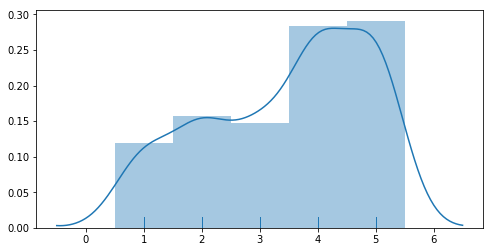

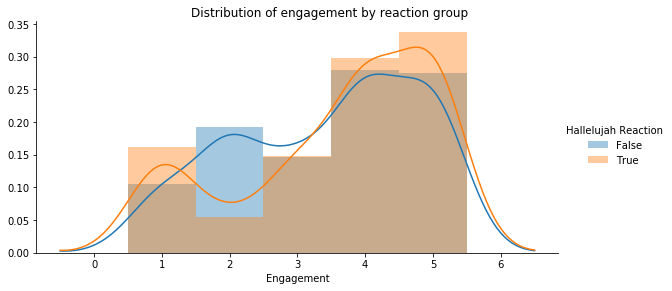

In [52]:
run_tests('Engagement', 'engagement', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=0.7863135806338903, pvalue=0.674922917911603)
Reaction normal test results: NormaltestResult(statistic=79.62122224371831, pvalue=5.1341821040775095e-18)
No-reaction normal test results: NormaltestResult(statistic=490.81856197724255, pvalue=2.6308946560361688e-107)
Student's t-test for difference in mean Familiarity between Hallelujah Reaction groups
T test statistic: -1.9372
T test p-value: 0.0537
Mann-Whitney U test statistic: 6931.0000
Mann-Whitney U test p-value: 0.0622


{'mean_true': 2.635135135135135,
 'mean_false': 3.022935779816514,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': -1.9372300766221817,
 't_p': 0.05368815829300612,
 'u_stat': 6931.0,
 'u_p': 0.062166872927065554}

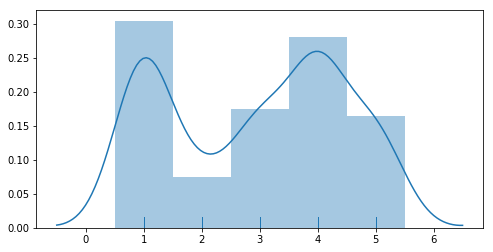

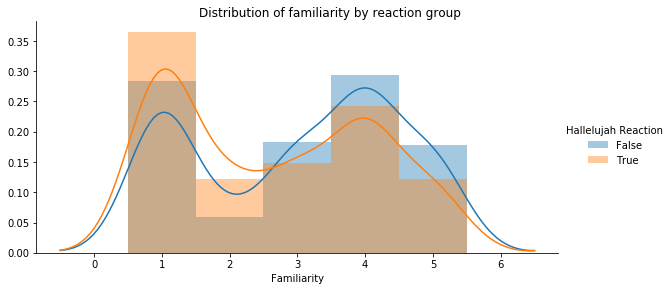

In [53]:
run_tests('Familiarity', 'familiarity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=189.7170899975323, pvalue=6.360003368458789e-42)
Reaction normal test results: NormaltestResult(statistic=10.128278181585149, pvalue=0.006319348947330922)
No-reaction normal test results: NormaltestResult(statistic=208.26403451241652, pvalue=5.970896129106752e-46)
Student's t-test for difference in mean Like/dislike between Hallelujah Reaction groups
T test statistic: 1.2078
T test p-value: 0.2281
Mann-Whitney U test statistic: 8773.0000
Mann-Whitney U test p-value: 0.2475


{'mean_true': 3.5675675675675675,
 'mean_false': 3.334862385321101,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 1.2078207388771347,
 't_p': 0.2281002989618067,
 'u_stat': 8773.0,
 'u_p': 0.24751961471180262}

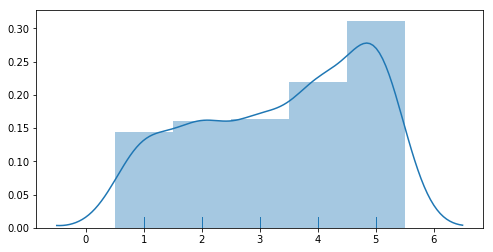

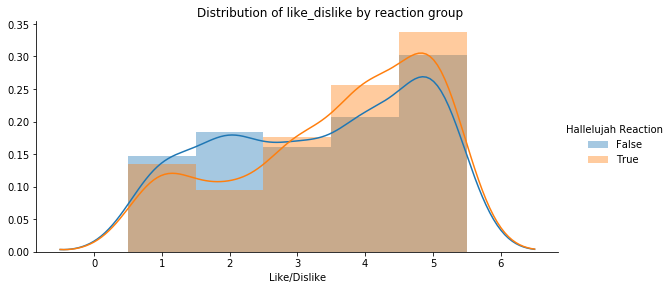

In [54]:
run_tests('Like/Dislike', 'like_dislike', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=29.634041875896784, pvalue=3.6732422282781456e-07)
Reaction normal test results: NormaltestResult(statistic=7.1908023500878375, pvalue=0.027449668844722067)
No-reaction normal test results: NormaltestResult(statistic=21.104888185840174, pvalue=2.6129539737473492e-05)
Student's t-test for difference in mean Positivity between Hallelujah Reaction groups
T test statistic: 0.5732
T test p-value: 0.5670
Mann-Whitney U test statistic: 8498.0000
Mann-Whitney U test p-value: 0.4782


{'mean_true': 3.5945945945945947,
 'mean_false': 3.5,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 0.5732005026208975,
 't_p': 0.5669531400116274,
 'u_stat': 8498.0,
 'u_p': 0.47818175911405036}

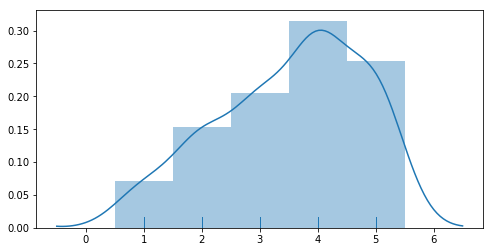

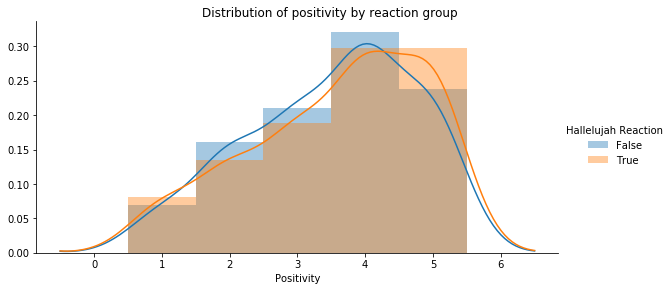

In [55]:
run_tests('Positivity', 'positivity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=43.548001969261016, pvalue=3.4968058772270024e-10)
Reaction normal test results: NormaltestResult(statistic=12.47736102731966, pvalue=0.0019524300287119558)
No-reaction normal test results: NormaltestResult(statistic=32.79368170762948, pvalue=7.567326919813604e-08)
Student's t-test for difference in mean Tension between Hallelujah Reaction groups
T test statistic: 1.1562
T test p-value: 0.2485
Mann-Whitney U test statistic: 8706.5000
Mann-Whitney U test p-value: 0.2763


{'mean_true': 4.202702702702703,
 'mean_false': 4.055045871559633,
 'median_true': 4.0,
 'median_false': 4.0,
 't_stat': 1.1562092126231291,
 't_p': 0.24854719463843344,
 'u_stat': 8706.5,
 'u_p': 0.27628153509507003}

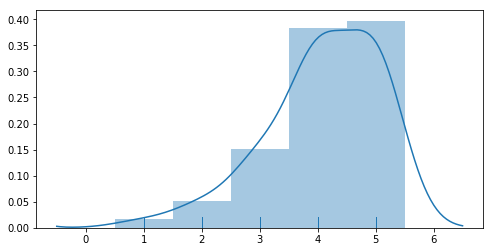

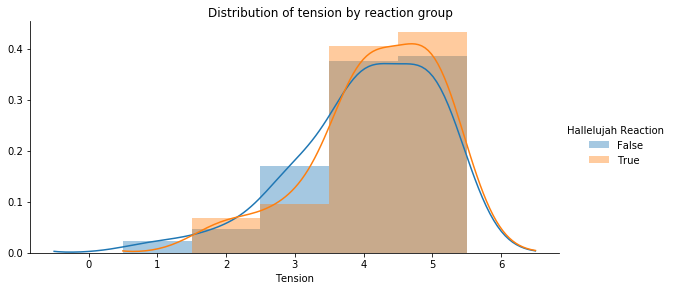

In [56]:
run_tests('Tension', 'tension', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

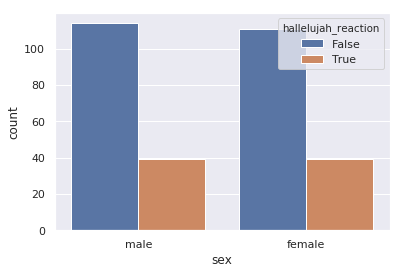

In [774]:
sns.countplot(x='sex', hue='hallelujah_reaction', data=df_all)

In [775]:
# Chi-squared test of male/female proportions

cross = pd.crosstab(df_all['sex'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of sex vs hallelujah reaction proportions')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
sex                              
female                 111     39
male                   114     39

Chi-squared test of sex vs hallelujah reaction proportions
Test statistic: 0.0009
p-value: 0.9761
Degrees of freedom: 1


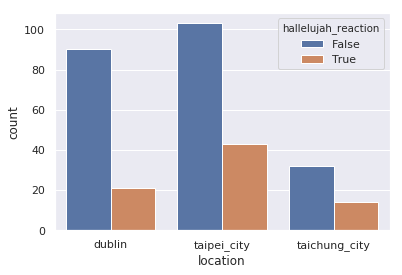

In [776]:
sns.countplot(x='location', hue='hallelujah_reaction', data=df_all)

In [777]:
# Chi-squared test of location proportions

cross = pd.crosstab(df_all['location'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of location vs hallelujah reaction proportions')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
location                         
dublin                  90     21
taichung_city           32     14
taipei_city            103     43

Chi-squared test of location vs hallelujah reaction proportions
Test statistic: 4.2845
p-value: 0.1174
Degrees of freedom: 2


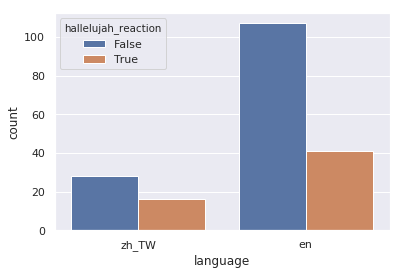

In [722]:
sns.countplot(x='language', hue='hallelujah_reaction', data=df_all)

In [723]:
# Chi-squared test of language proportions

cross = pd.crosstab(df_all['language'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of language vs hallelujah reaction proportions (for Taiwanese, English, and NA)')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

df_no_na_lang = df_all[df_all['language'] != 'NA']
cross = pd.crosstab(df_no_na_lang['language'], df_no_na_lang['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of language vs hallelujah reaction proportions (for only Taiwanese and English)')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
language                         
en                     107     41
zh_TW                   28     16

Chi-squared test of language vs hallelujah reaction proportions (for Taiwanese, English, and NA)
Test statistic: 0.8392
p-value: 0.3596
Degrees of freedom: 1


hallelujah_reaction  False  True 
language                         
en                     107     41
zh_TW                   28     16

Chi-squared test of language vs hallelujah reaction proportions (for only Taiwanese and English)
Test statistic: 0.8392
p-value: 0.3596
Degrees of freedom: 1


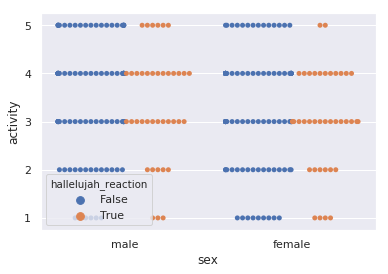

In [724]:
# sns.jointplot(x='activity', y='positivity', kind='scatter', data=df_all)

sns.swarmplot(y='activity', x='sex', hue='hallelujah_reaction', dodge=True, data=df_all)

Sources for Hotelling's $T^2$:
- https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hotellings_Two-Sample_T2.pdf
- https://onlinecourses.science.psu.edu/stat505/node/100/

In [1034]:
def hotelling_t2(X_1, X_2, alpha):
    
    import scipy.stats as sps
    
    n_1 = len(X_1)
    n_2 = len(X_2)

    y_1 = X_1.mean().as_matrix()
    y_1 = y_1.reshape(len(y_1), -1)
    y_2 = X_2.mean().as_matrix()
    y_2 = y_2.reshape(len(y_2), -1)

    # Covariance matrices
    S_1 = np.cov(X_1.astype(np.float64).T)
    S_2 = np.cov(X_2.astype(np.float64).T)

    # Pooled variance
    S_pooled_num = ((n_1 - 1) * S_1) + ((n_2 - 1) * S_2)
    S_pooled_denom = n_1 + n_2 - 2
    S_pooled = S_pooled_num / S_pooled_denom
    
    T_2 = (n_1 * n_2) / (n_1 + n_2)
    T_2 = T_2 * np.matmul((y_1 - y_2).T, np.linalg.pinv(S_pooled))
    T_2 = np.matmul(T_2, (y_1 - y_2))
    T_2 = T_2.squeeze()
    
    p = len(X_1.columns)
    F_num = n_1 + n_2 - p - 1
    F_denom = p * (n_1 + n_2 - 2)
    F = (F_num / F_denom) * T_2
    F = F.squeeze()
    
    df_1 = p
    df_2 = n_1 + n_2 - p - 1
    F_dist = sps.f(df_1, df_2)
    p_value = f_dist.cdf(F)
    
    # Calculate effect size
    D_2 = ((n_1 + n_2) * T_2) / (n_1 * n_2)
    
    return({
        'T2': T_2,
        'F': F,
        'df': (df_1, df_2),
        'p': p_value,
        'D2': D_2
    })

/jet/var/python/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


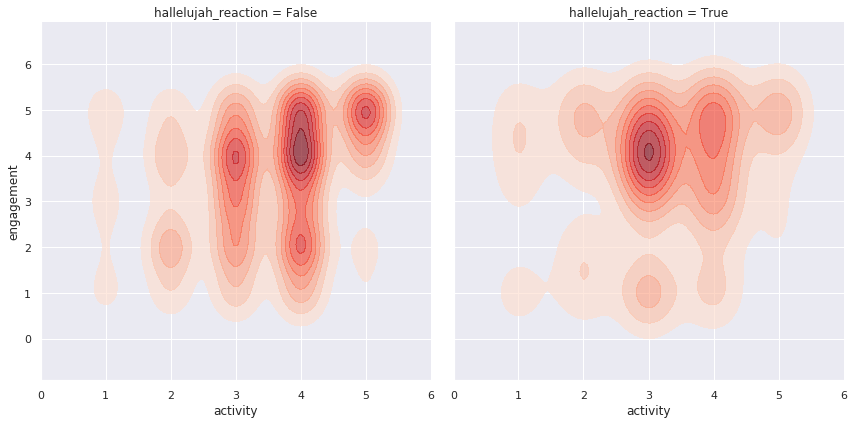

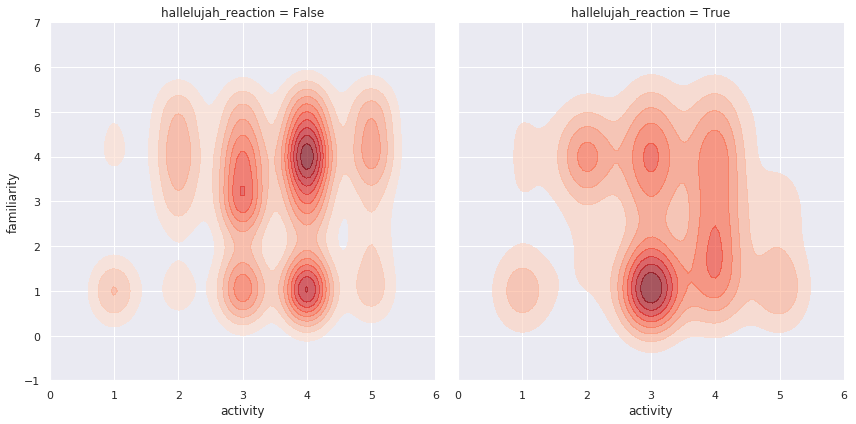

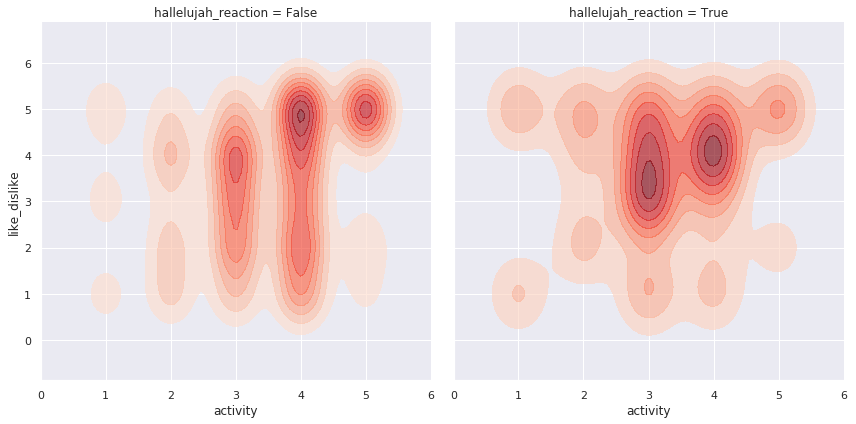

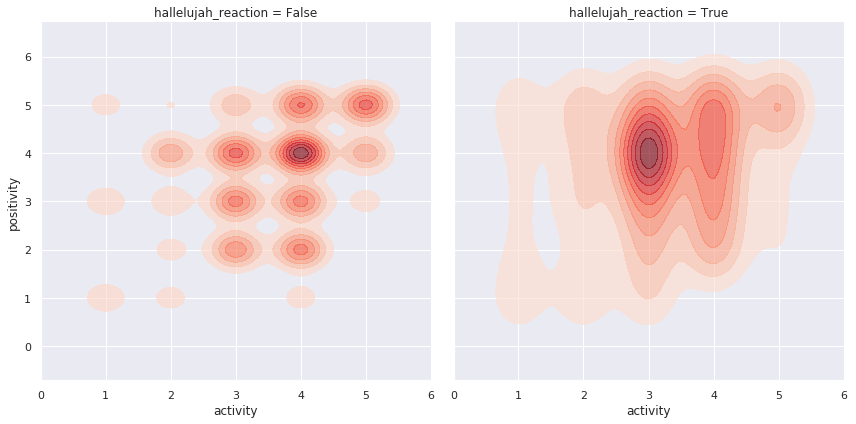

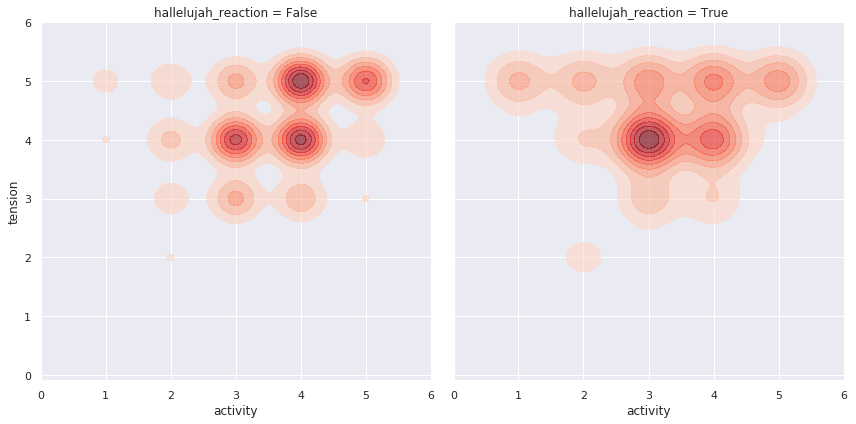

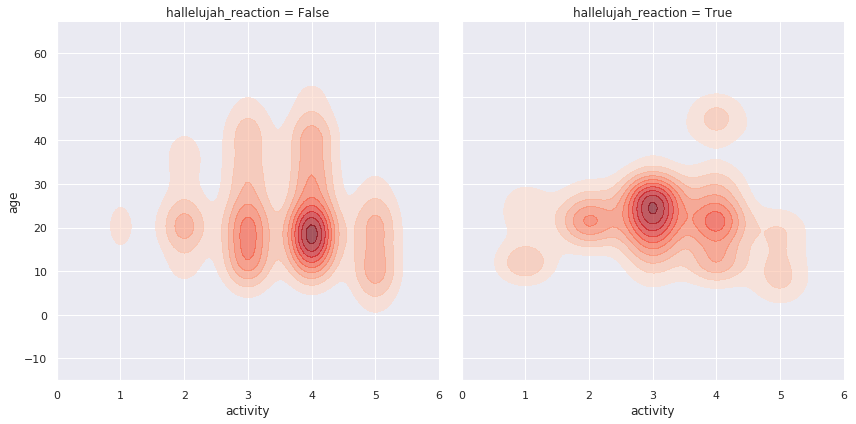

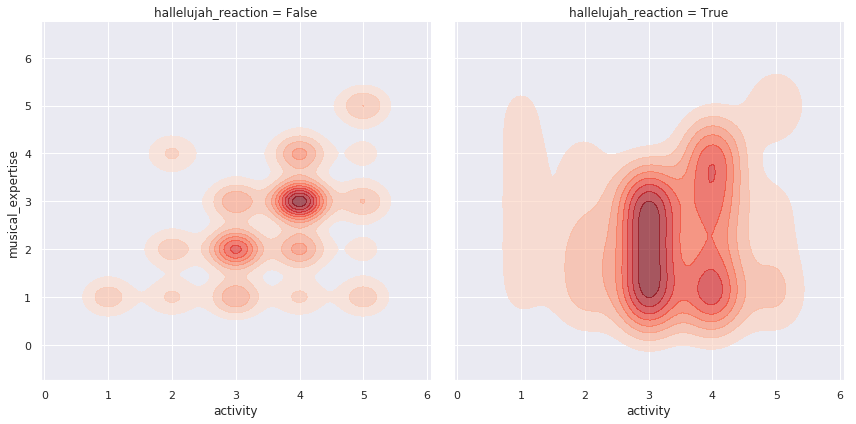

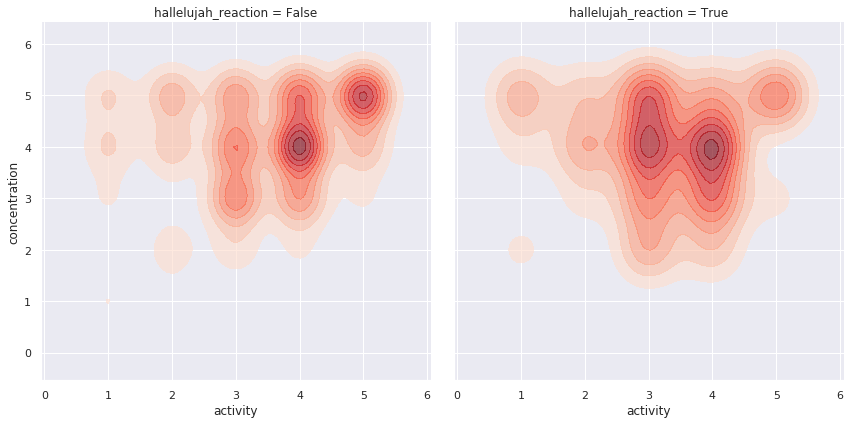

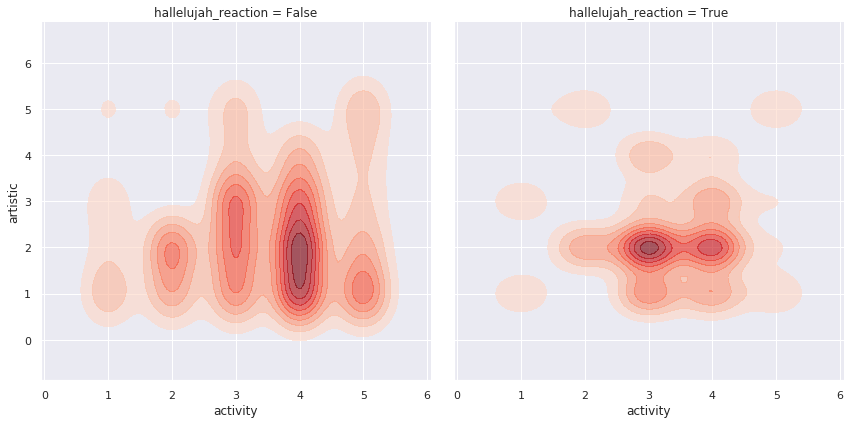

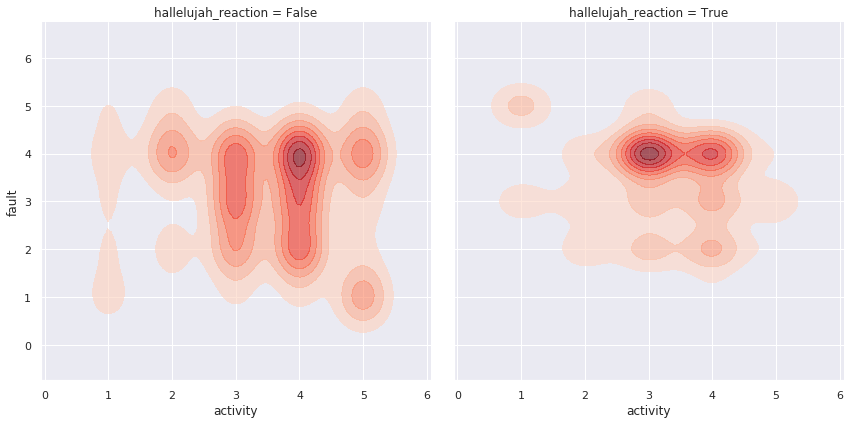

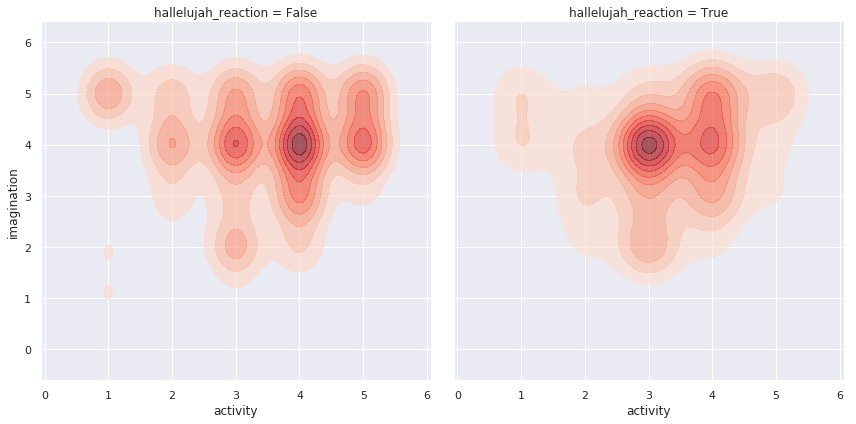

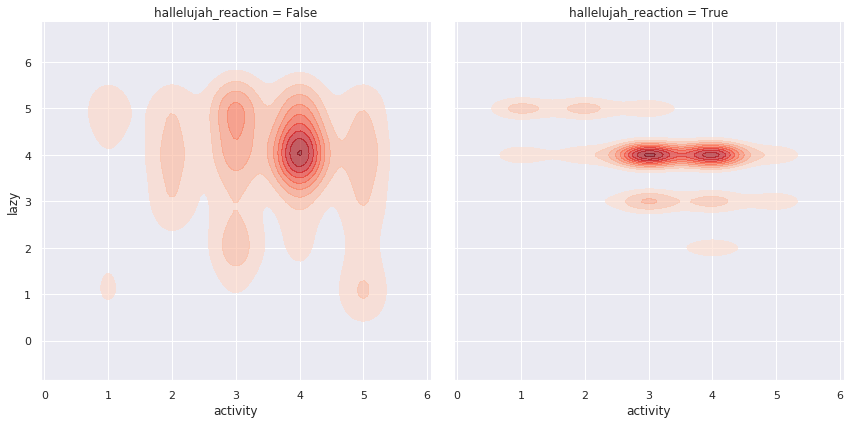

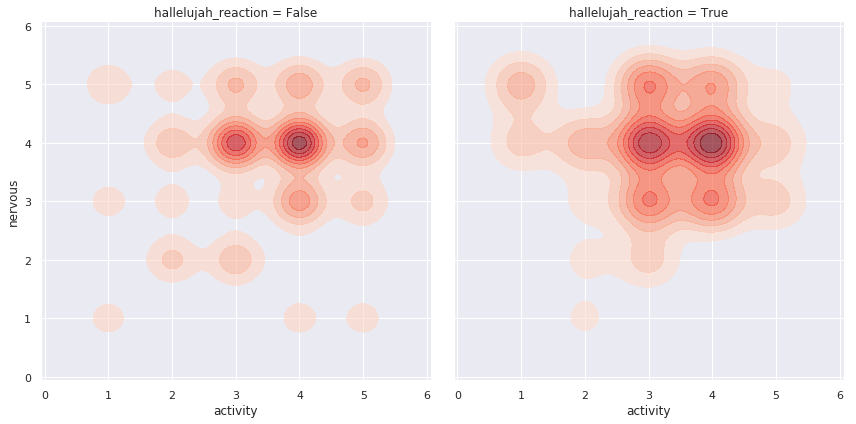

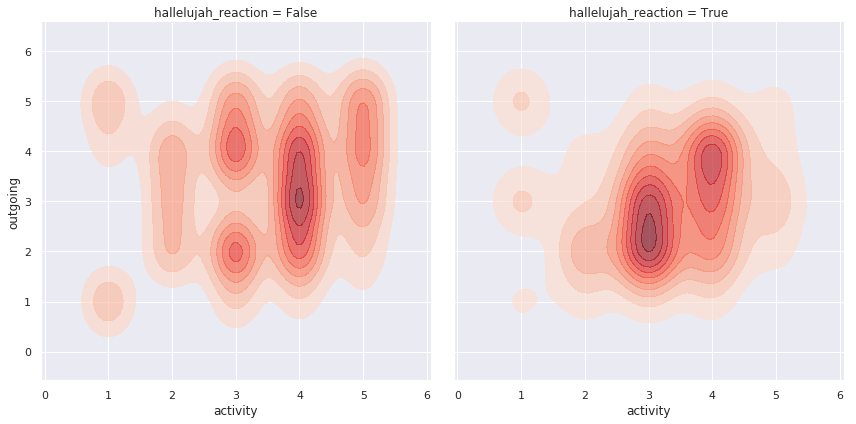

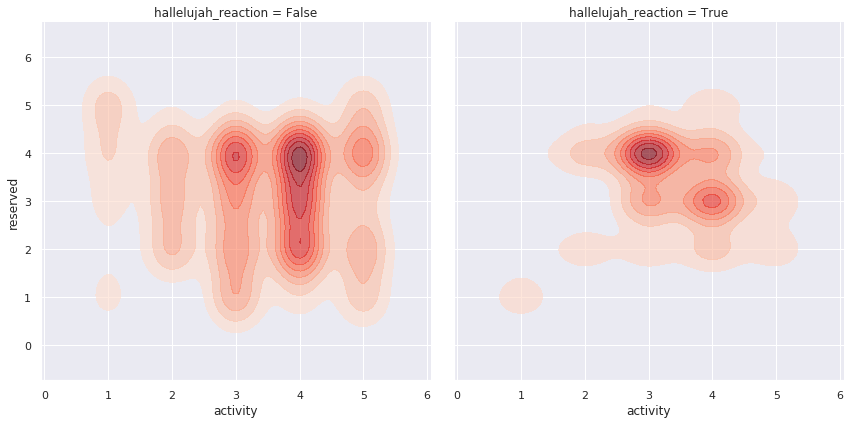

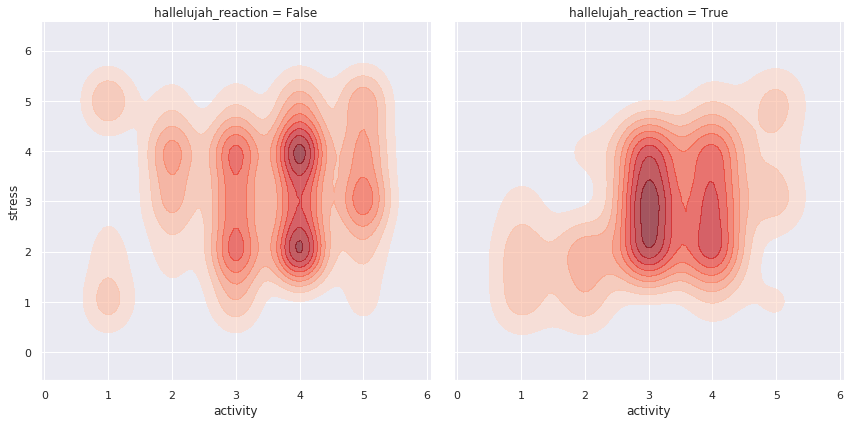

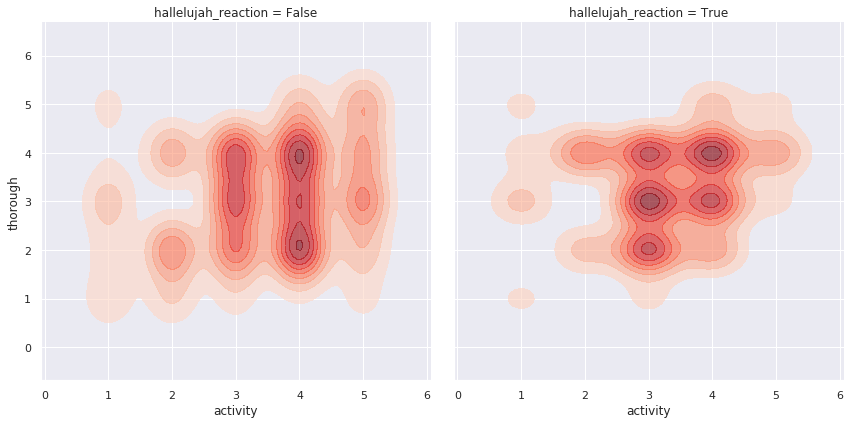

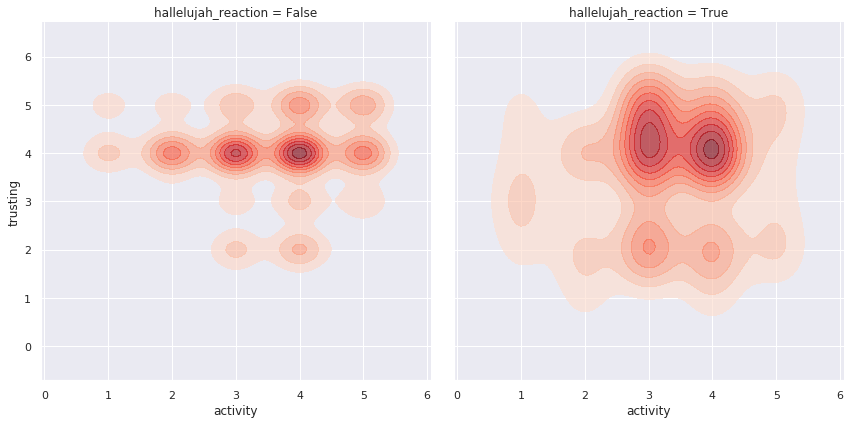

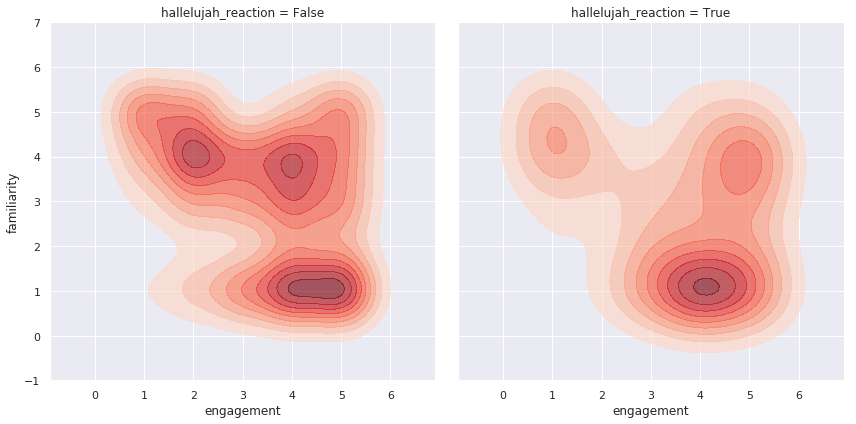

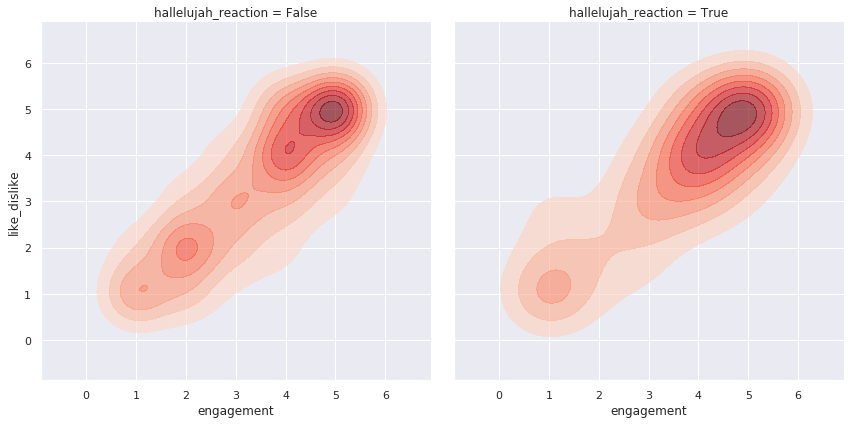

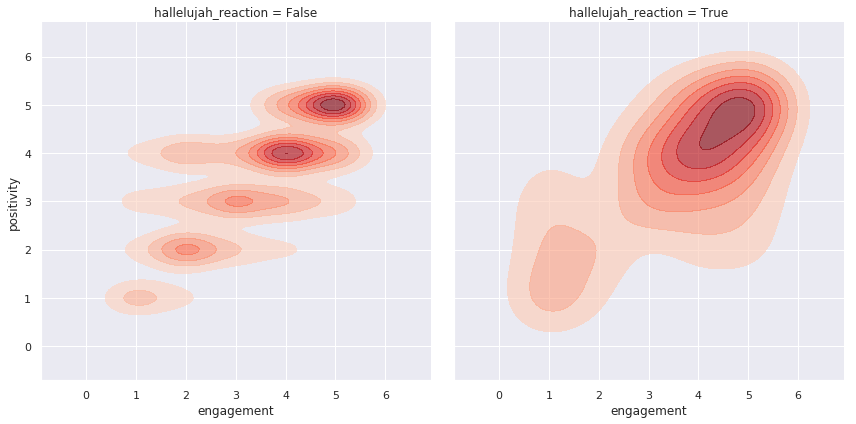

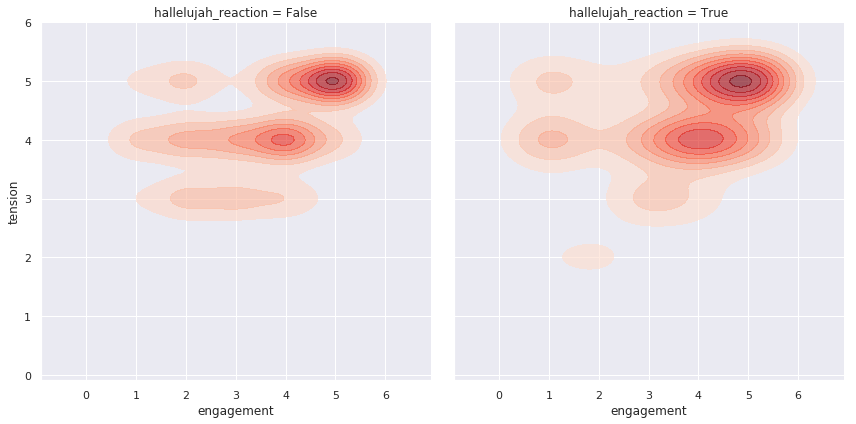

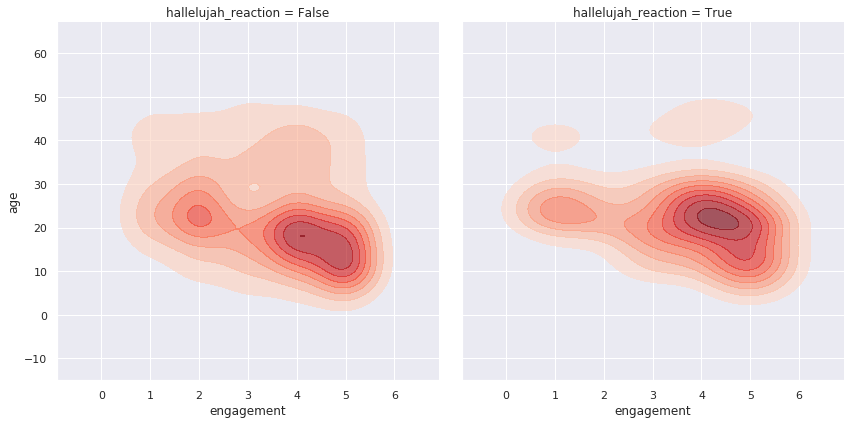

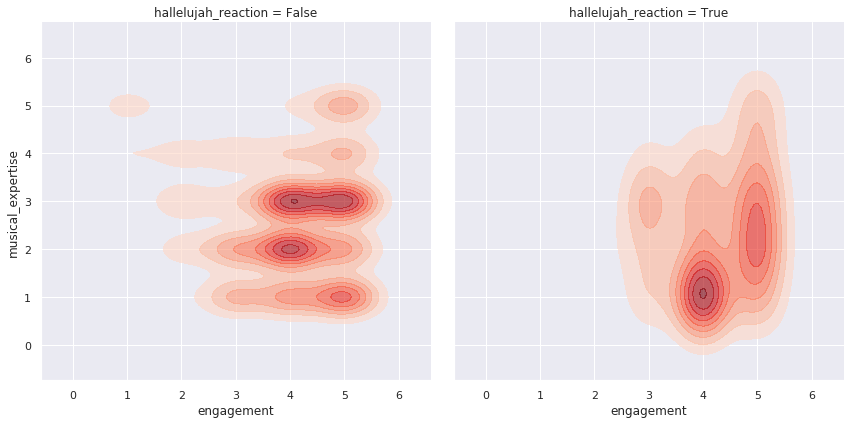

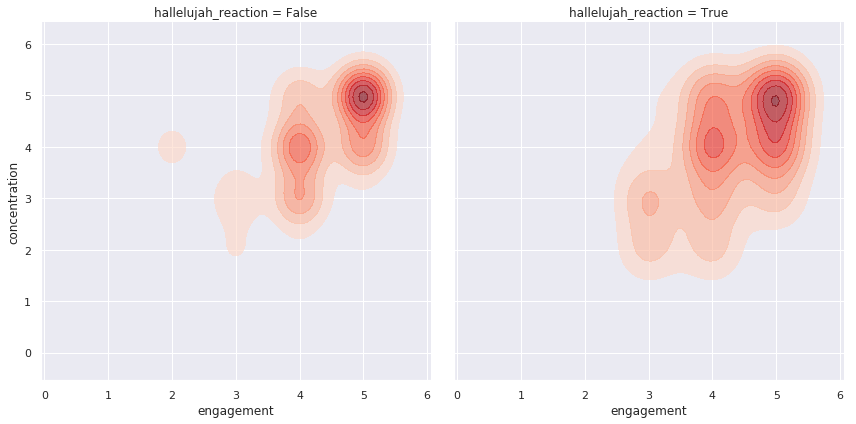

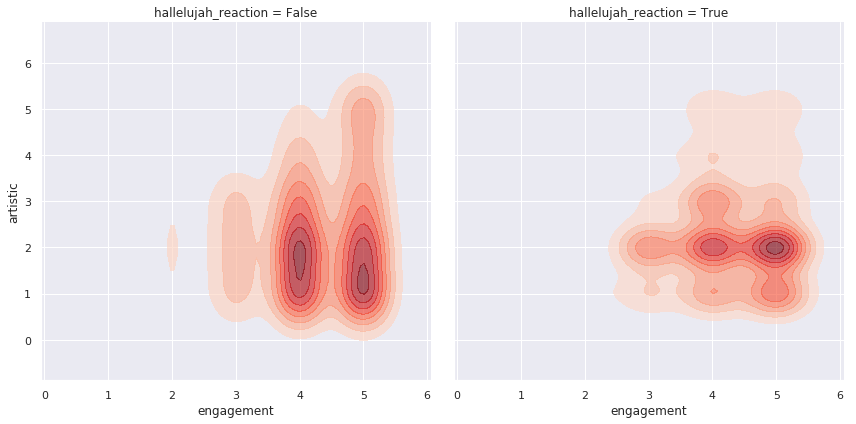

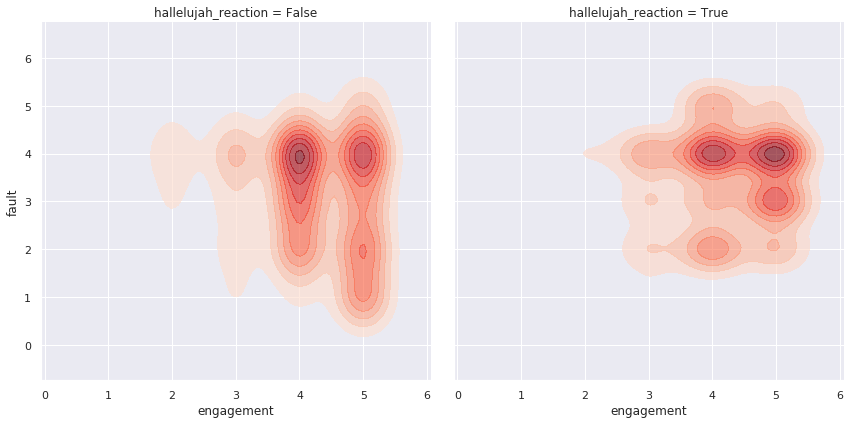

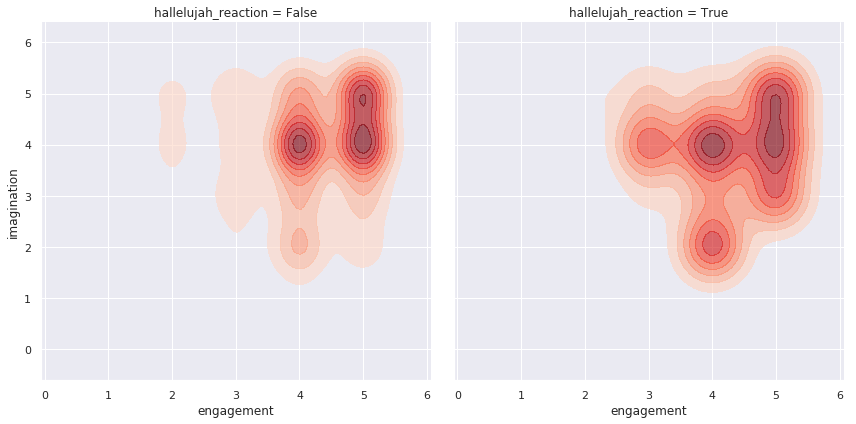

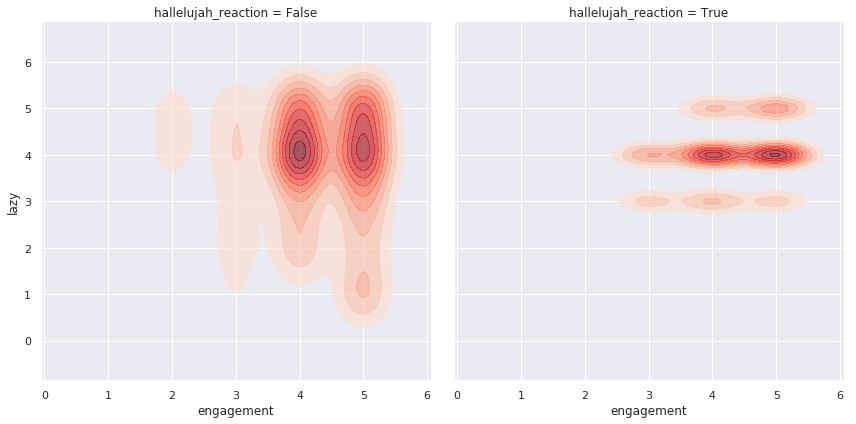

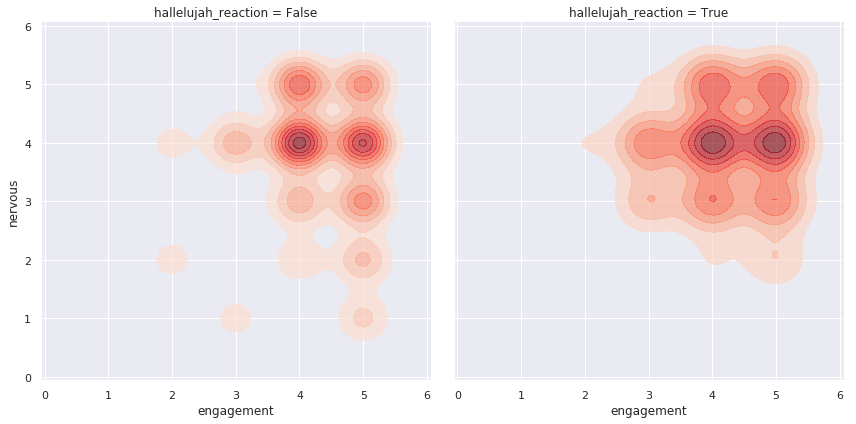

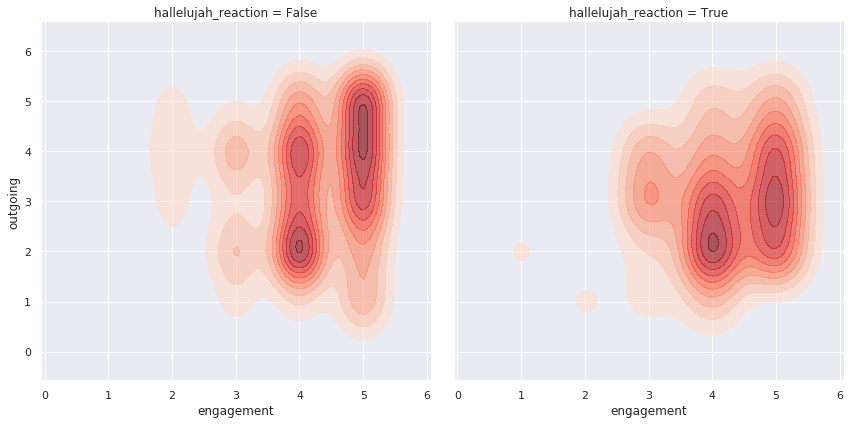

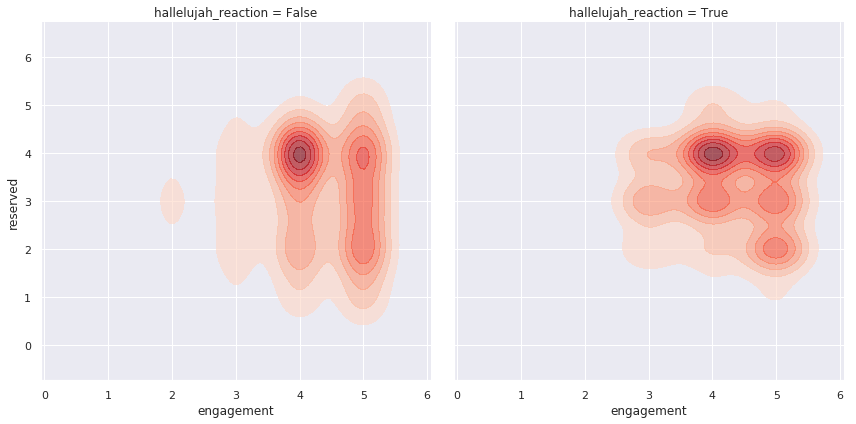

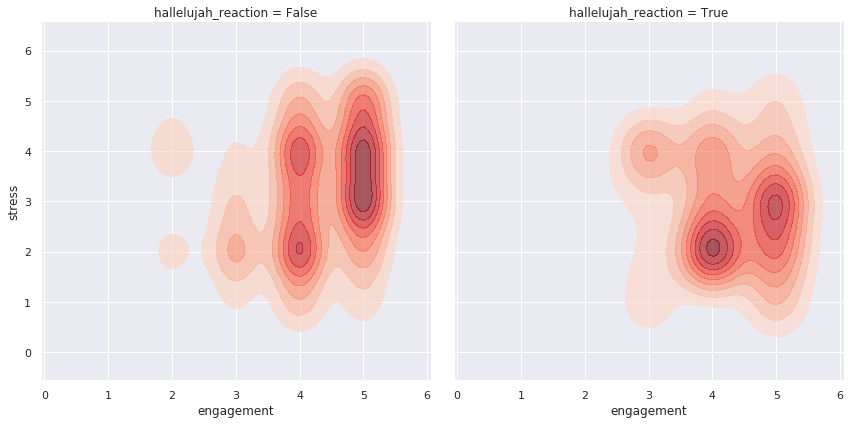

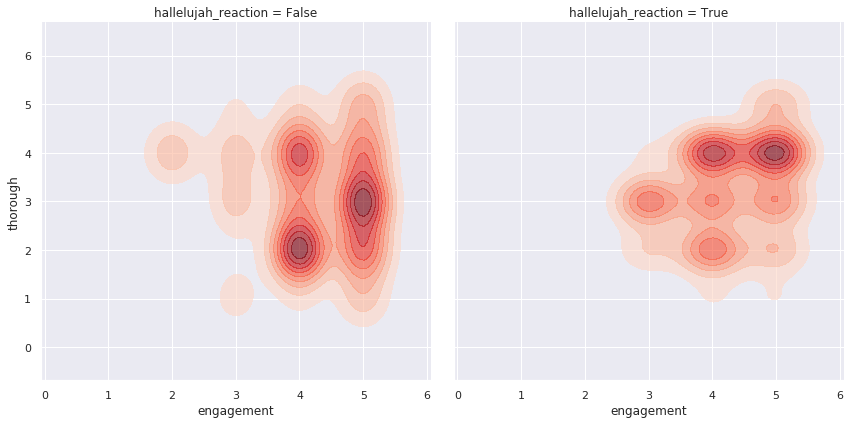

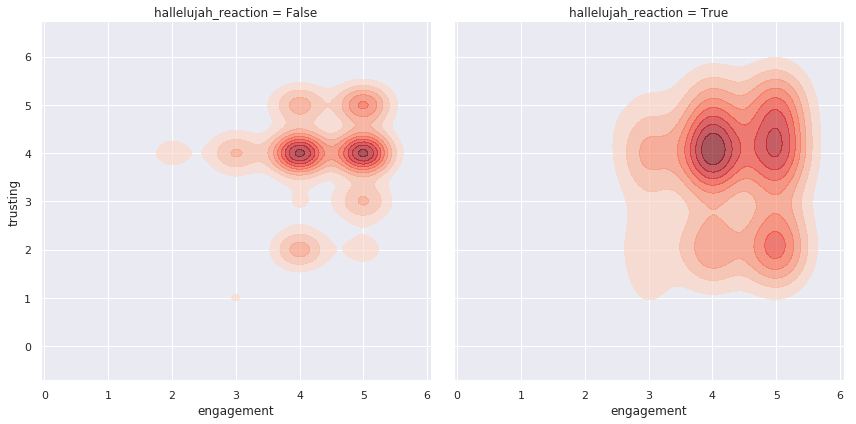

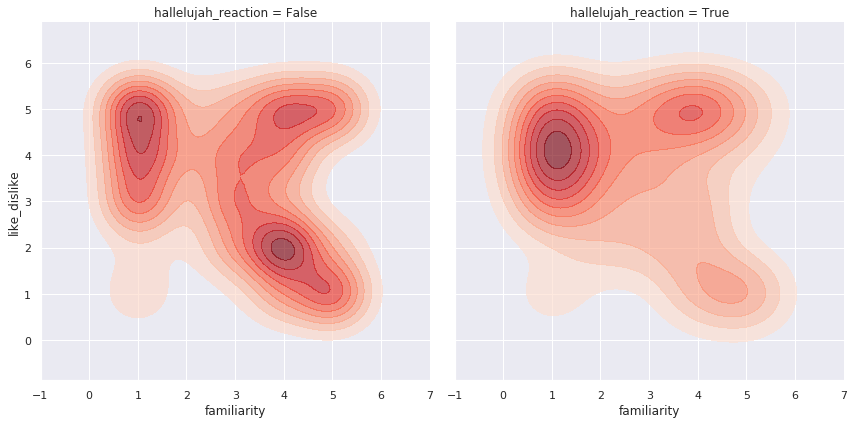

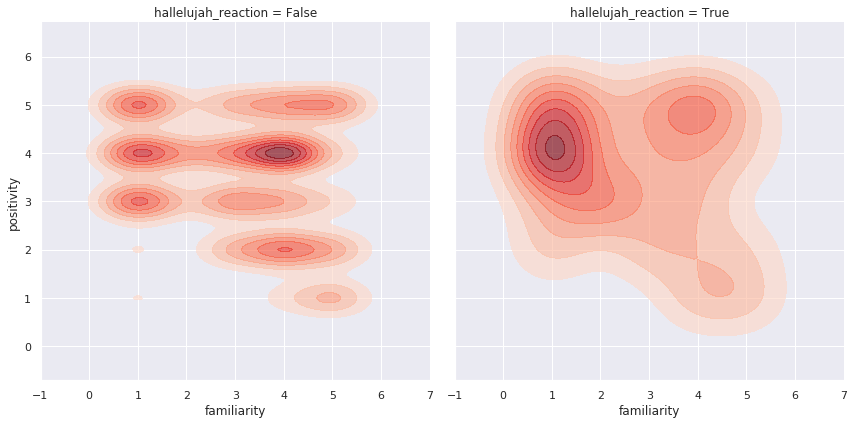

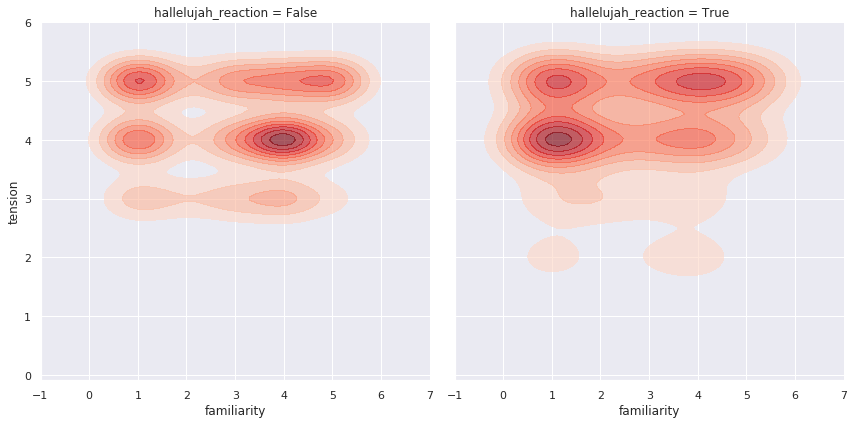

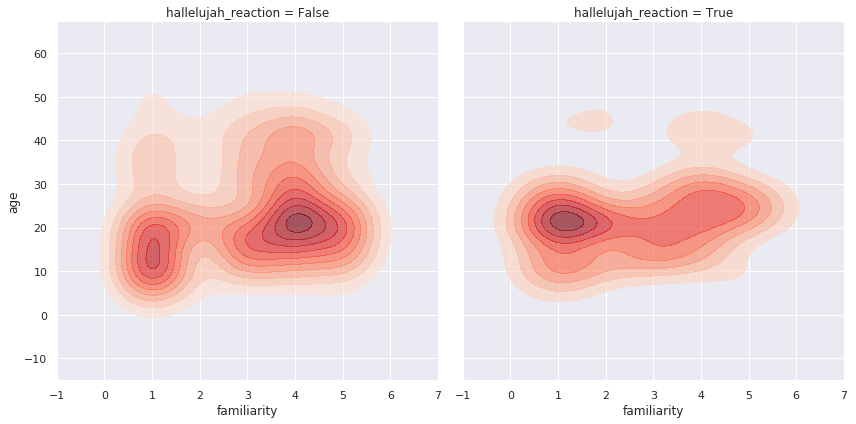

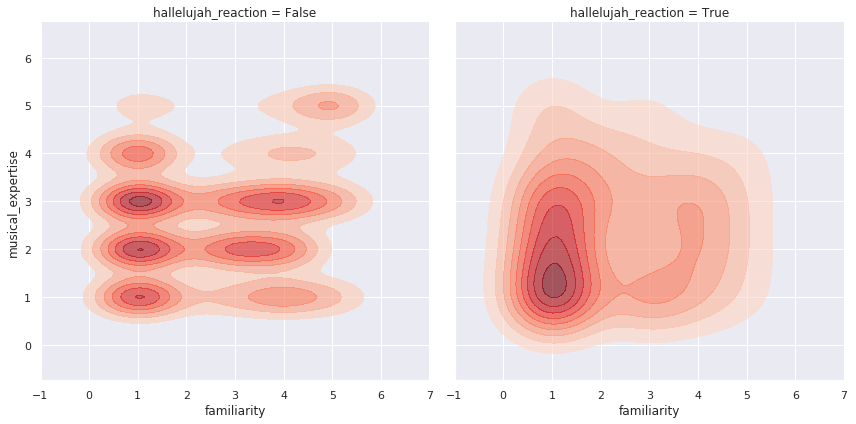

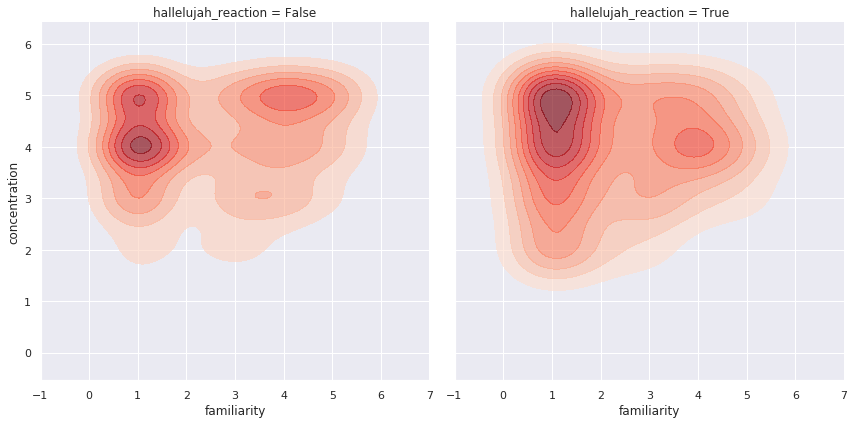

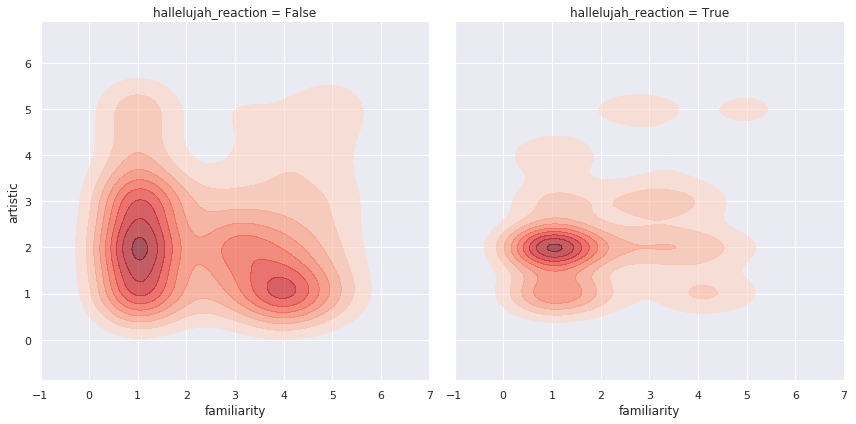

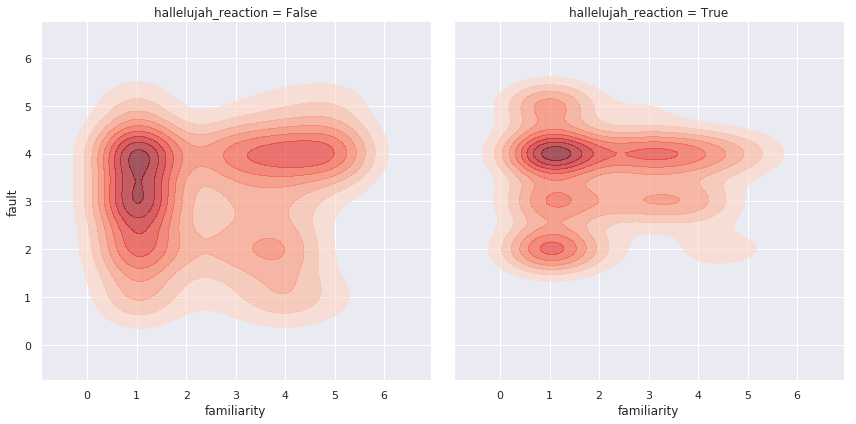

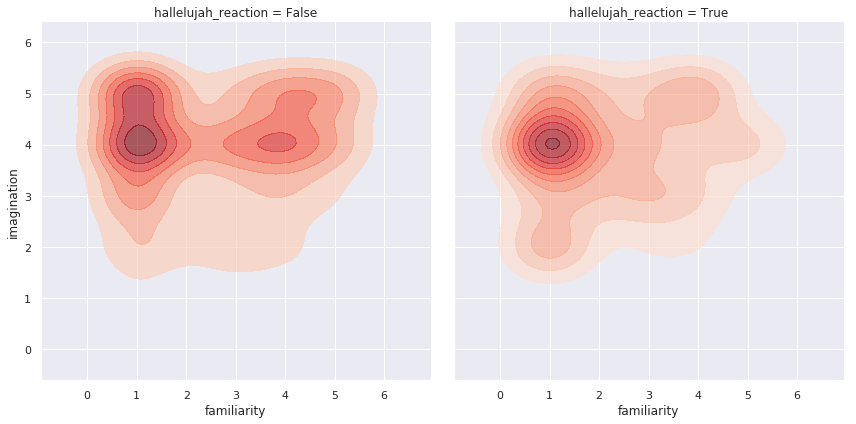

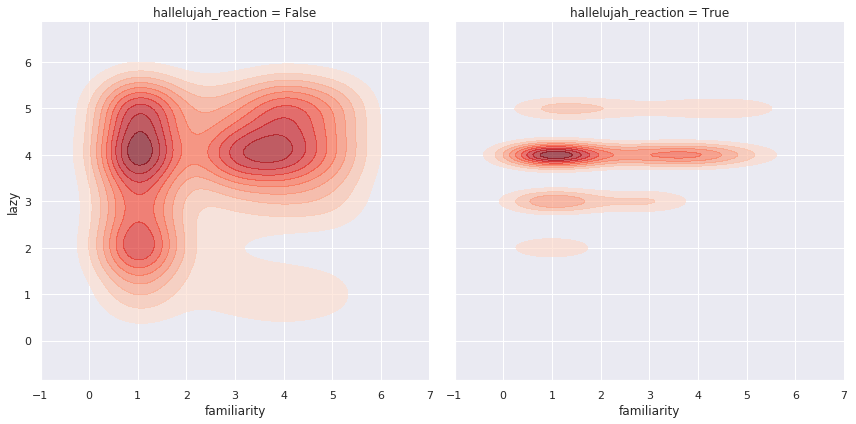

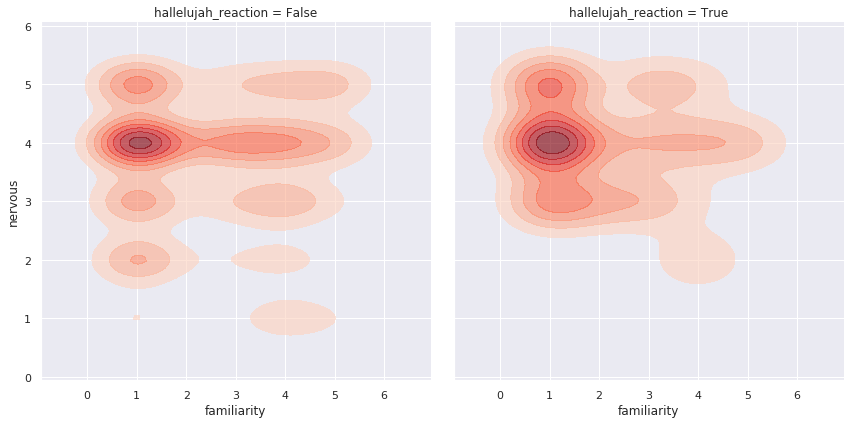

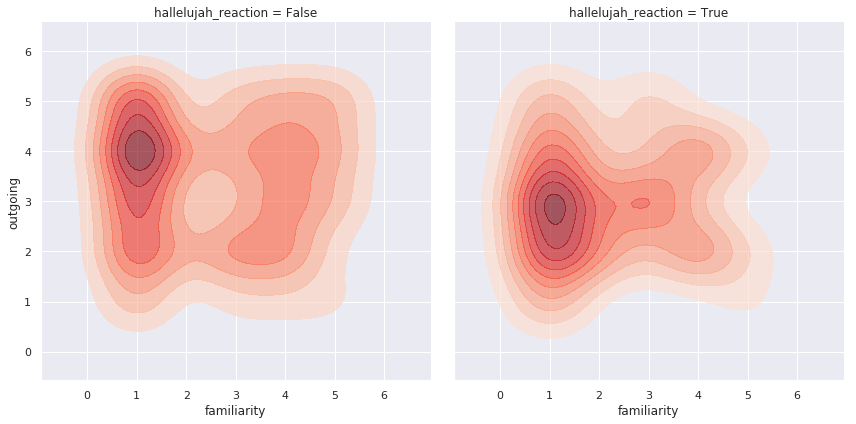

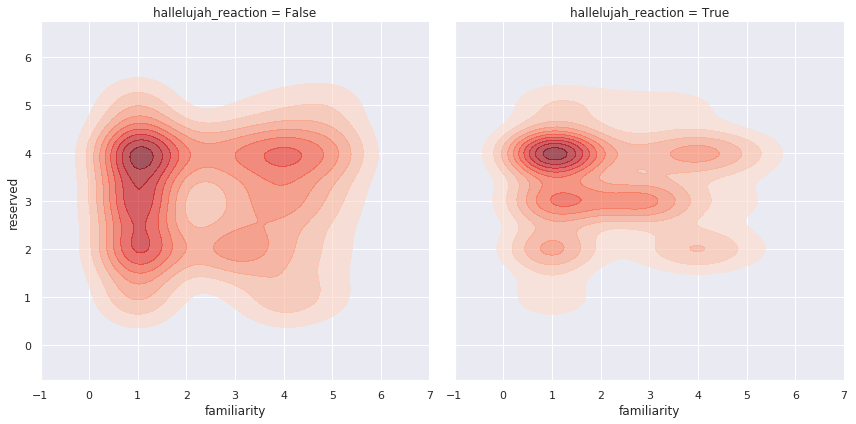

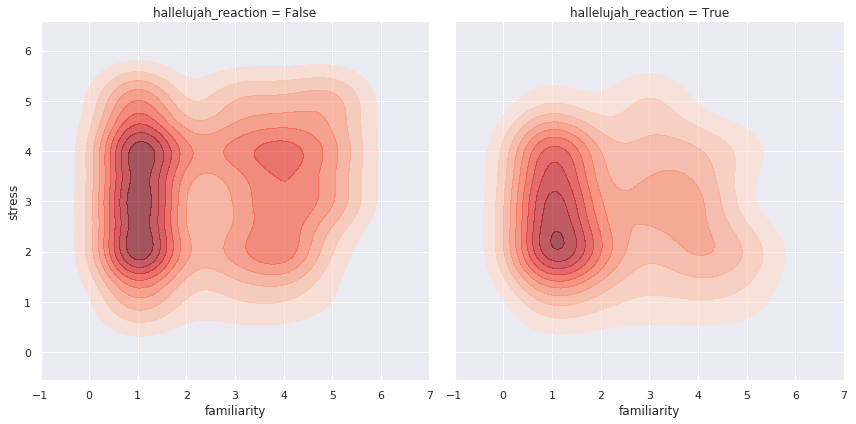

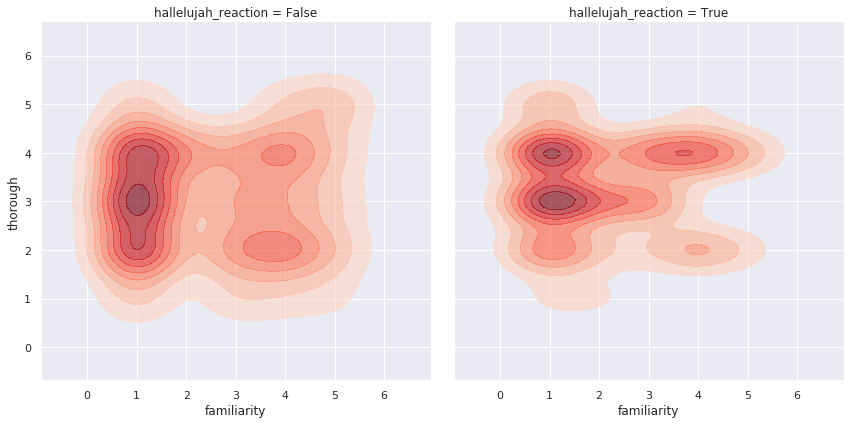

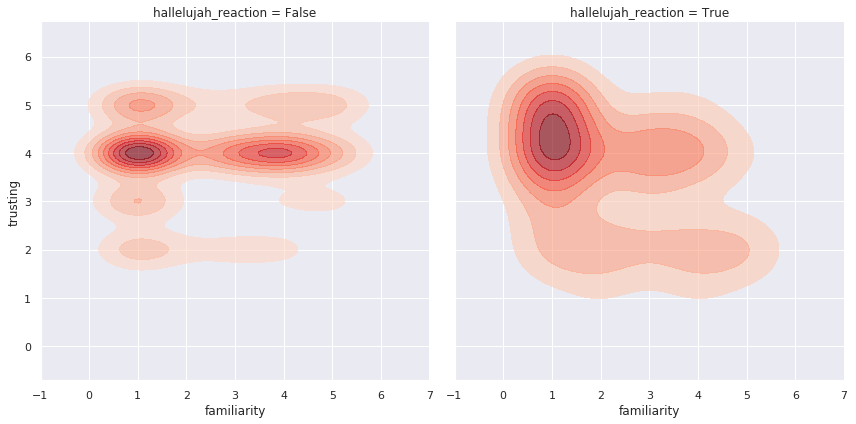

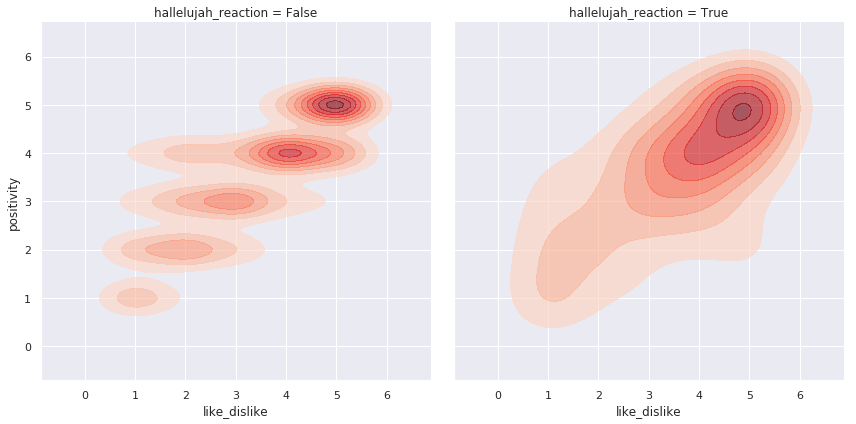

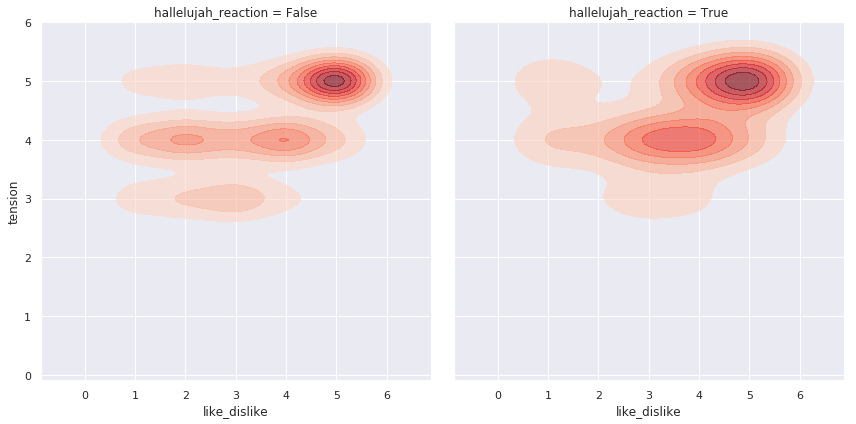

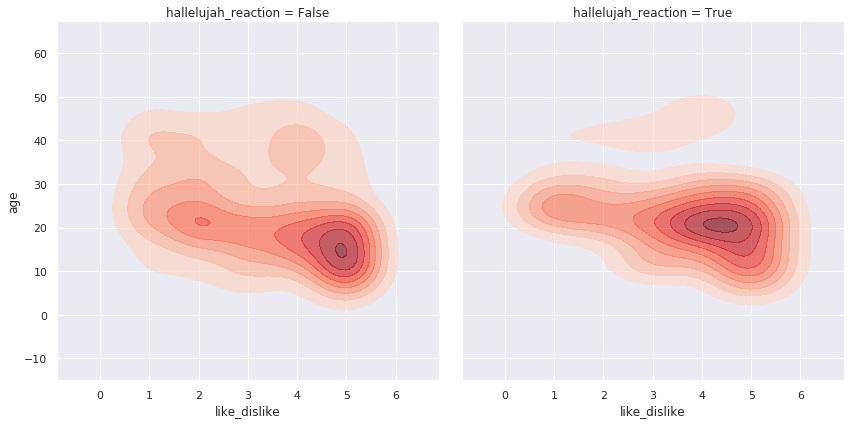

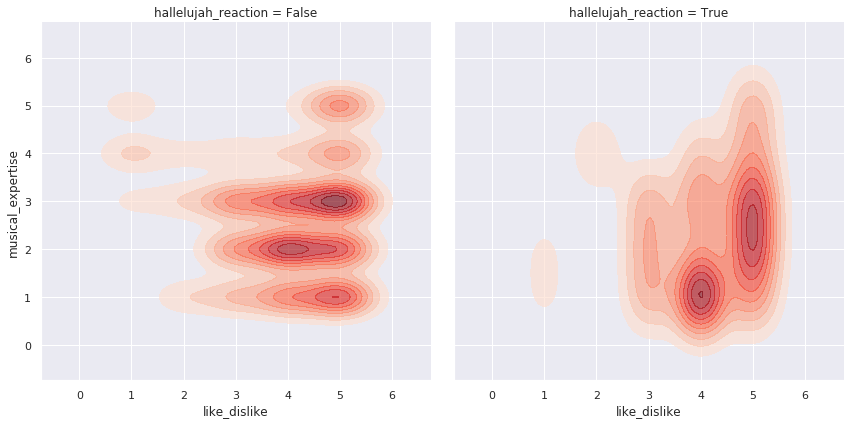

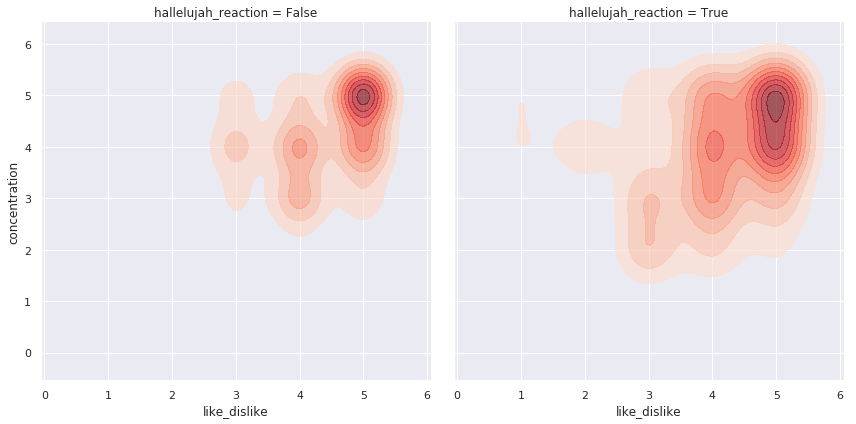

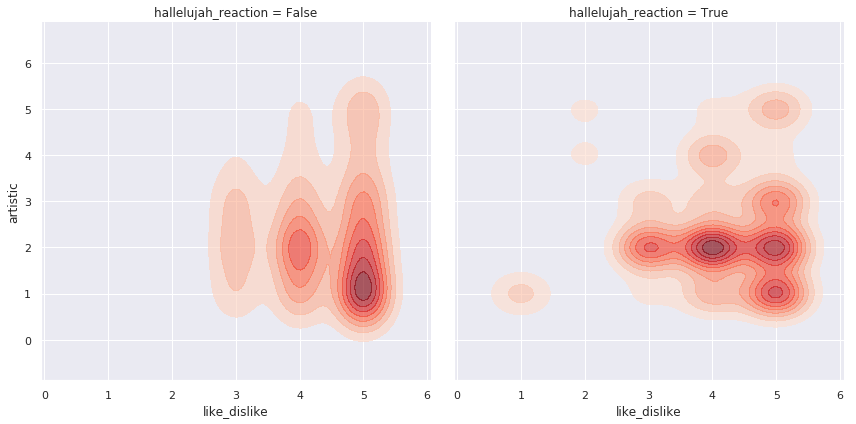

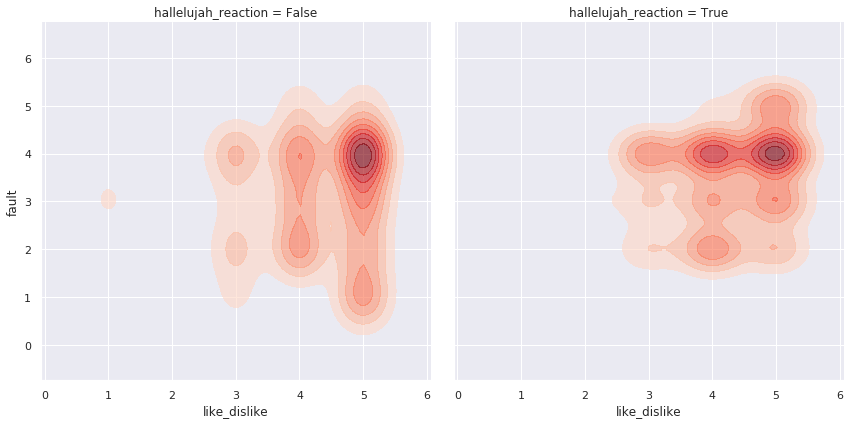

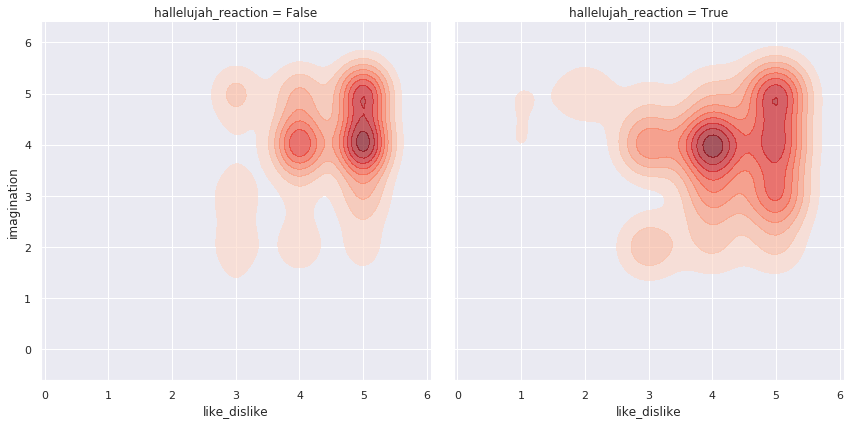

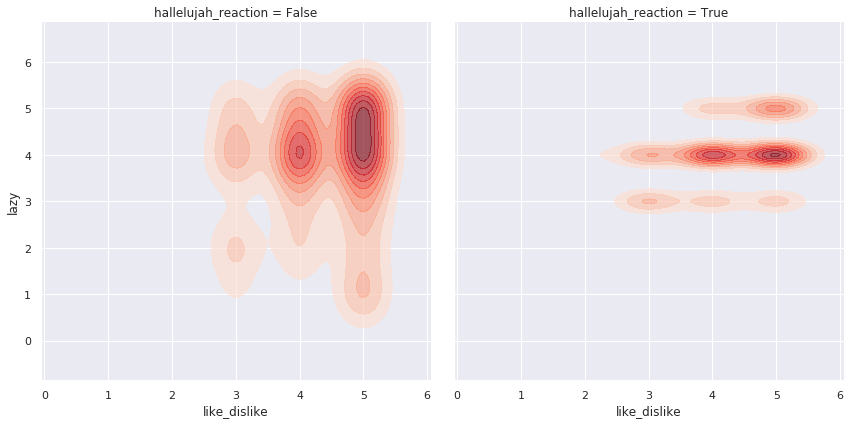

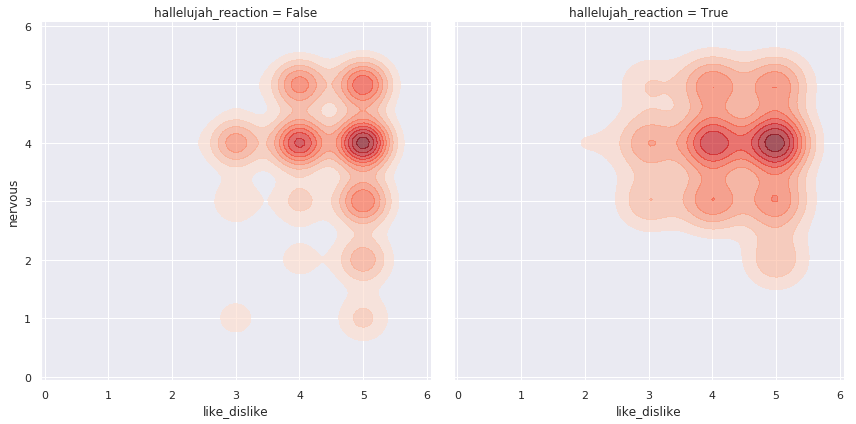

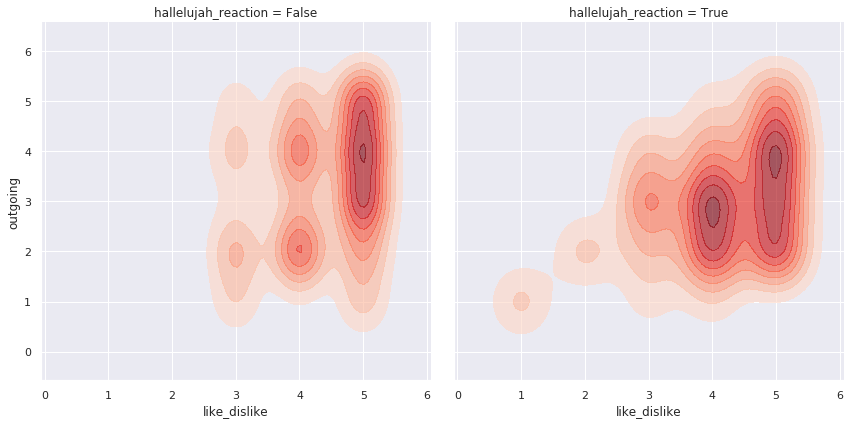

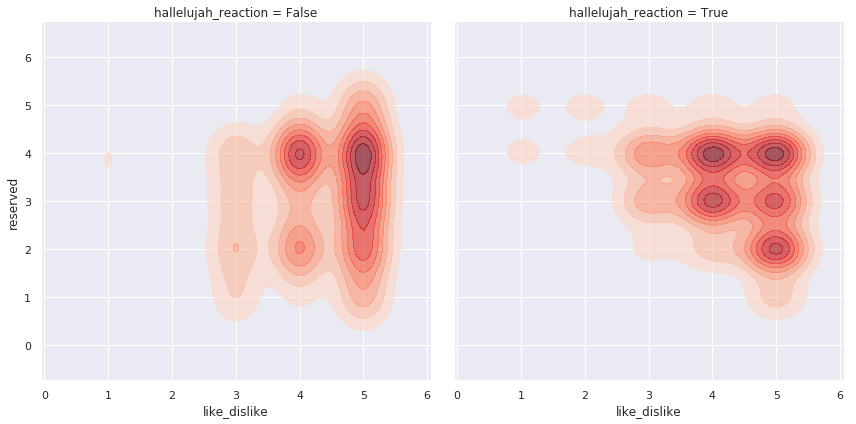

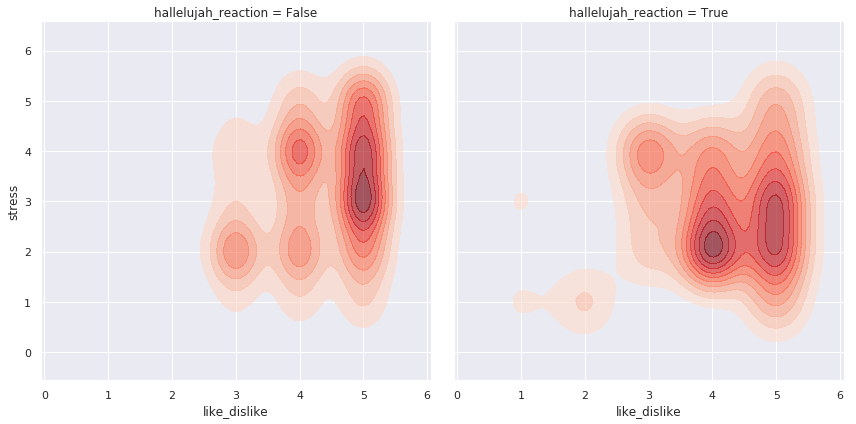

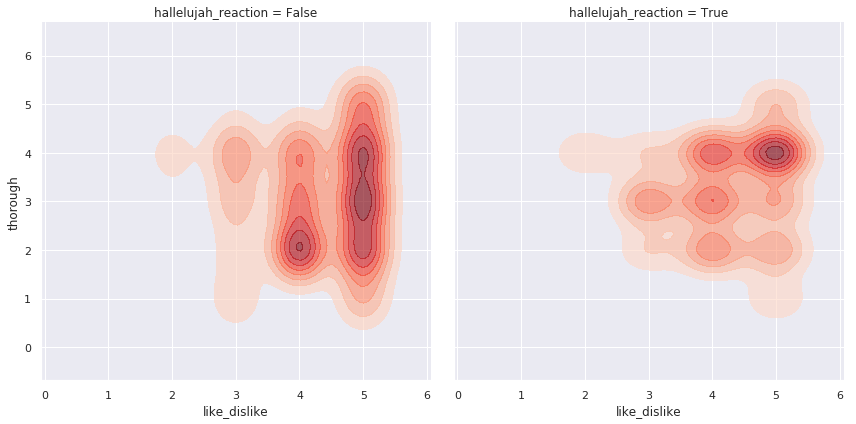

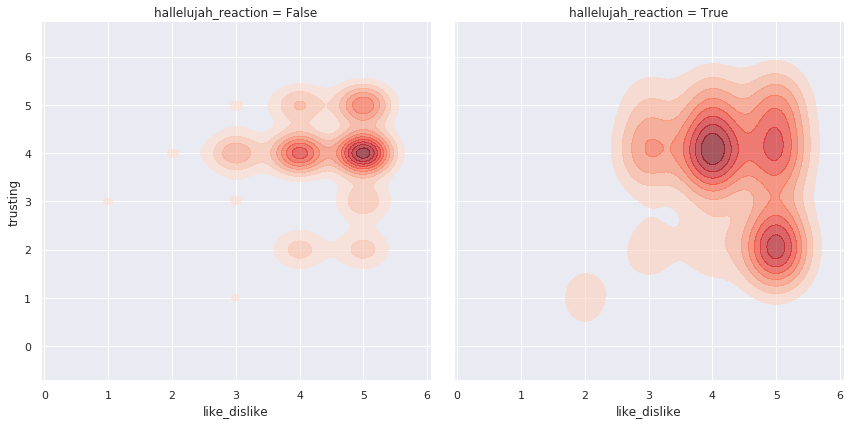

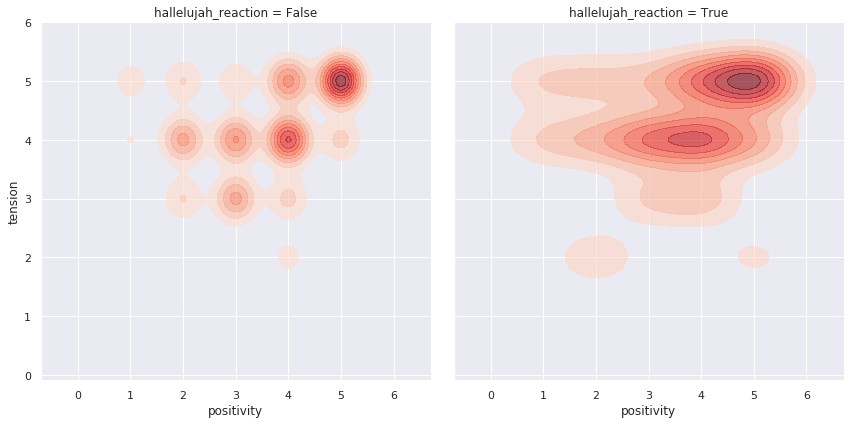

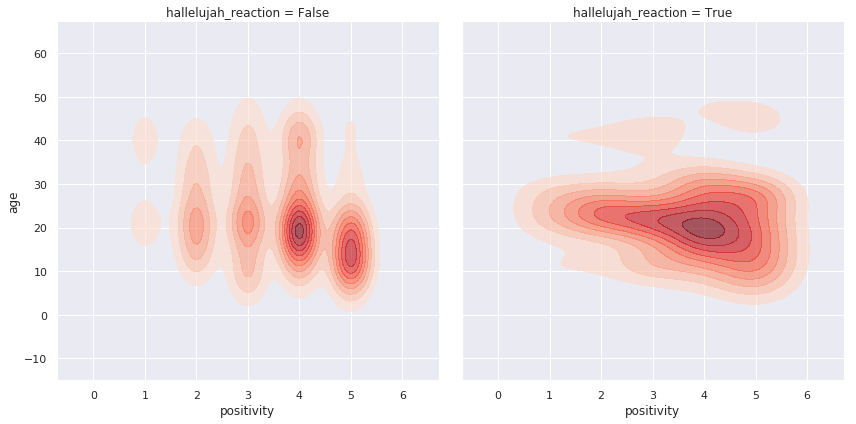

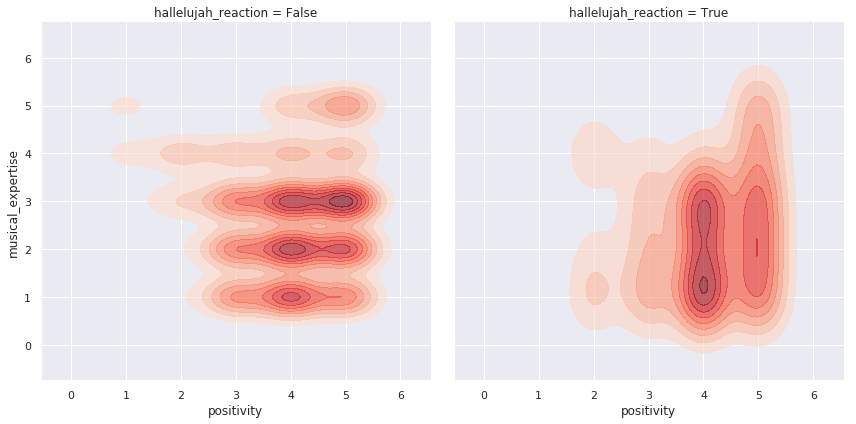

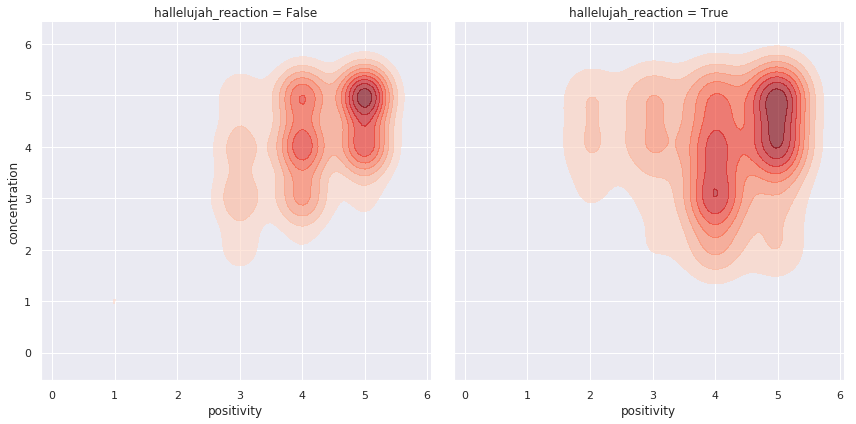

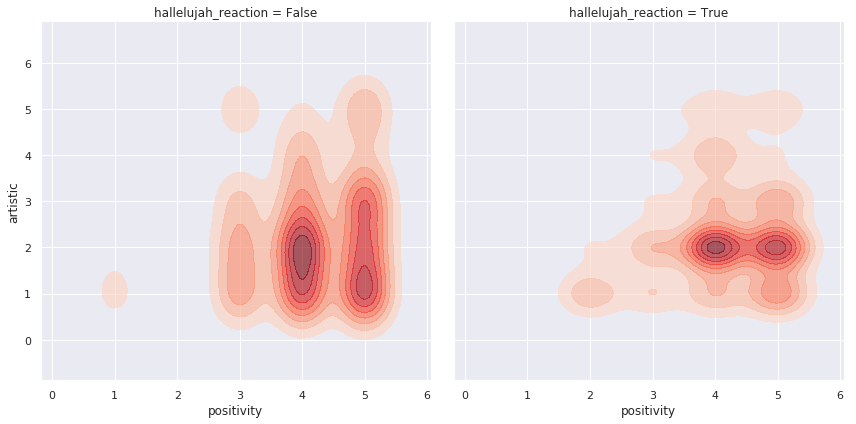

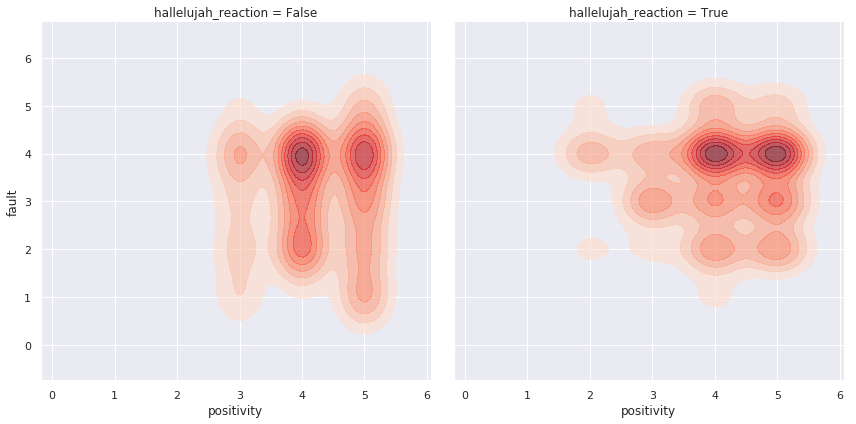

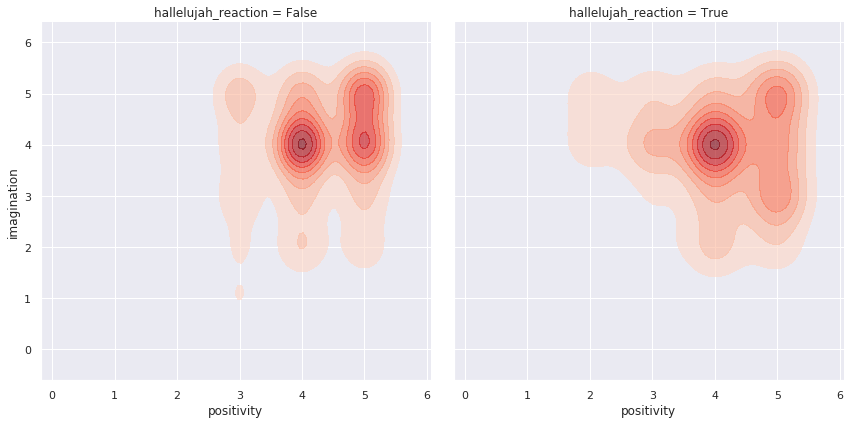

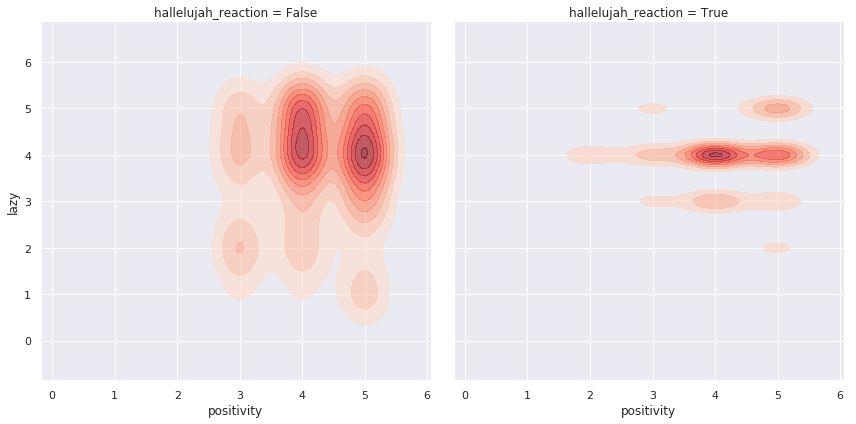

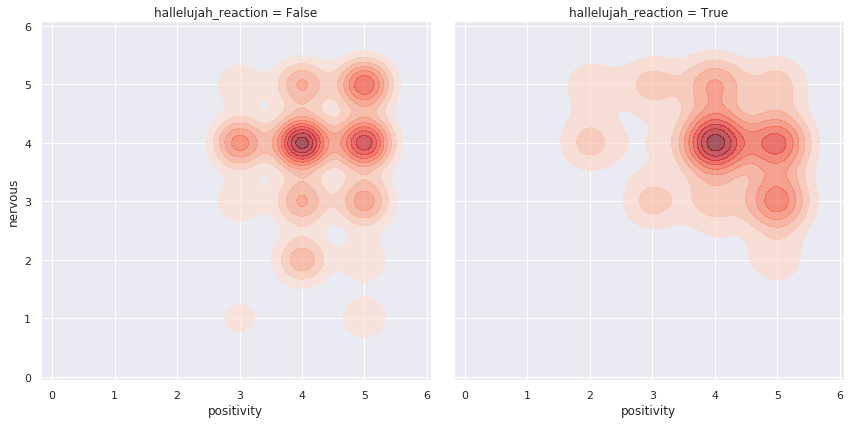

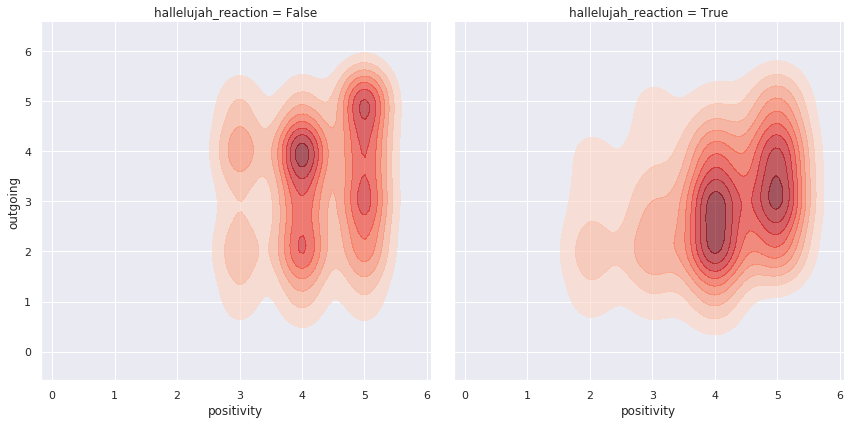

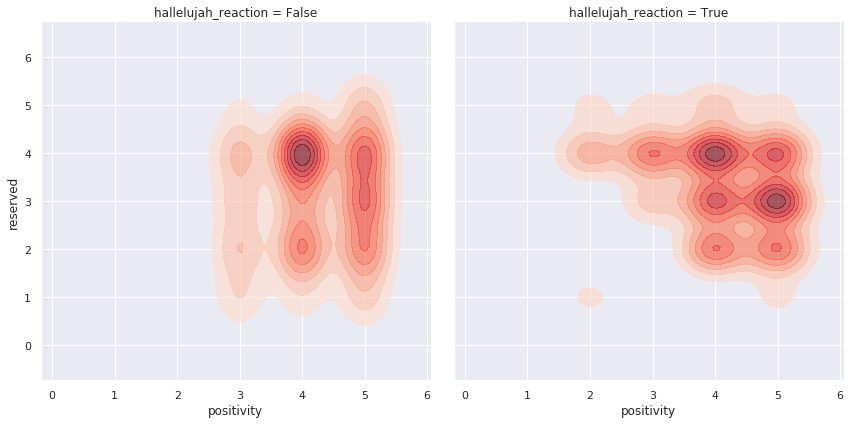

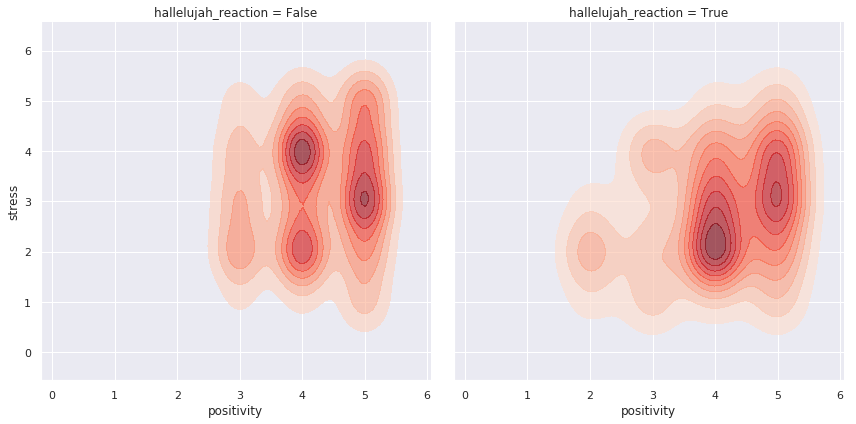

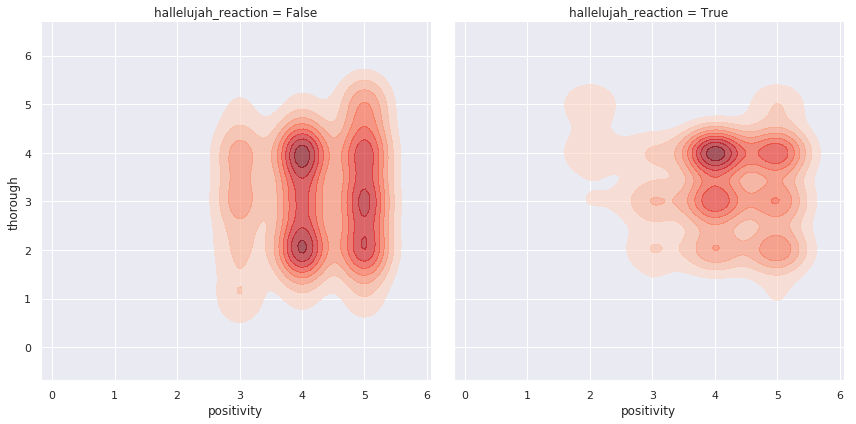

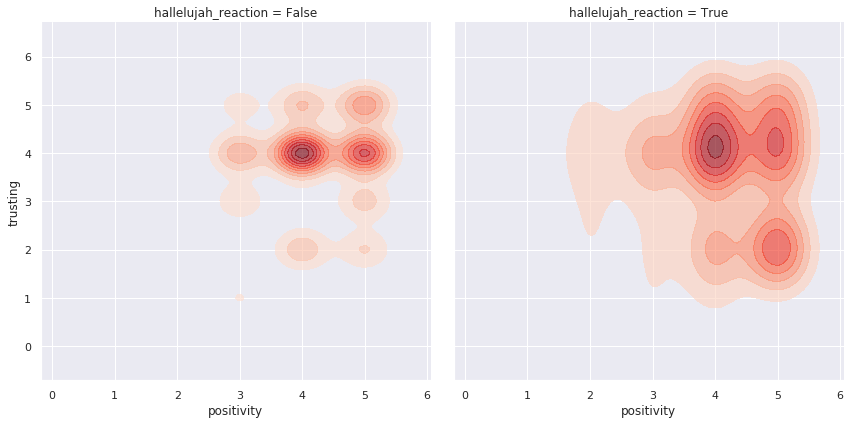

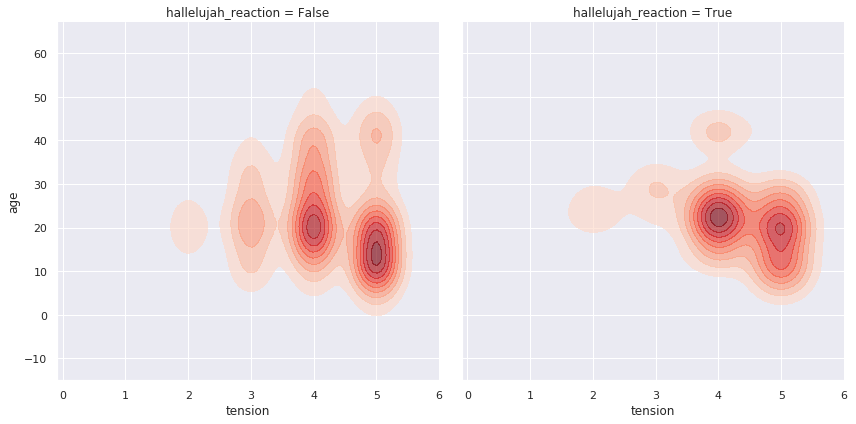

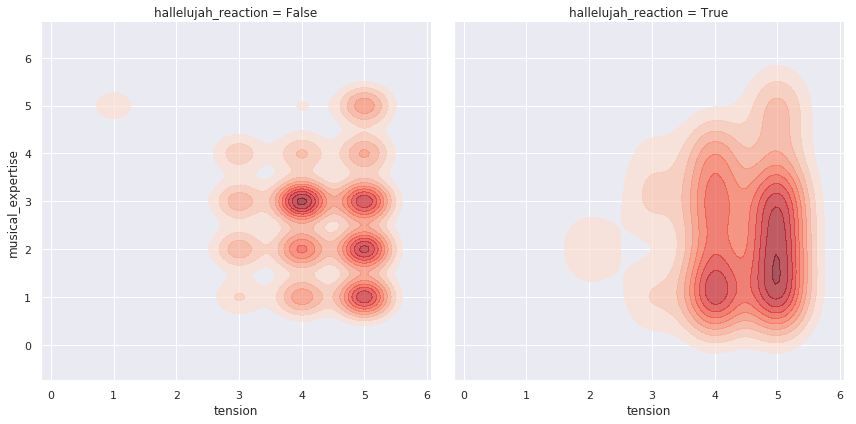

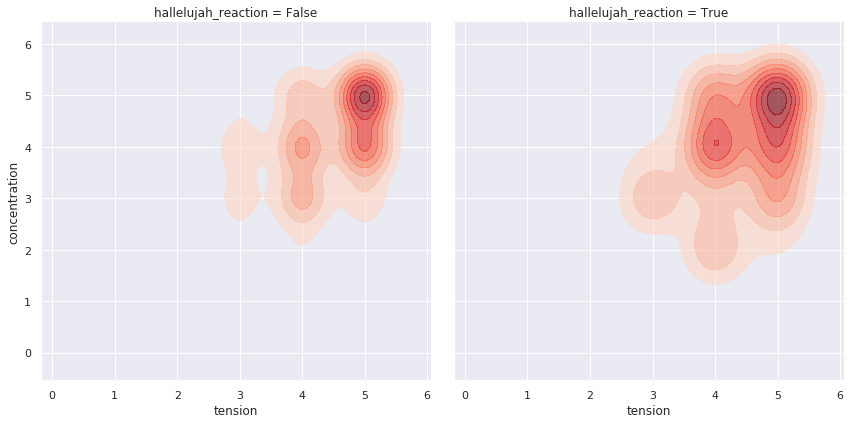

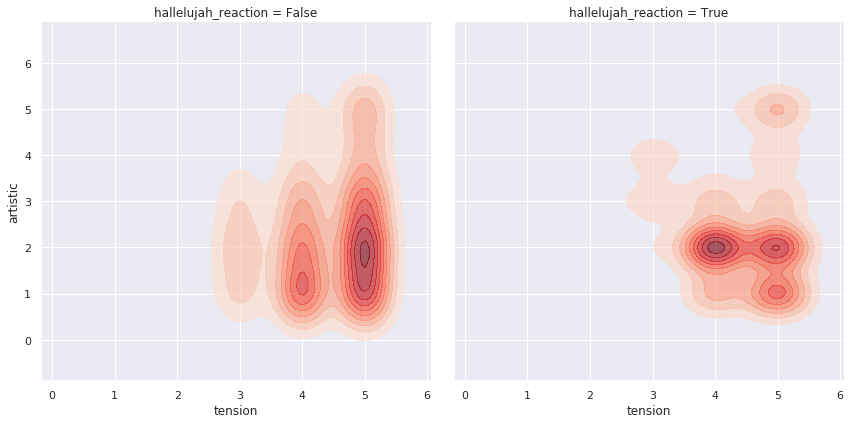

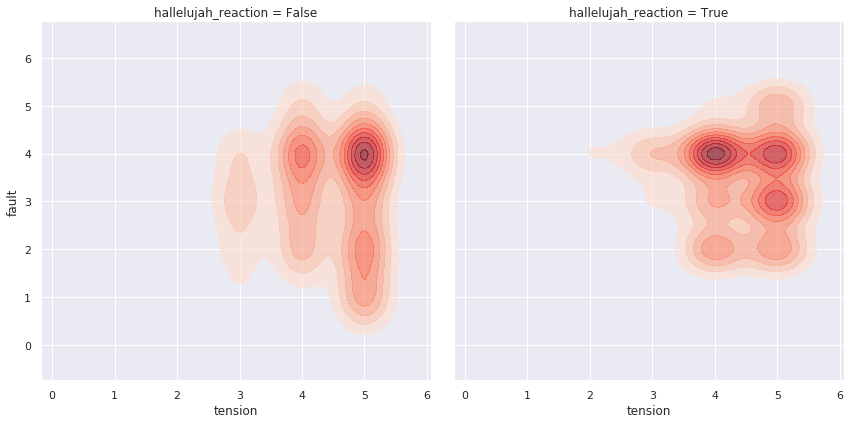

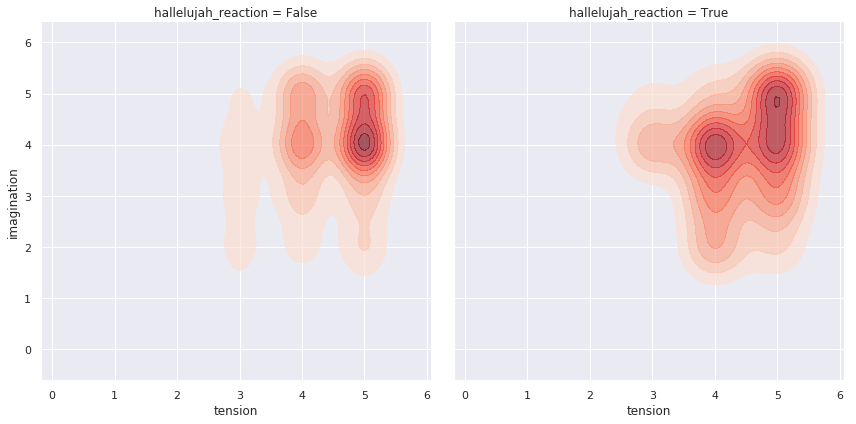

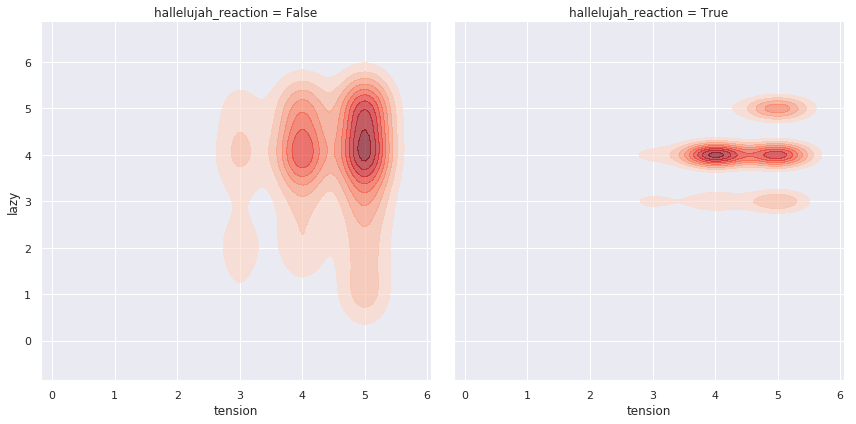

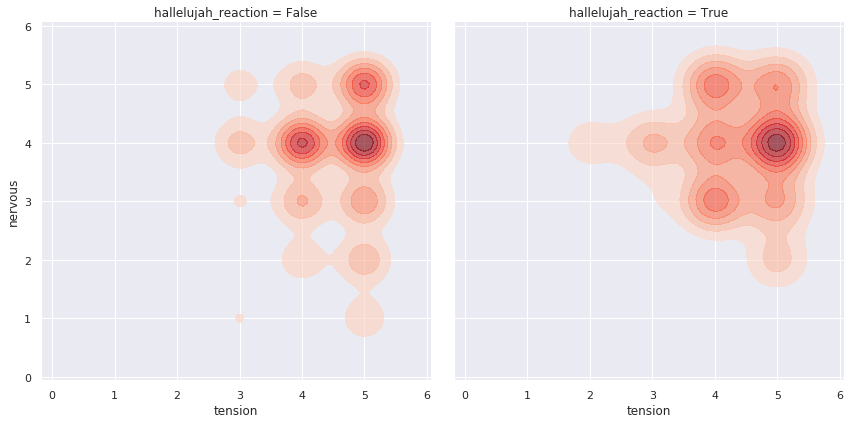

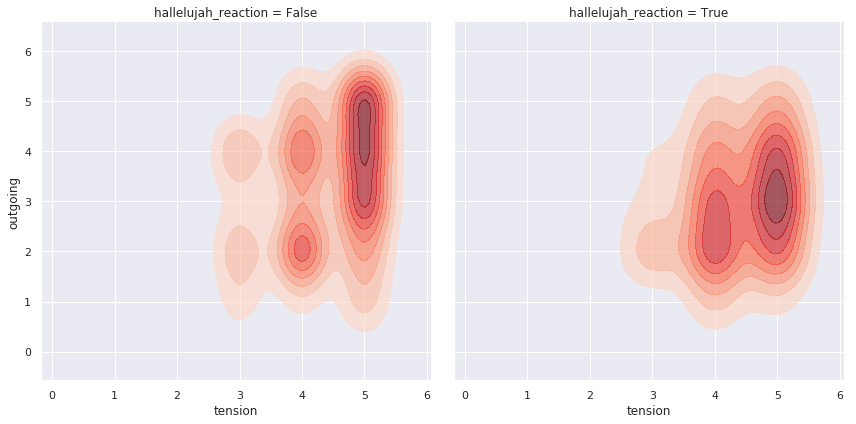

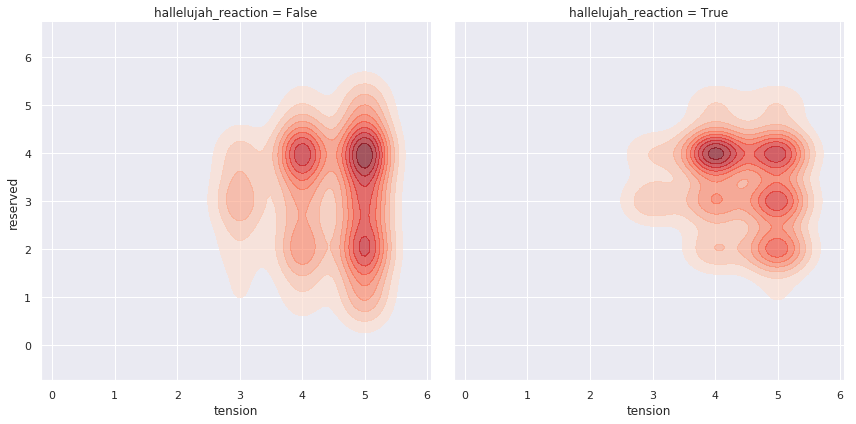

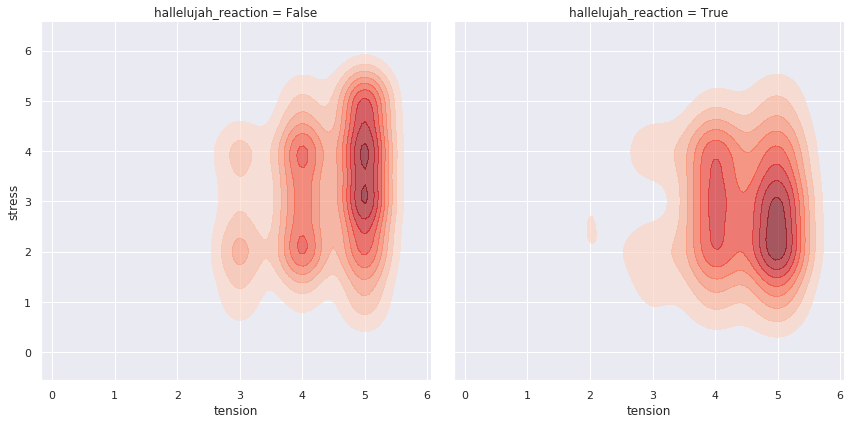

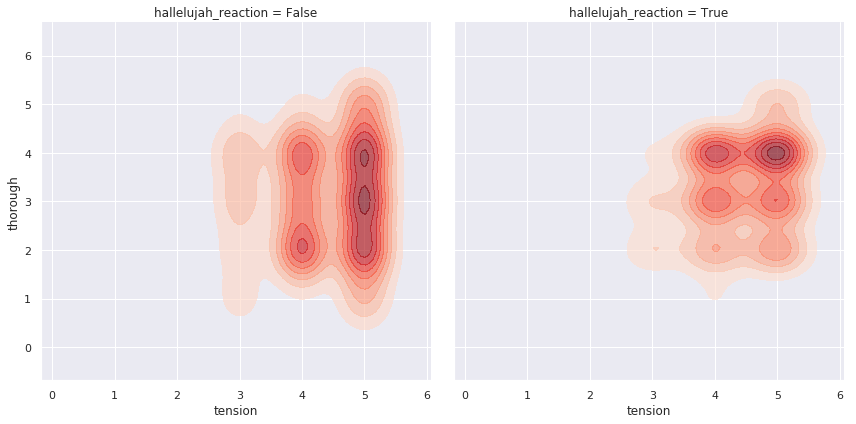

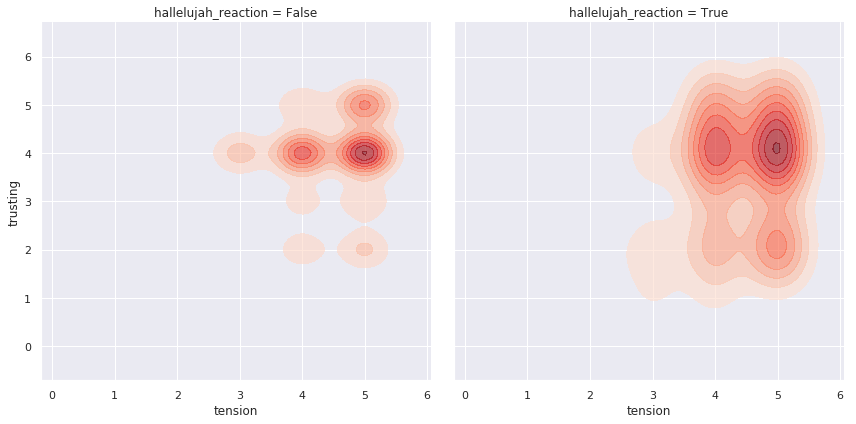

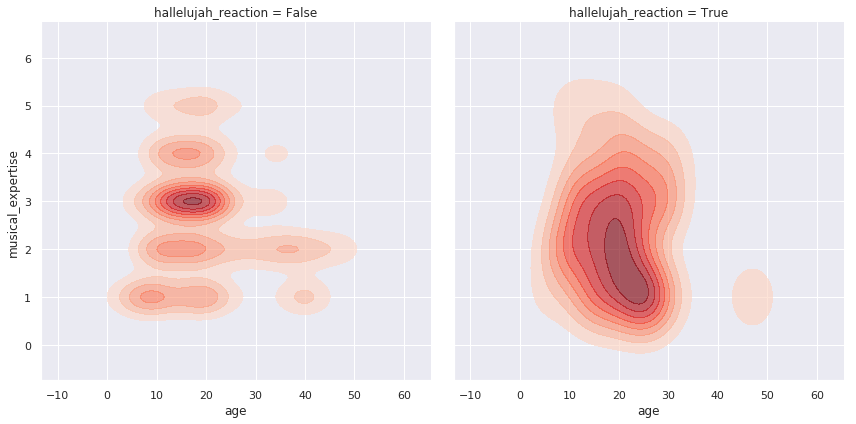

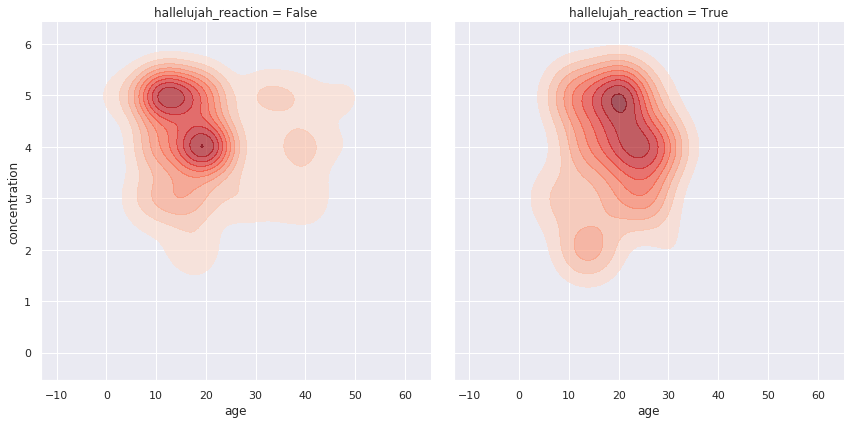

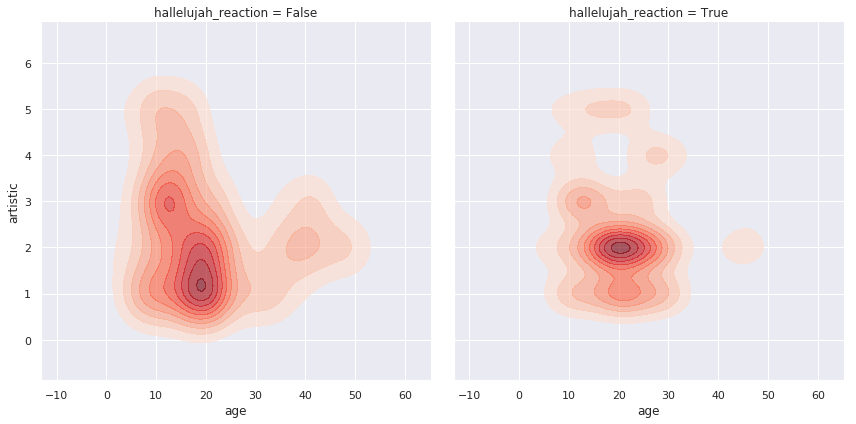

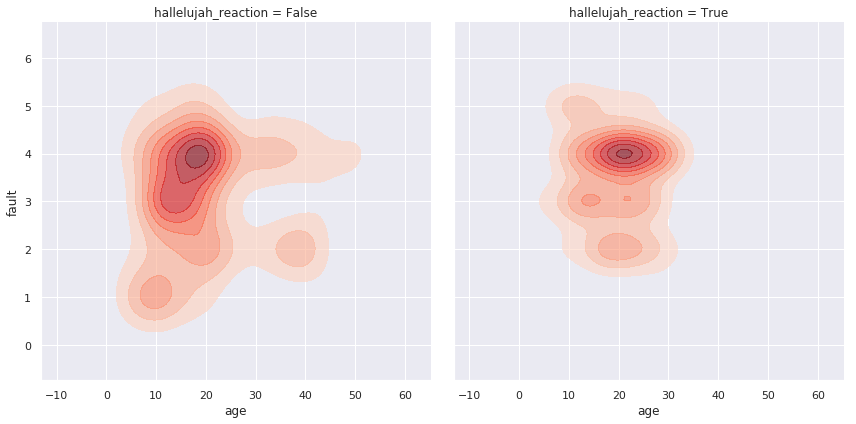

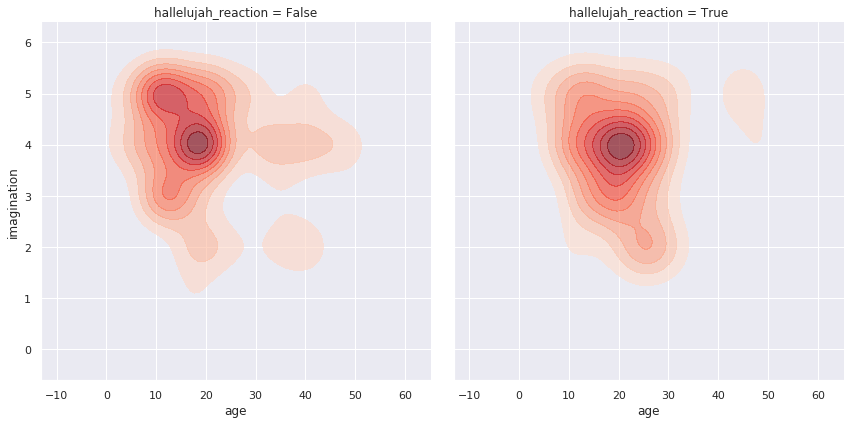

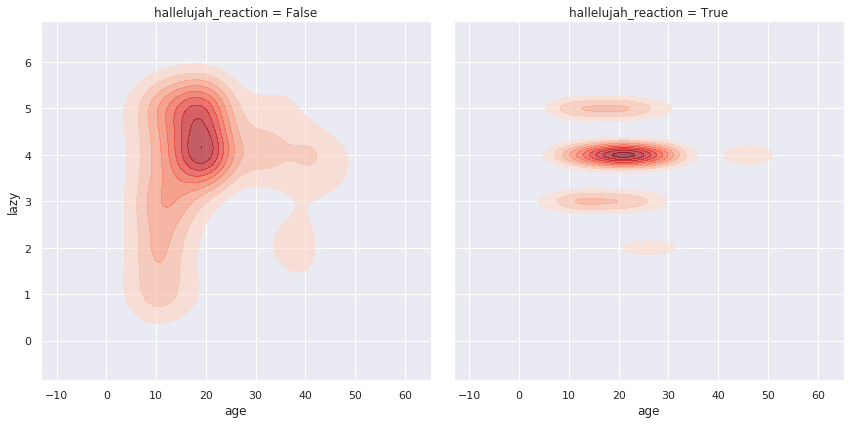

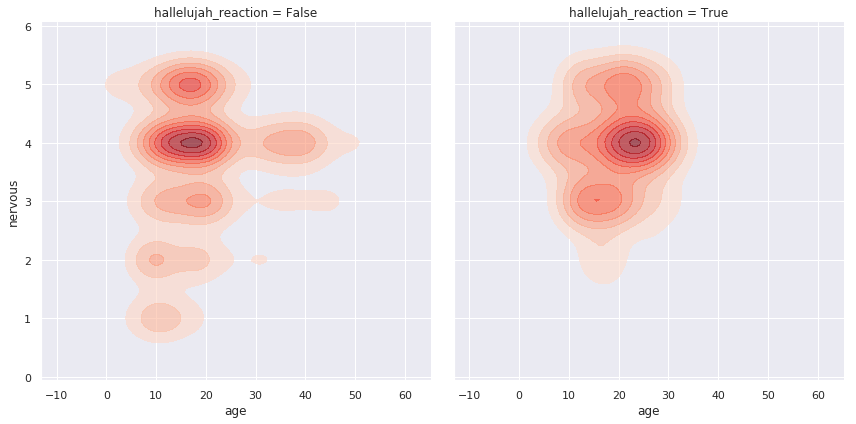

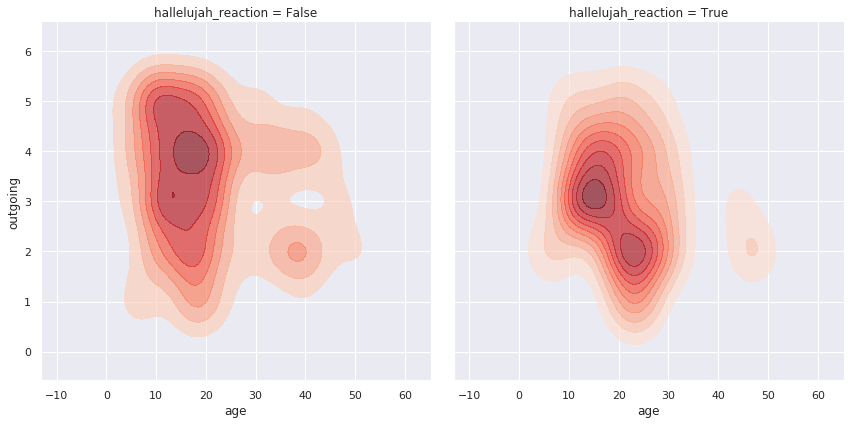

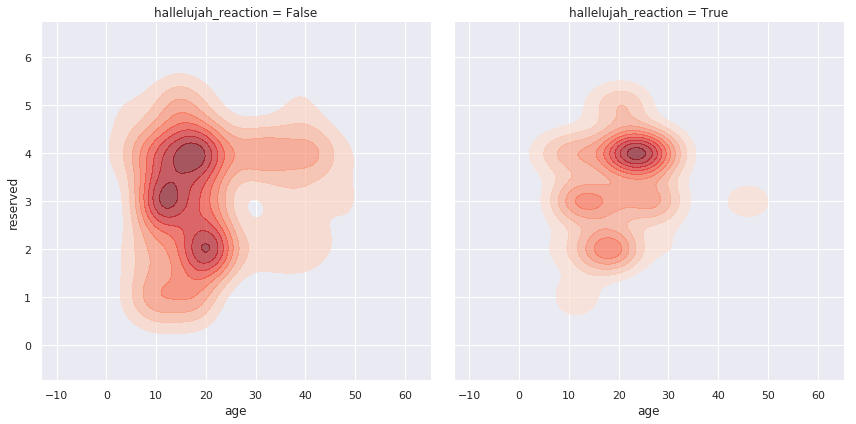

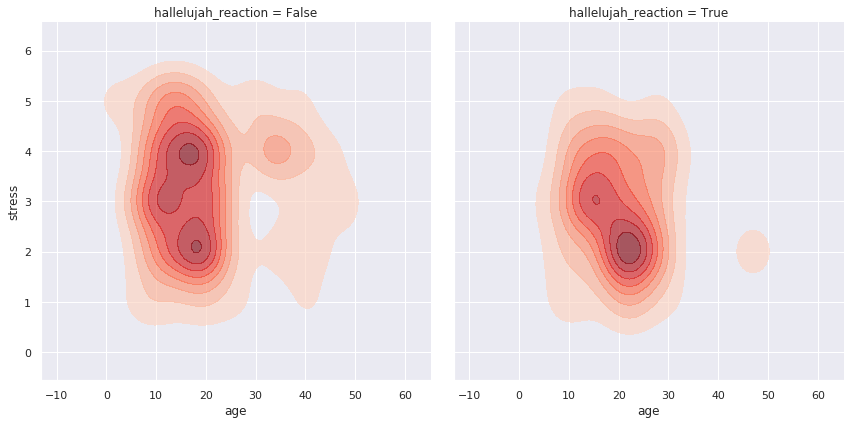

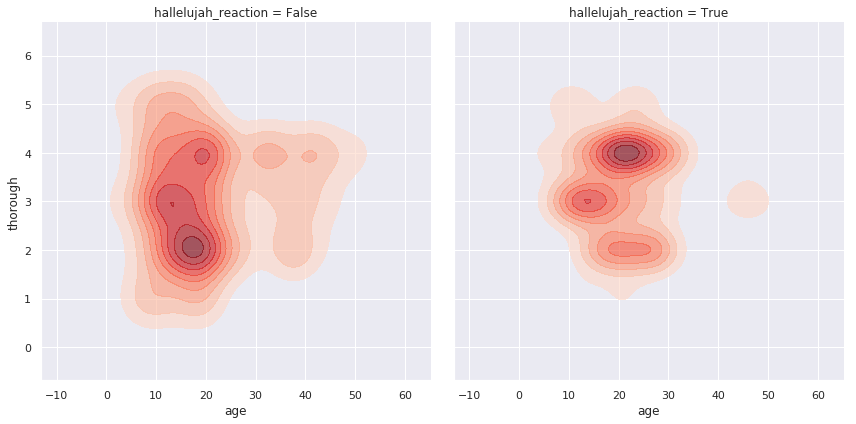

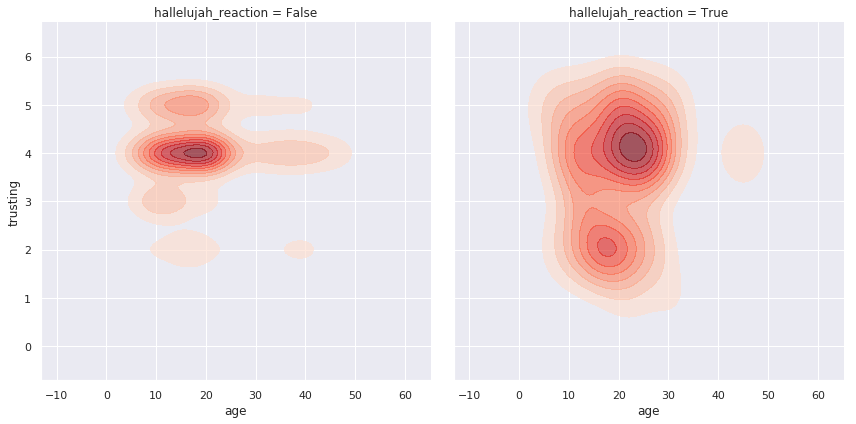

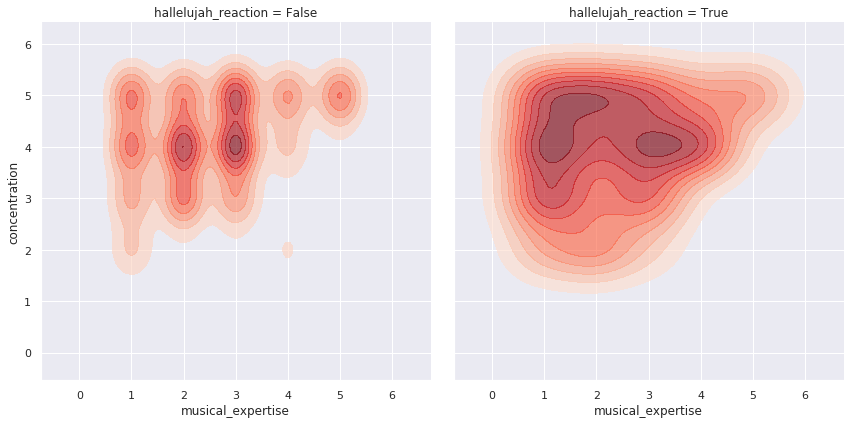

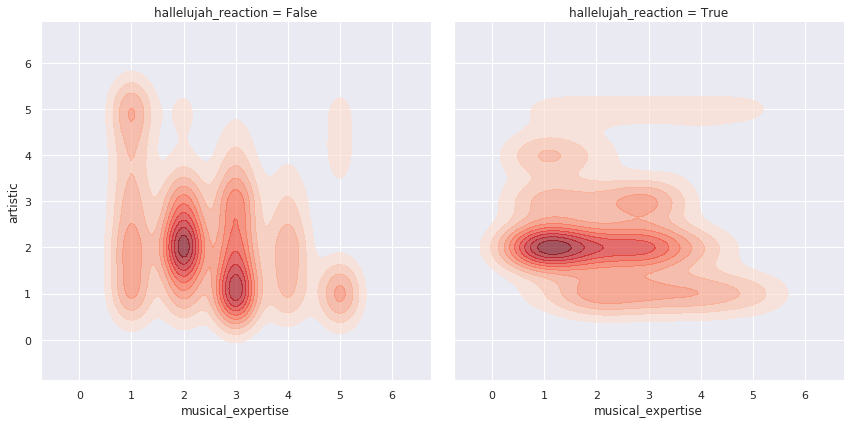

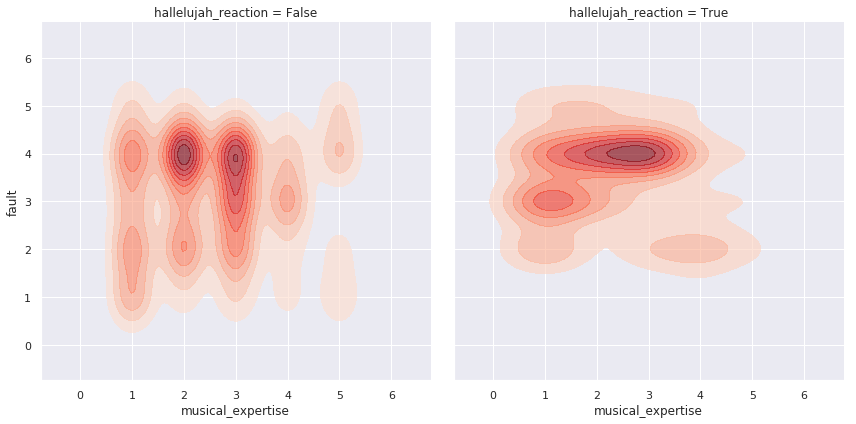

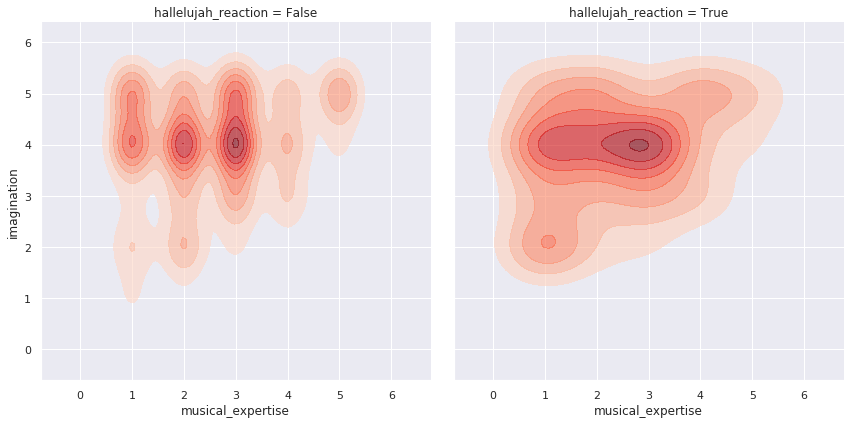

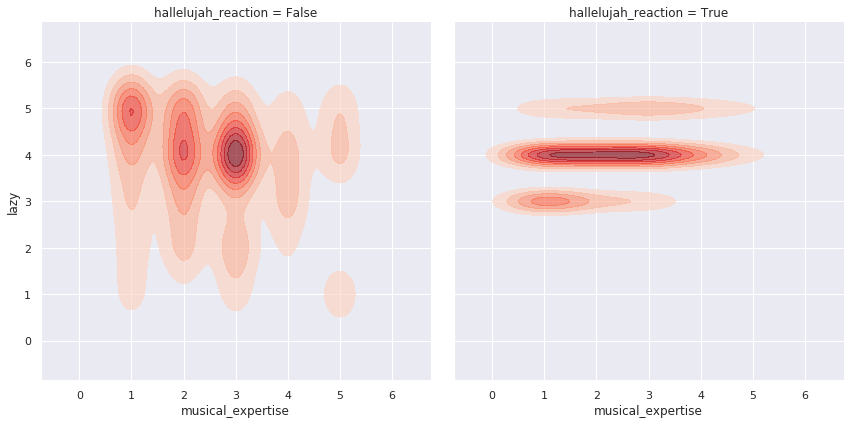

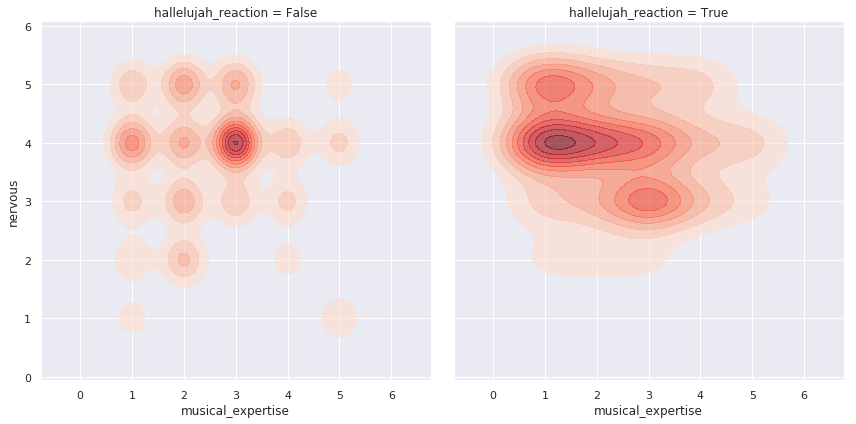

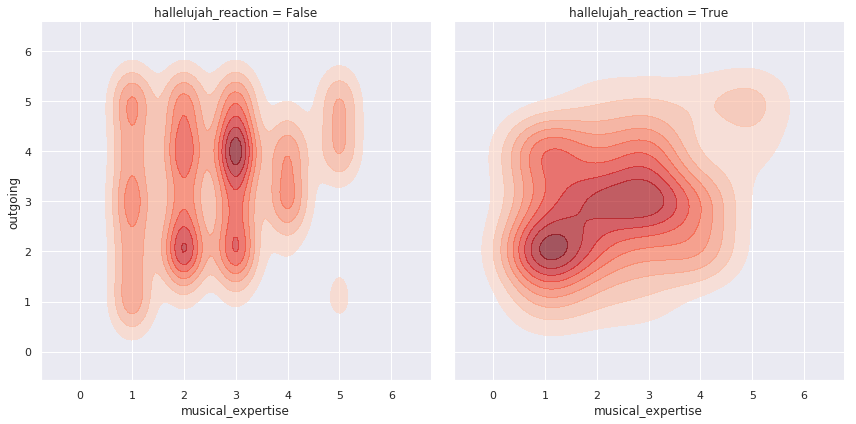

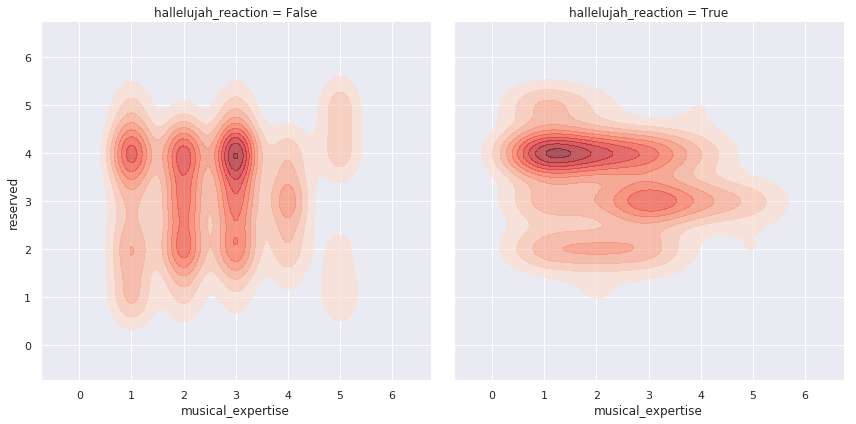

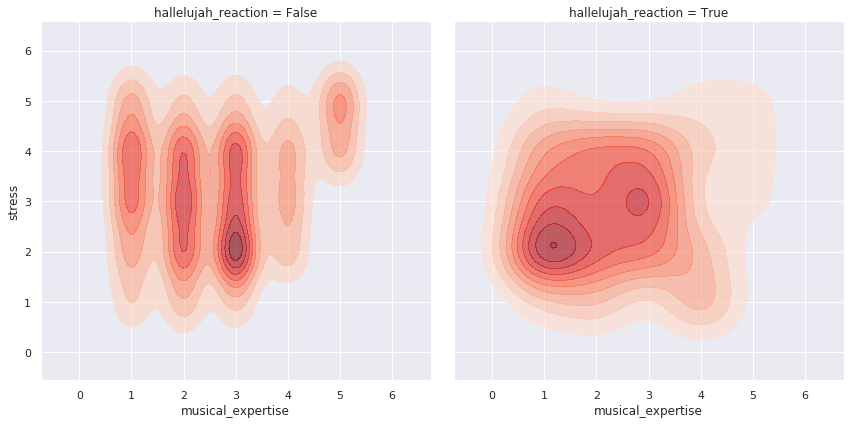

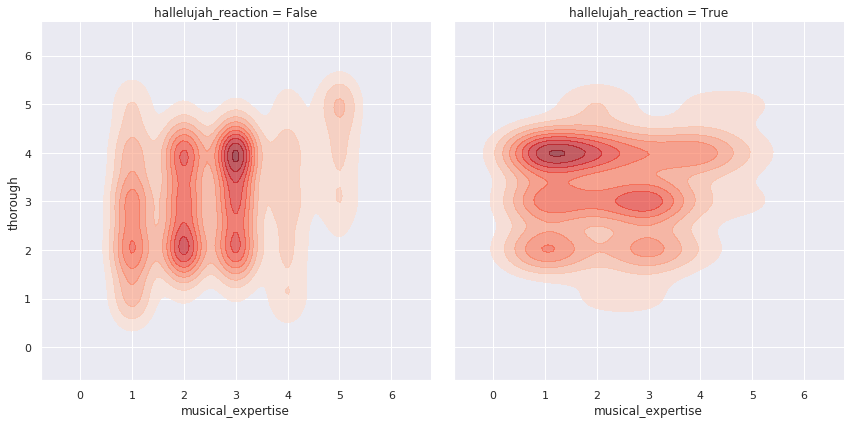

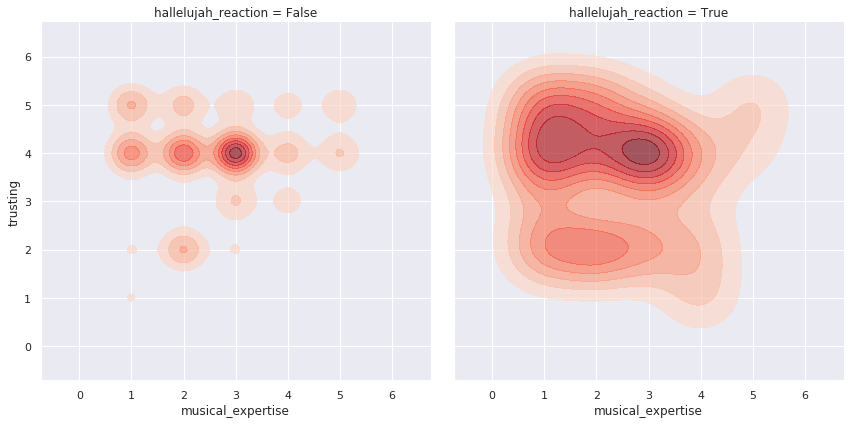

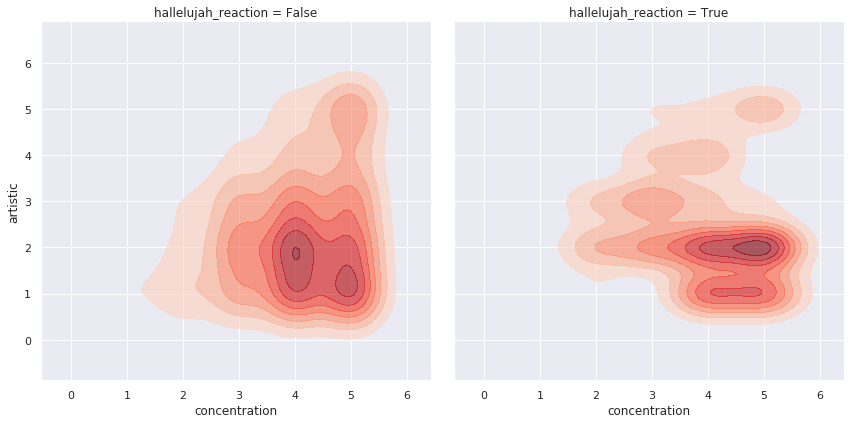

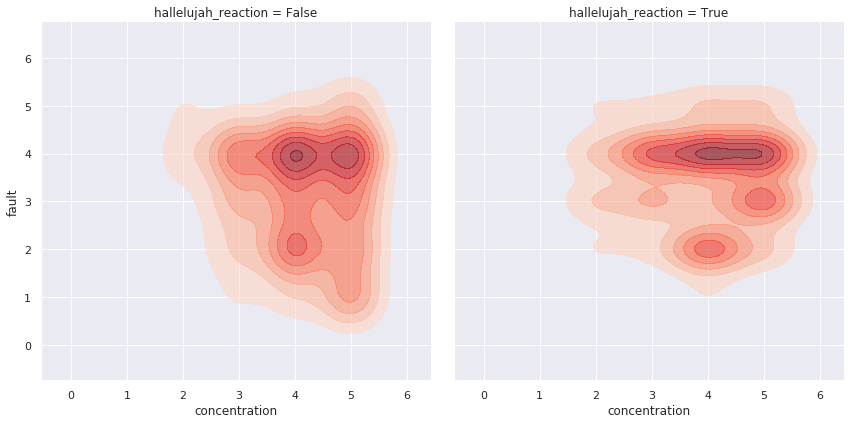

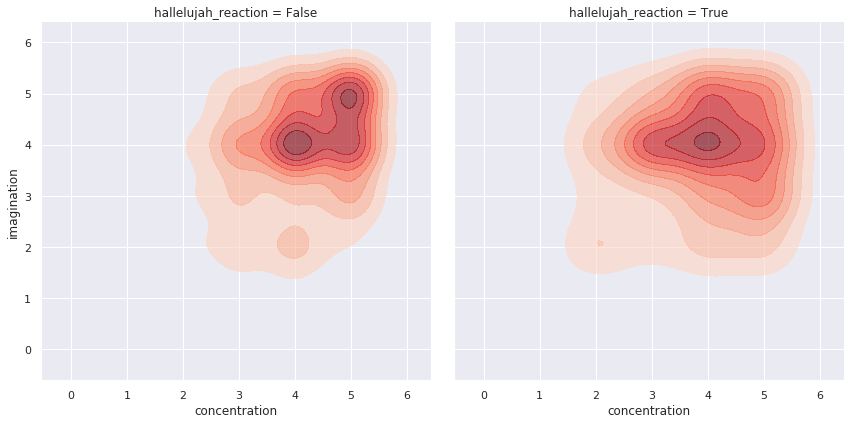

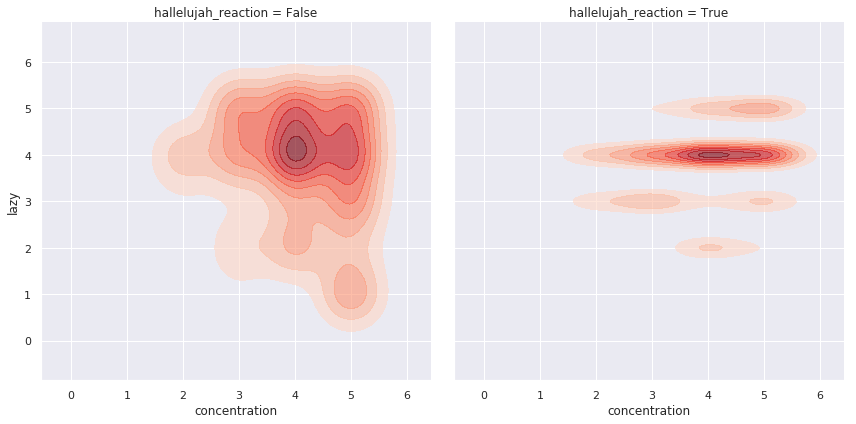

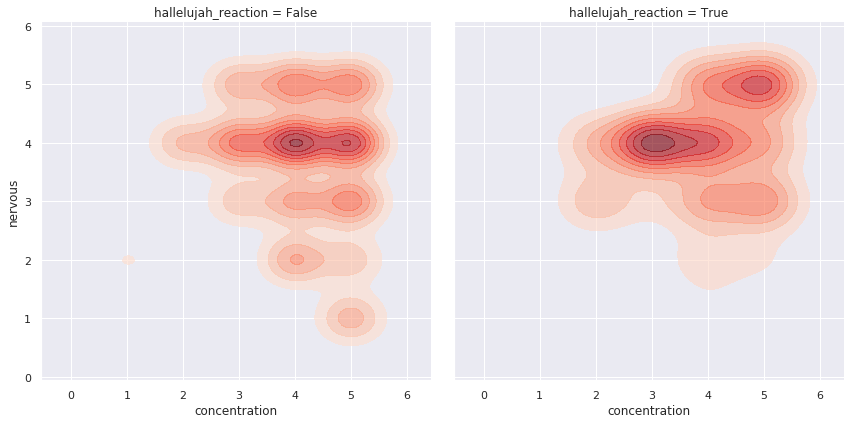

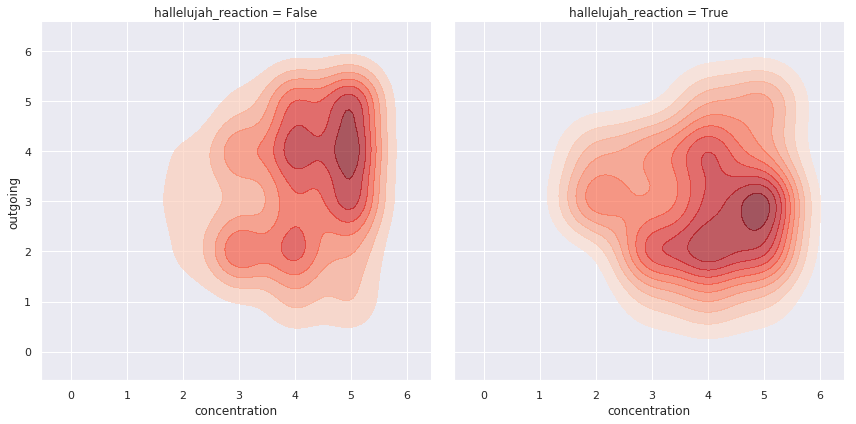

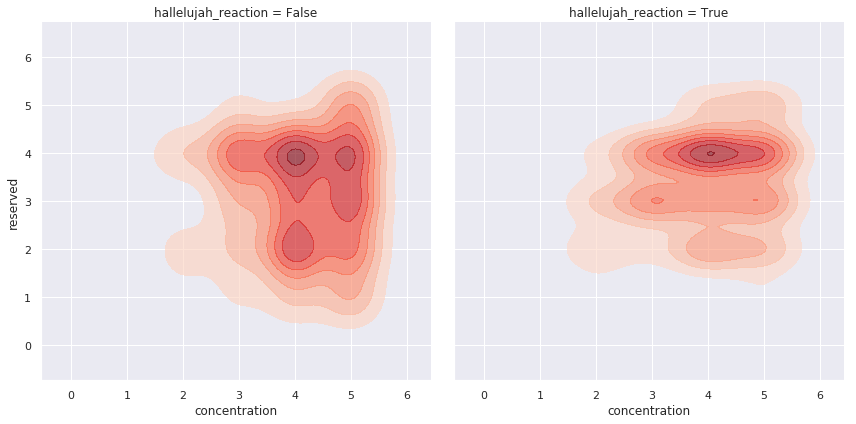

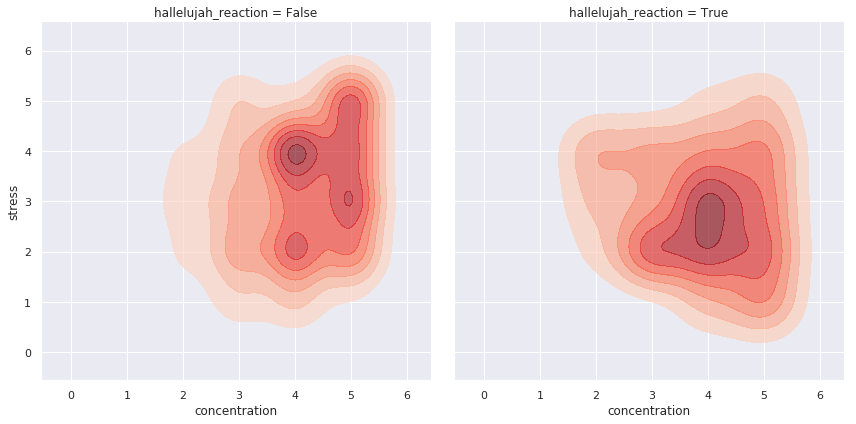

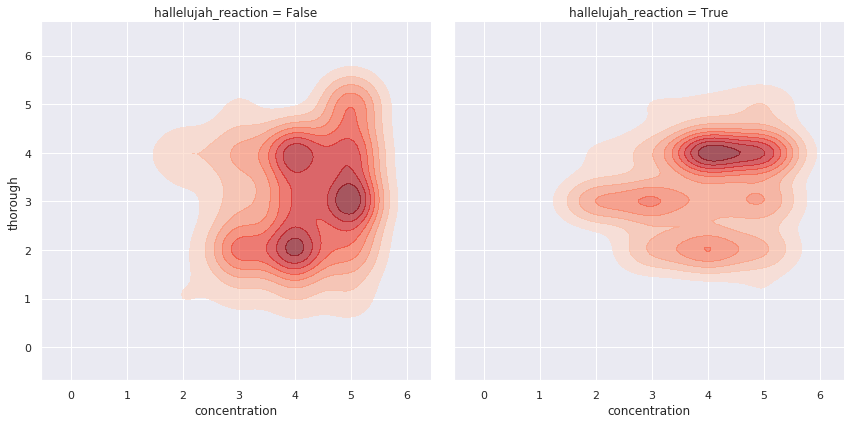

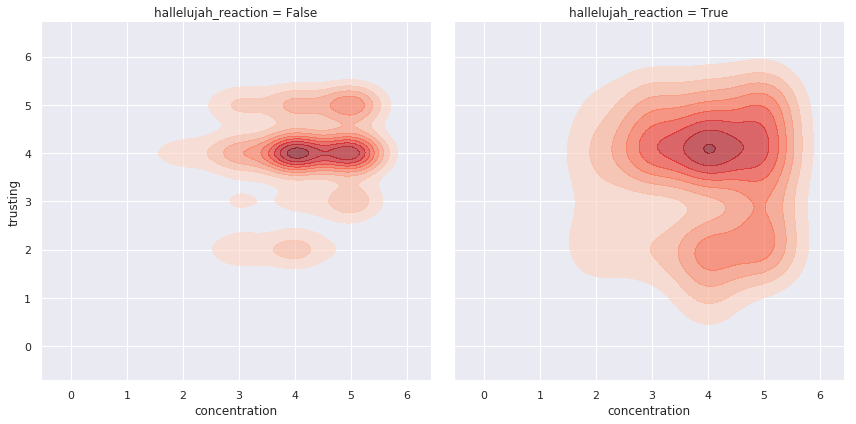

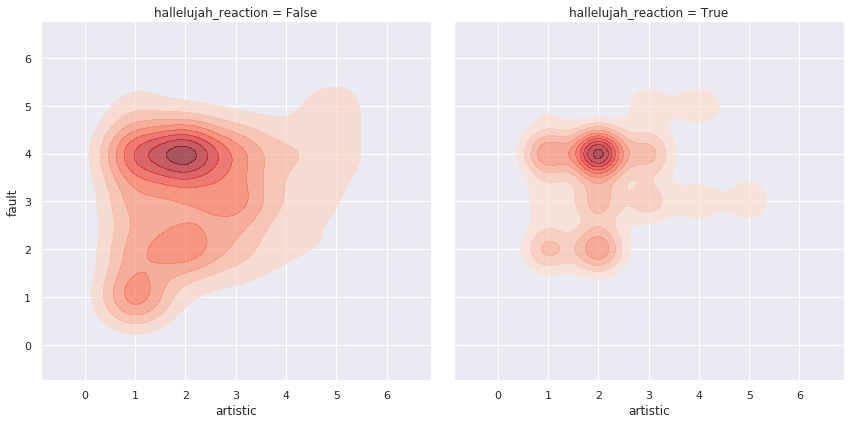

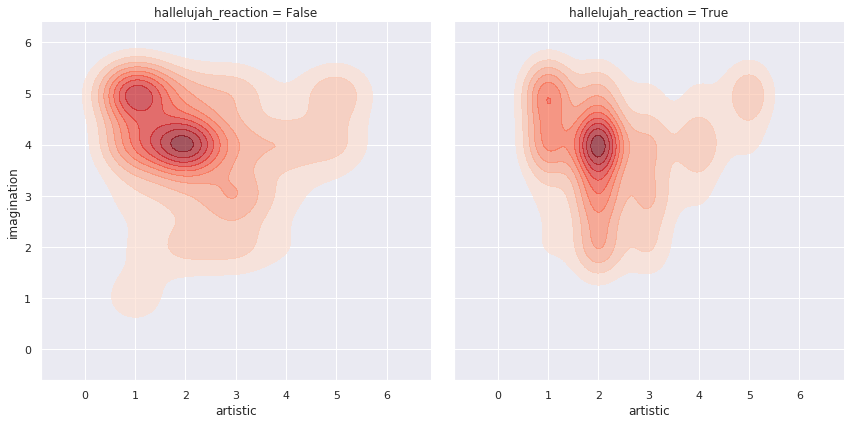

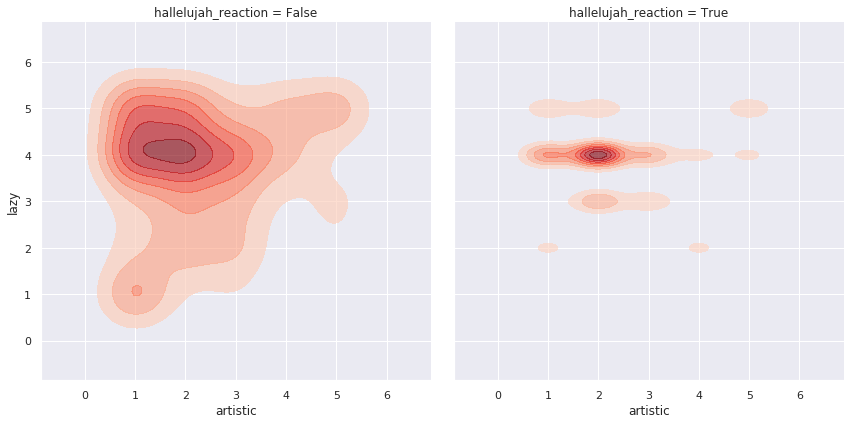

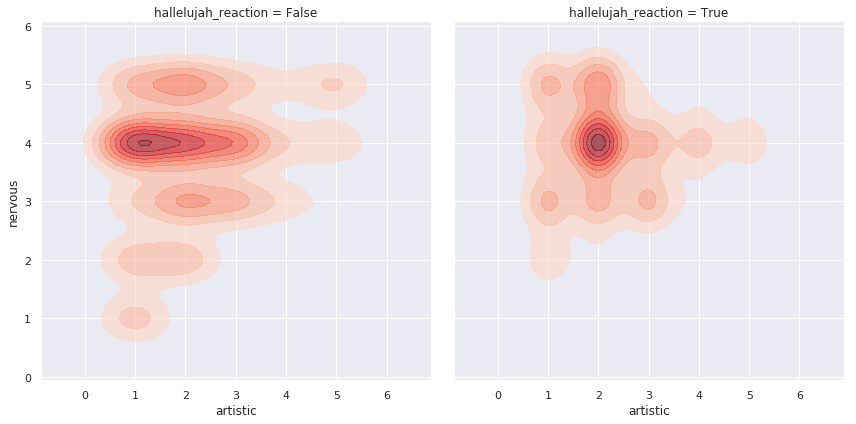

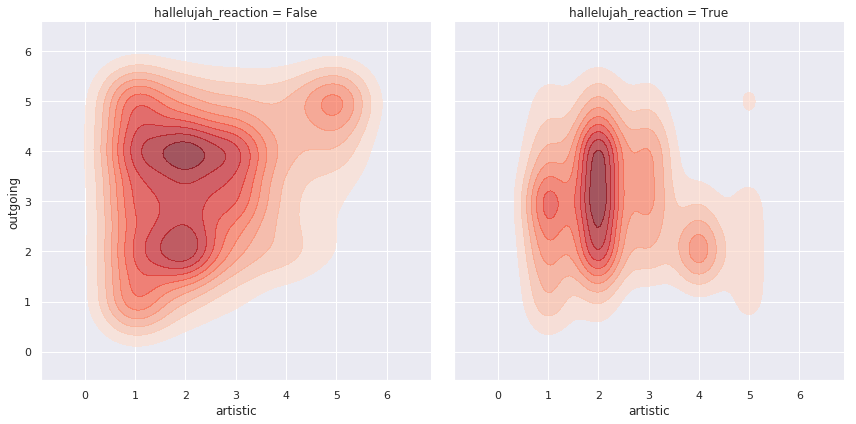

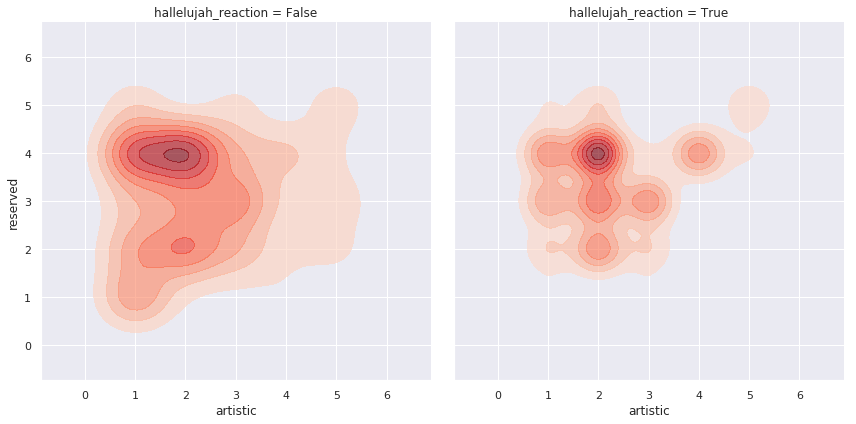

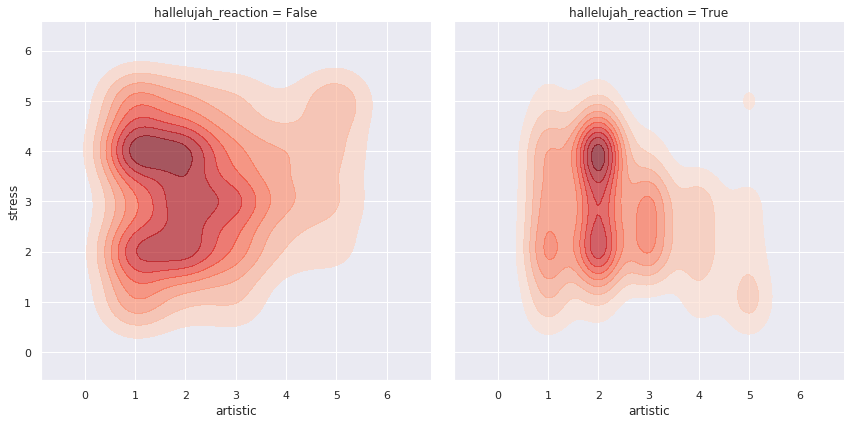

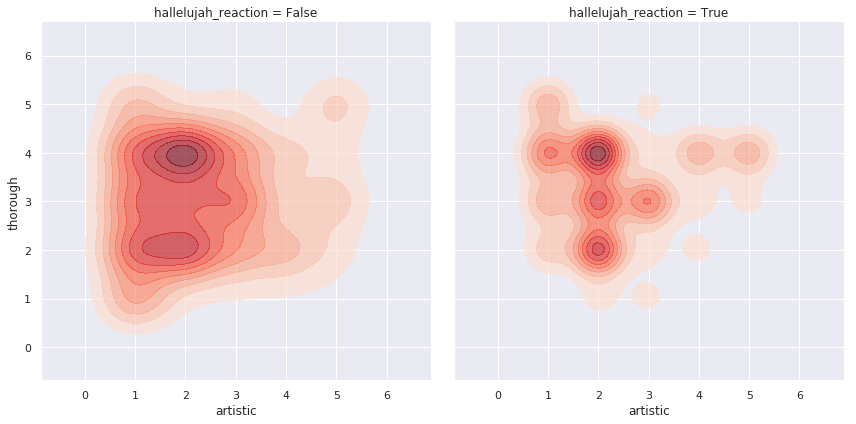

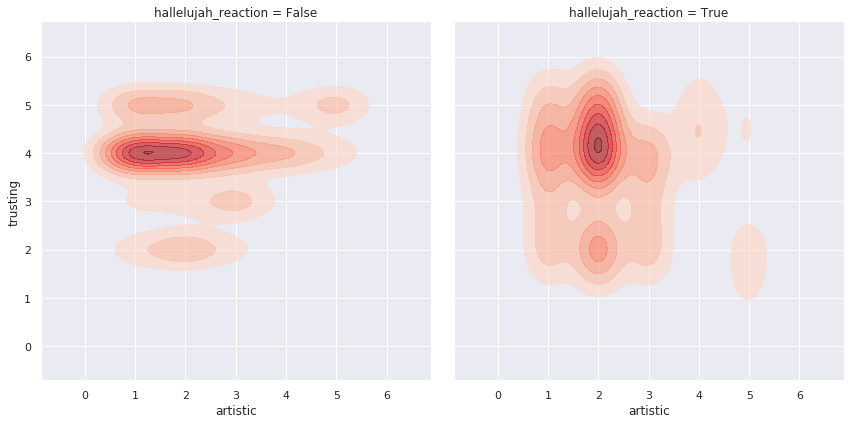

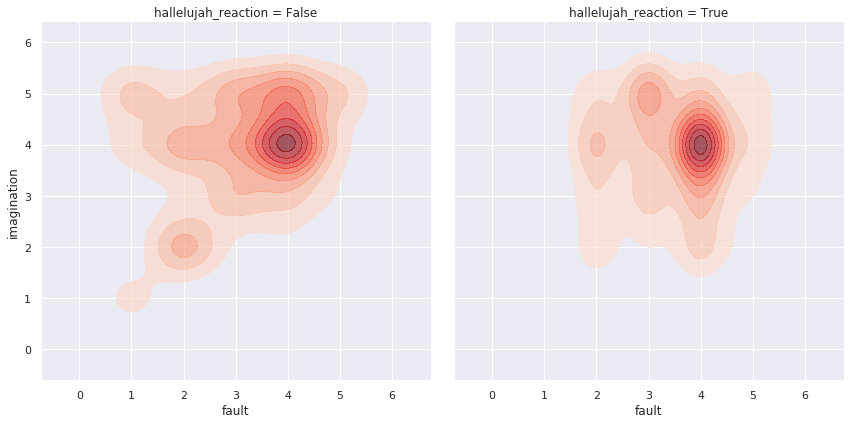

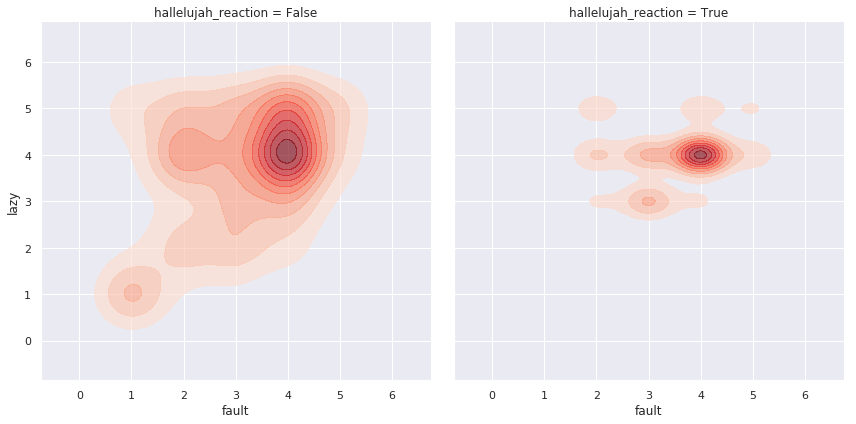

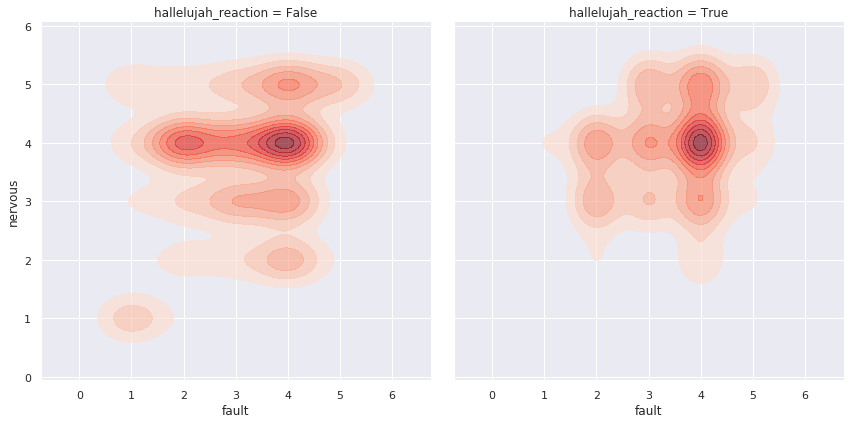

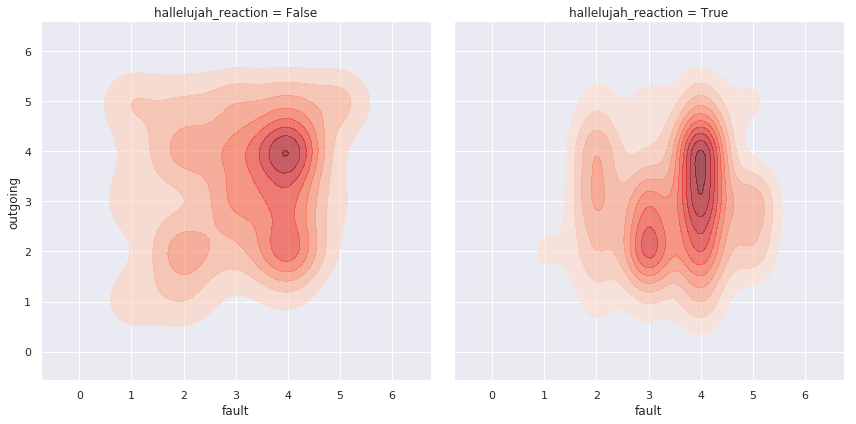

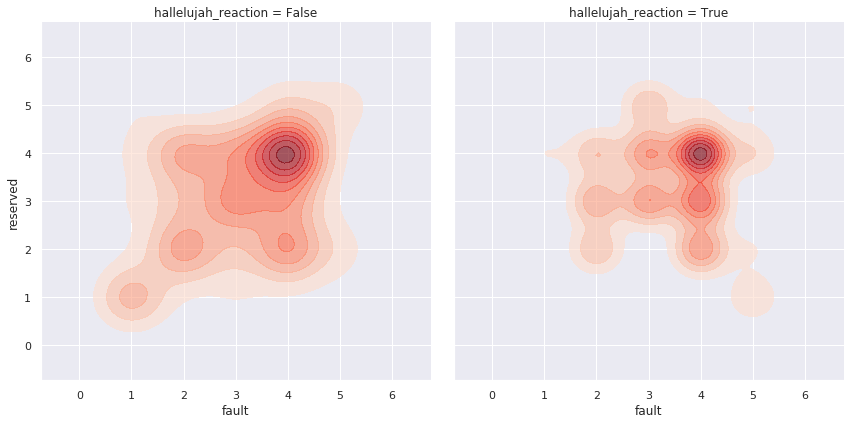

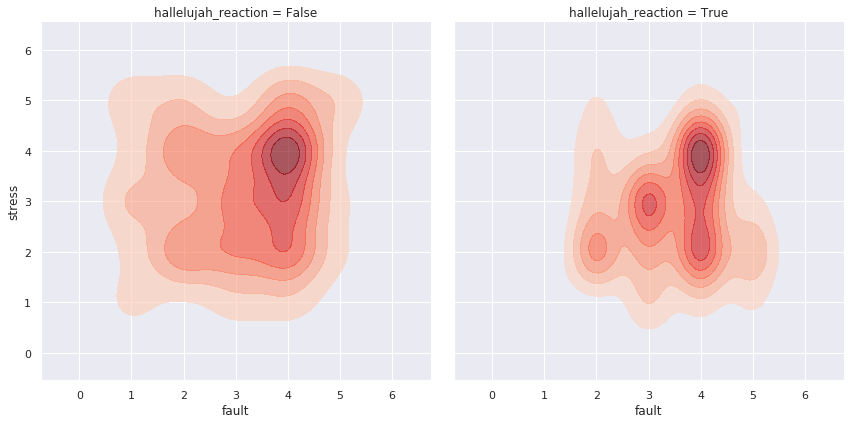

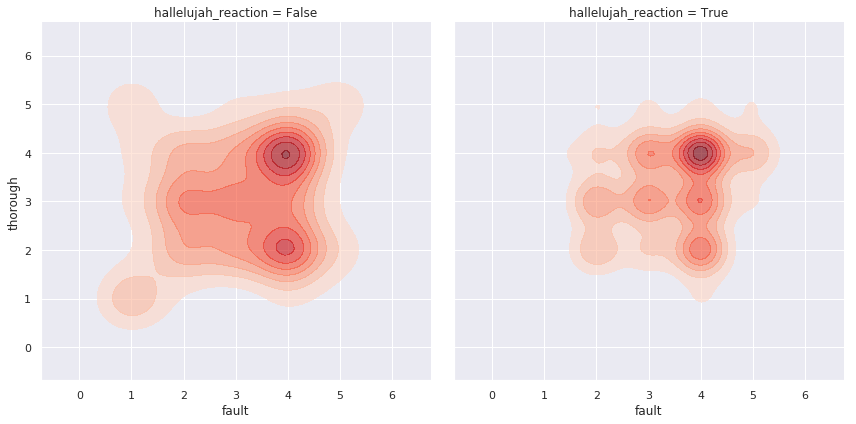

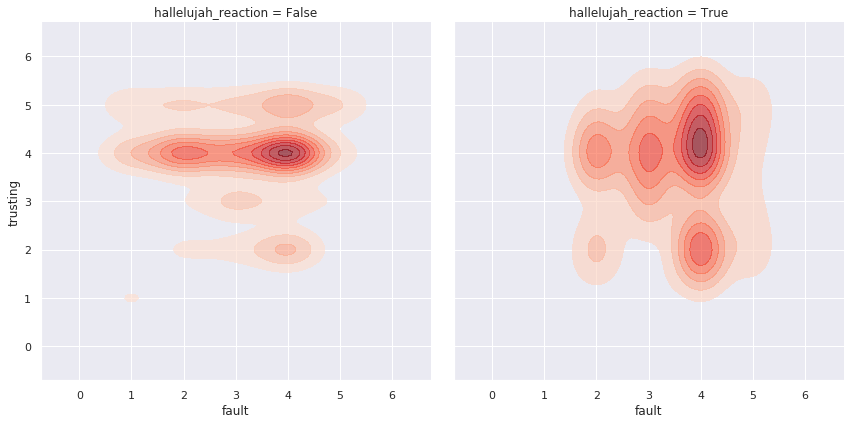

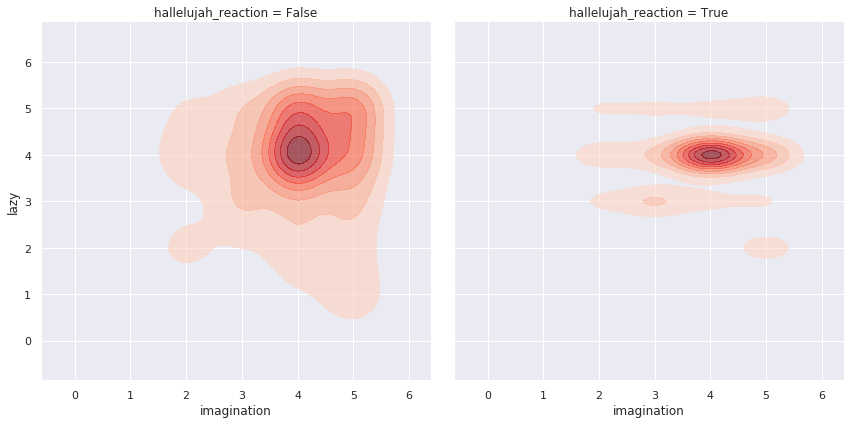

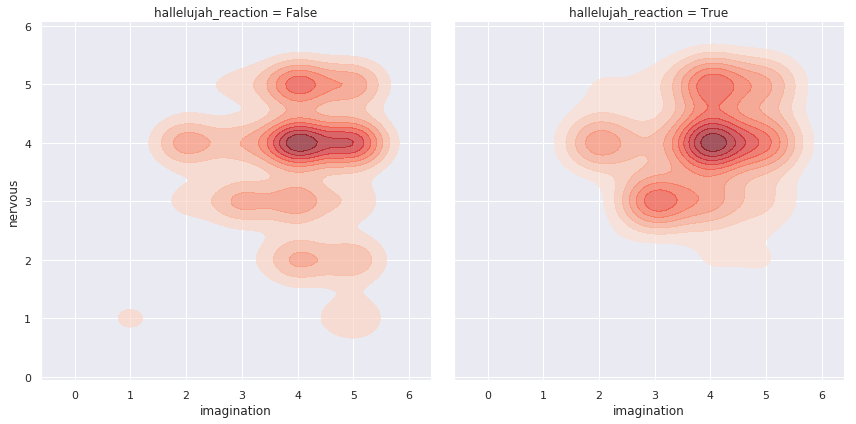

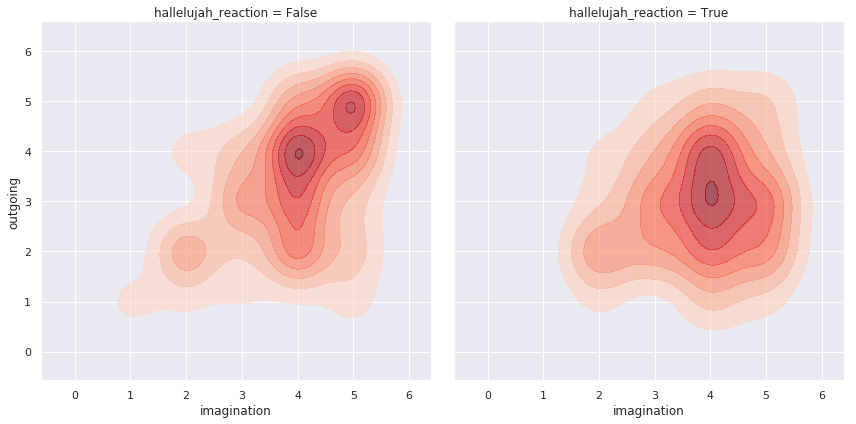

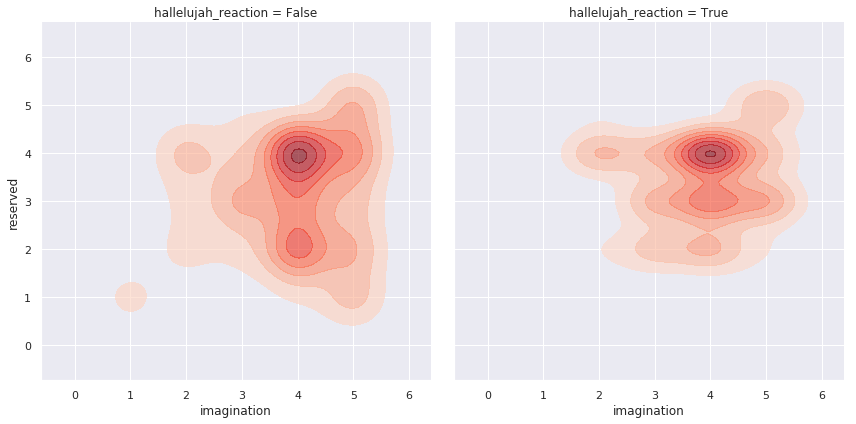

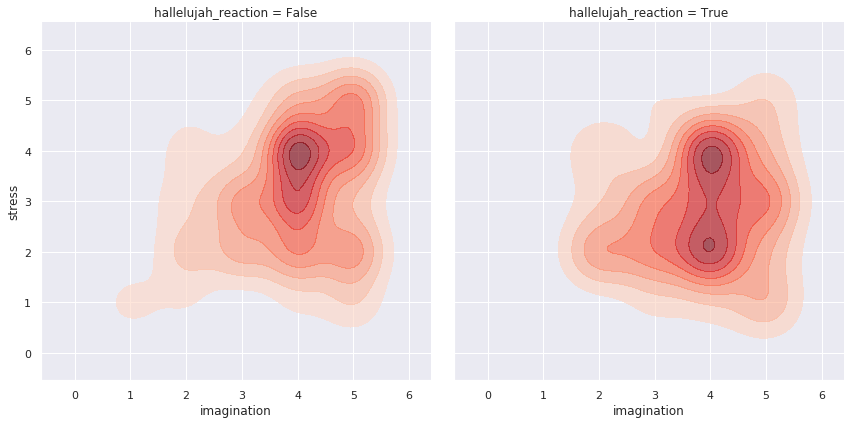

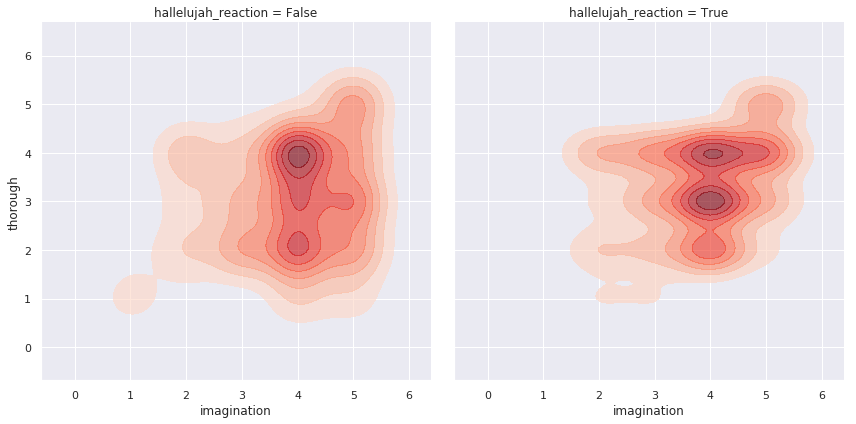

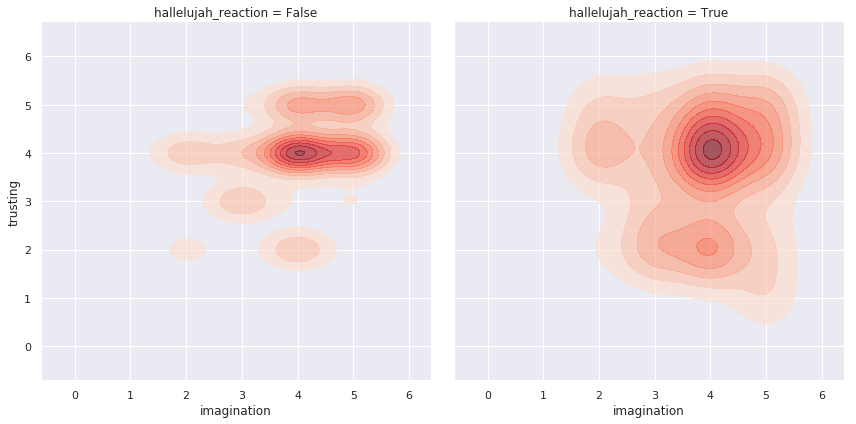

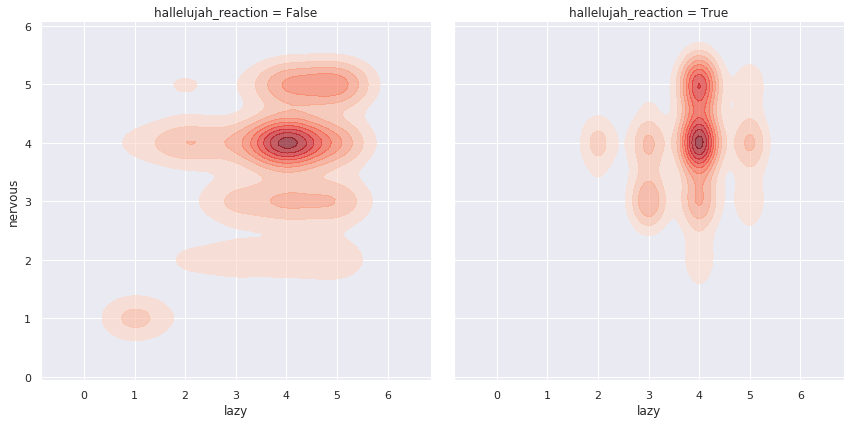

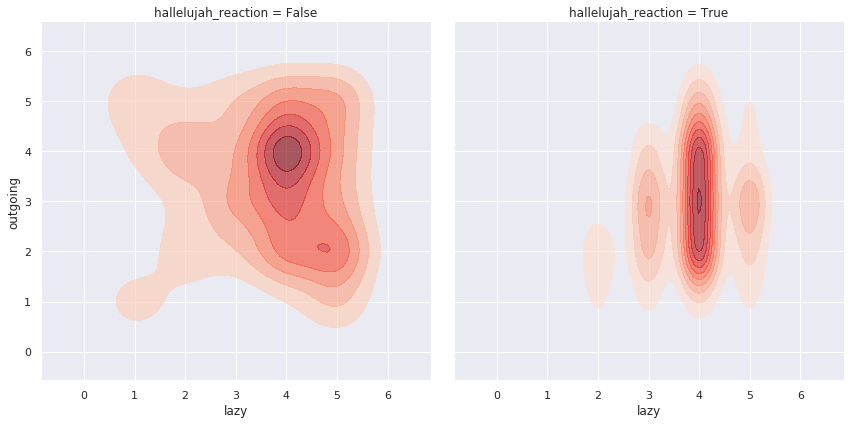

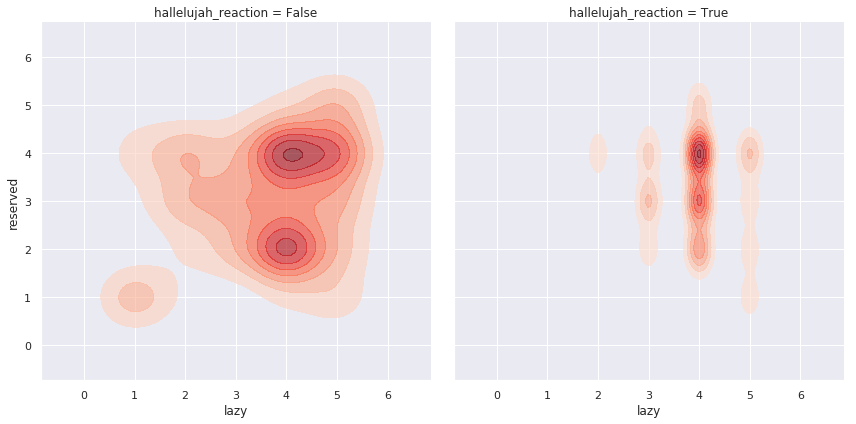

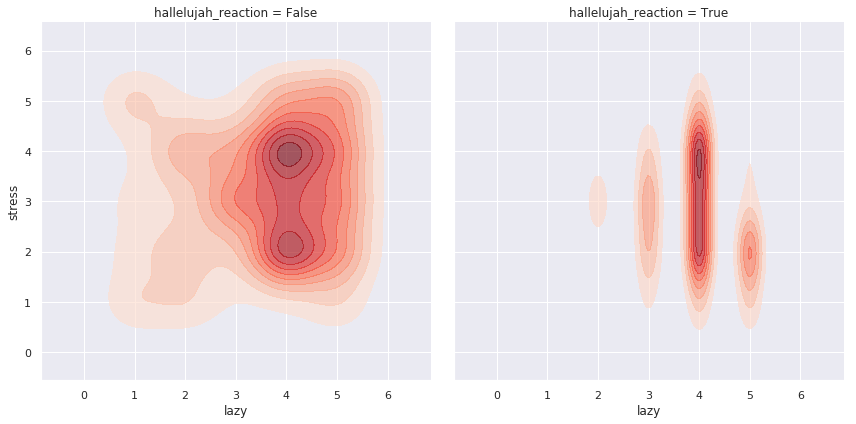

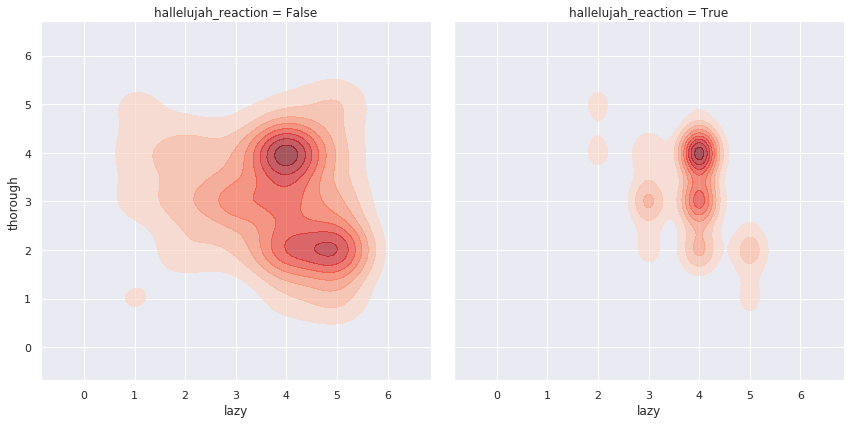

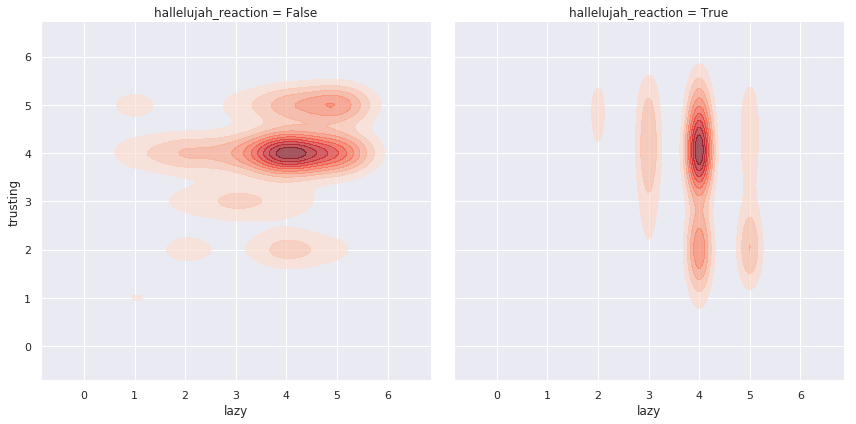

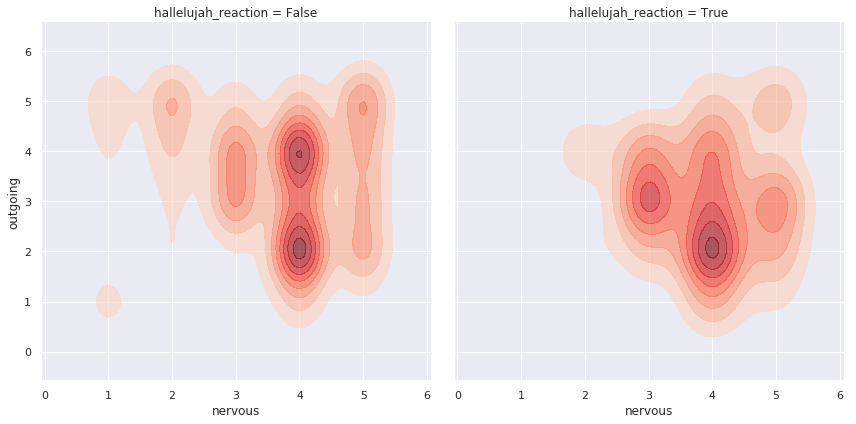

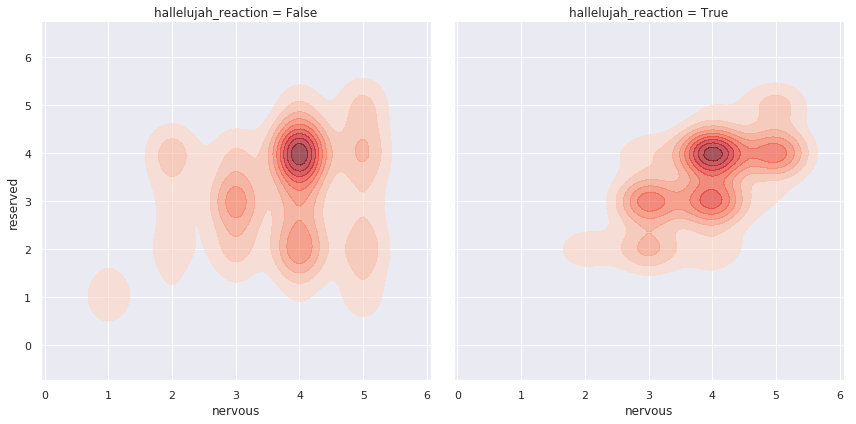

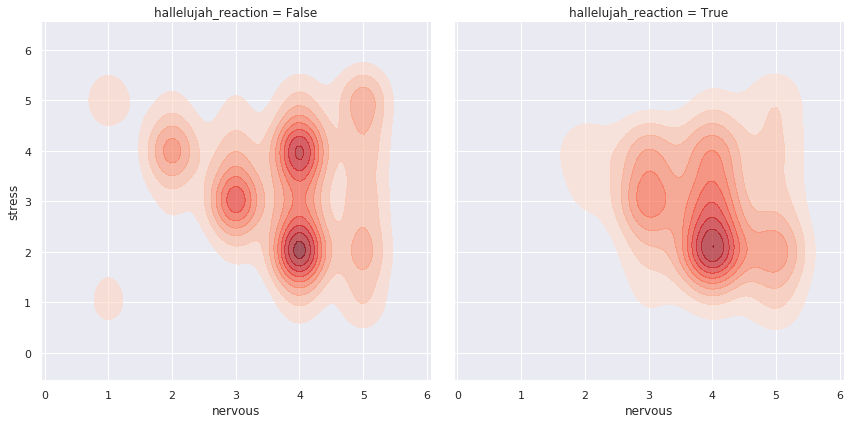

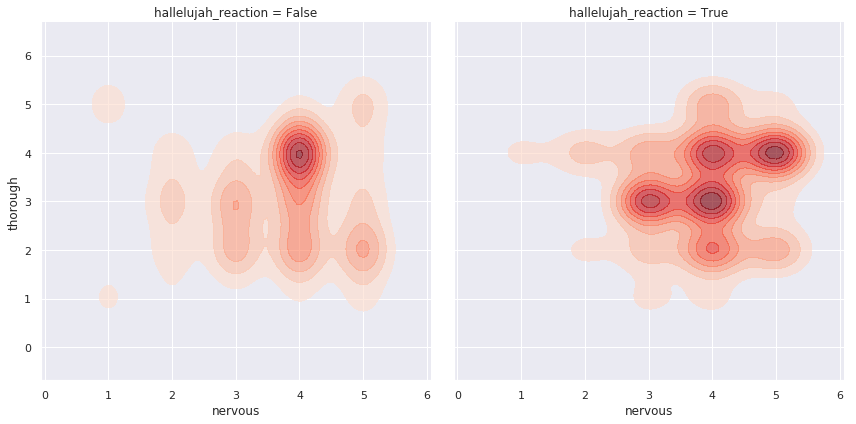

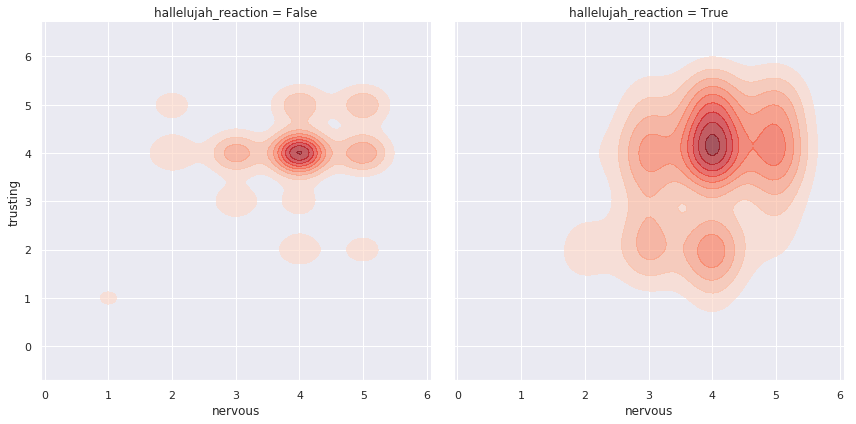

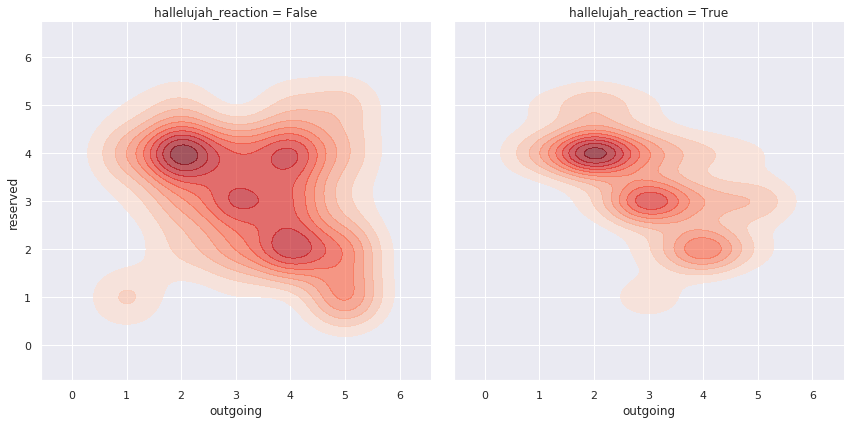

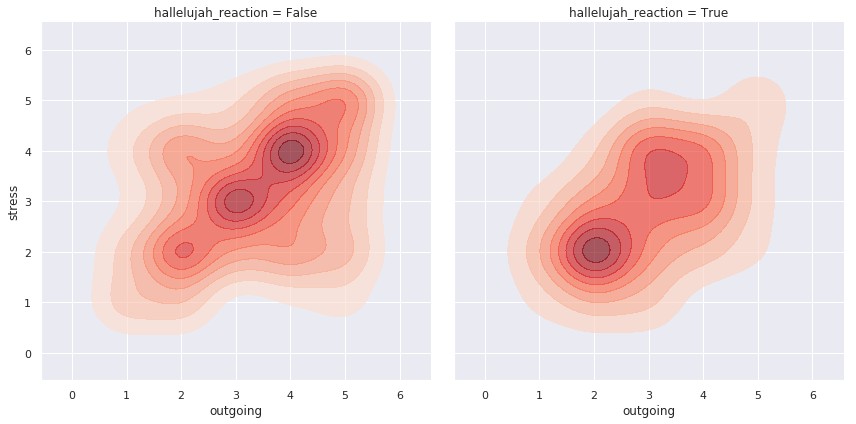

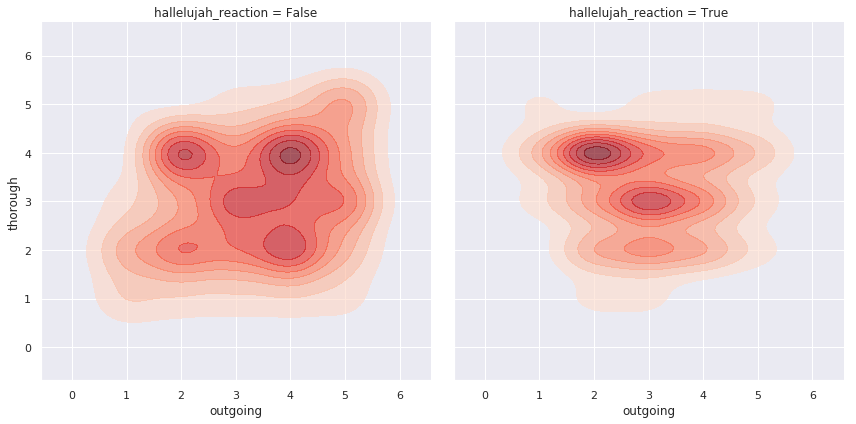

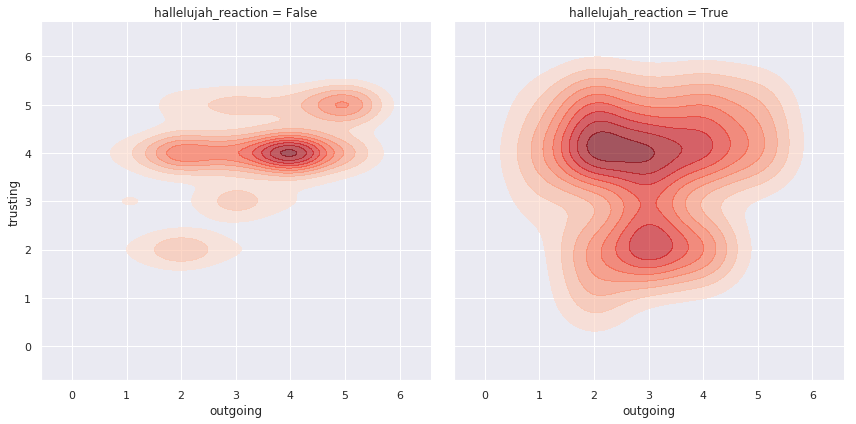

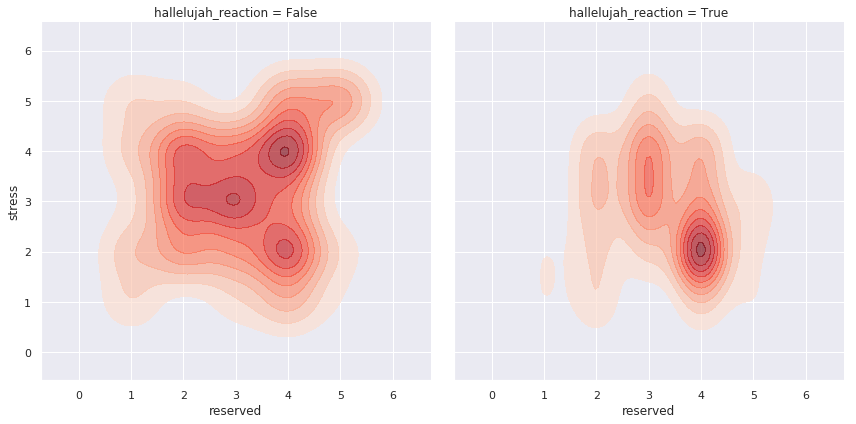

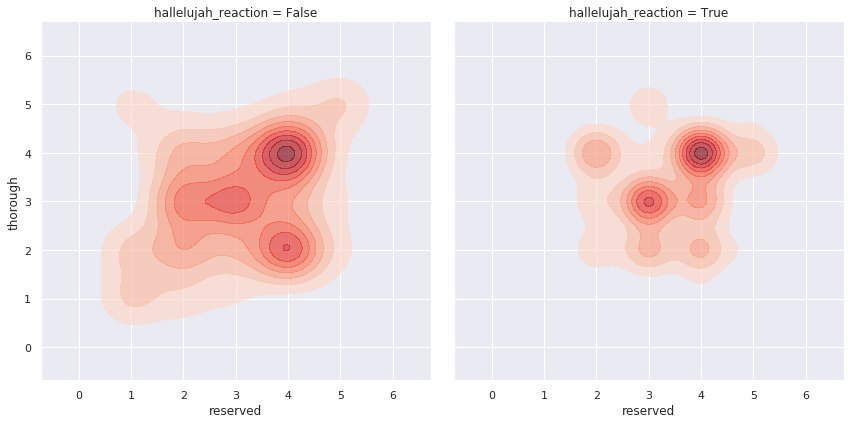

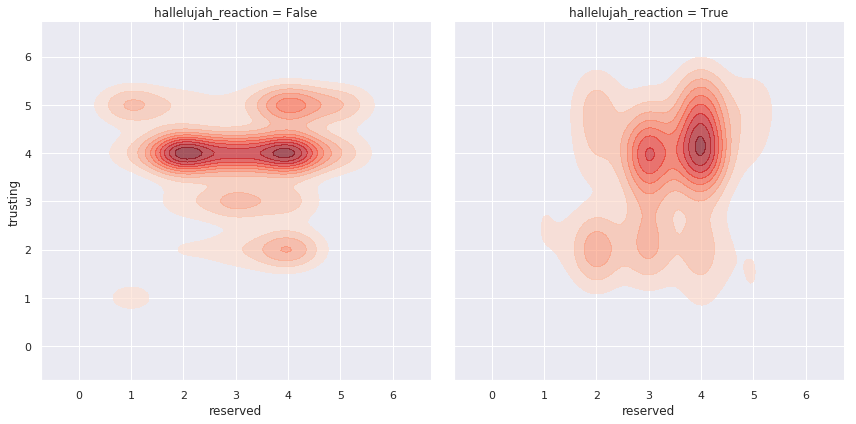

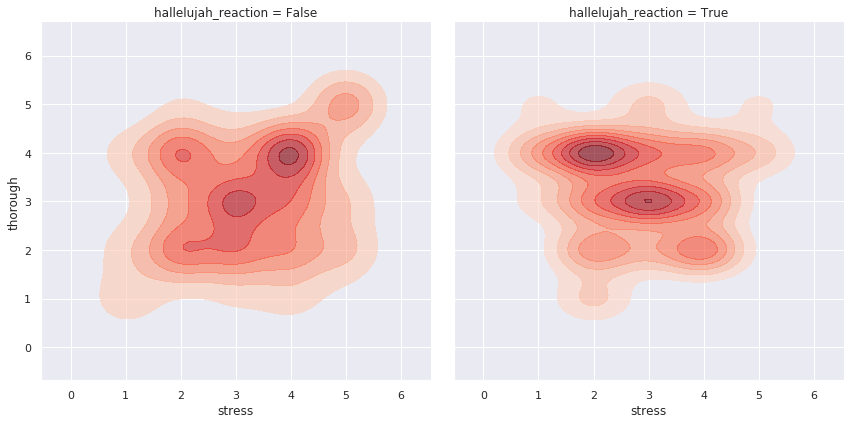

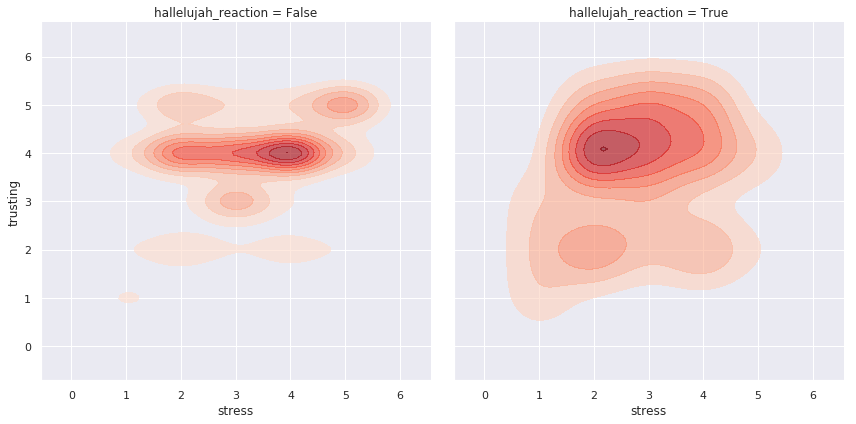

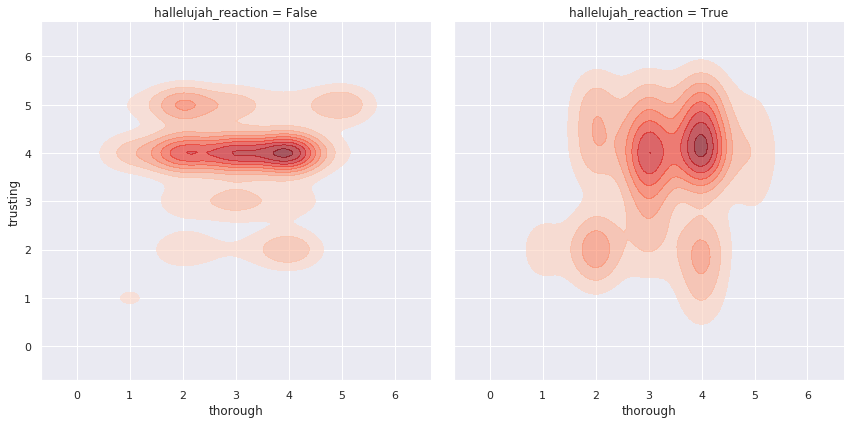

In [1028]:
import itertools

plot_vars = ['activity', 
             'engagement', 
             'familiarity', 
             'like_dislike', 
             'positivity', 
             'tension', 
             'age', 
             'musical_expertise', 
             'concentration', 
             'artistic', 
             'fault', 
             'imagination', 
             'lazy', 
             'nervous', 
             'outgoing', 
             'reserved', 
             'stress', 
             'thorough', 
             'trusting']

pairs = list(itertools.combinations(plot_vars, 2))

for pair in pairs:
    
#     x_1 = df_all[pair[0]].describe()['25%']
#     x_3 = df_all[pair[0]].describe()['75%']
#     x_iqr = x_3 - x_1
#     x_min = x_1 - 1.5 * x_iqr
#     x_max = x_3 + 1.5 * x_iqr

#     y_1 = df_all[pair[1]].describe()['25%']
#     y_3 = df_all[pair[1]].describe()['75%']
#     y_iqr = y_3 - y_1
#     y_min = y_1 - 1 * y_iqr
#     y_max = y_3 + 1 * y_iqr

#     xlim, ylim = (x_min, x_max), (y_min, y_max)

#     g = sns.FacetGrid(df_all[[pair[0], pair[1], 'hallelujah_reaction']], col='hallelujah_reaction', height=6, aspect=1, xlim=xlim, ylim=ylim)
    g = sns.FacetGrid(df_all[[pair[0], pair[1], 'hallelujah_reaction']], col='hallelujah_reaction', height=6, aspect=1, margin_titles=True)
    g.map(sns.kdeplot, pair[0], pair[1], cmap='Reds', shade=True, shade_lowest=False, alpha=0.65)
    g.savefig('hallelujah_reaction_distributions_{}_{}_by_reaction.pdf'.format(pair[0], pair[1]))

# Pairwise Hotelling's $T^2$

In [1035]:
import itertools

plot_vars = ['activity', 
             'engagement', 
             'familiarity', 
             'like_dislike', 
             'positivity', 
             'tension', 
             'age', 
             'musical_expertise', 
             'concentration', 
             'artistic', 
             'fault', 
             'imagination', 
             'lazy', 
             'nervous', 
             'outgoing', 
             'reserved', 
             'stress', 
             'thorough', 
             'trusting']

pairs = list(itertools.combinations(plot_vars, 2))

results = pd.DataFrame(columns=['p', 'adjustedP', 'F', 'T2', 'df1', 'df2', 'D2'])
# results = pd.DataFrame(columns=['p', 'F', 'T2', 'df1', 'df2', 'pSkew', 'pKurt'])

for pair in pairs:
    
    test_vars = list(pair)
    test_vars.append('hallelujah_reaction')
    df_pair = df_all[test_vars].dropna()
    df_pair_1 = df_pair[df_pair['hallelujah_reaction'] == False].drop(['hallelujah_reaction'], axis=1)
    df_pair_2 = df_pair[df_pair['hallelujah_reaction'] == True].drop(['hallelujah_reaction'], axis=1)
    
    mardia_result = mardia(df_pair.drop(['hallelujah_reaction'], axis=1), unbiased_cov=True)
    if mardia_result[2]['result']:
        pass

    t2_results = hotelling_t2(df_pair_1, df_pair_2, 0.05)
    p = t2_results['p']
    adjusted_p = p * len(pairs)
    if adjusted_p > 1:
        adjusted_p = 1
        
    row = pd.DataFrame(
        {
            'p': t2_results['p'], 
            'adjustedP': adjusted_p,
            'F': t2_results['F'], 
            'T2': t2_results['T2'], 
            'df1': t2_results['df'][0], 
            'df2': t2_results['df'][1],
            'D2': t2_results['D2']
#             'pSkew': mardia_result[0]['p-value'],
#             'pKurt': mardia_result[1]['p-value'],
        }, 
        index=[pair])

    results = pd.concat([results, row])

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.5f' % x):
    display('Tests for difference between combined means of {} and {} between hallelujah reaction groups:'.format(pair[0], pair[1]))
    display(results)
    
results.to_csv('hotelling_comparisons.csv')

'Tests for difference between combined means of thorough and trusting between hallelujah reaction groups:'

D2       F      T2 adjustedP df1  df2  \
(activity, engagement)             0.08754 2.40994 4.83655         1   2  289   
(activity, familiarity)            0.11966 3.29396 6.61072         1   2  289   
(activity, like_dislike)           0.09967 2.74364 5.50627         1   2  289   
(activity, positivity)             0.07871 2.16685 4.34869         1   2  289   
(activity, tension)                0.10469 2.88191 5.78377         1   2  289   
(activity, age)                    0.06742 1.85607 3.72498         1   2  289   
(activity, musical_expertise)      0.07054 1.40729 2.82864         1   2  200   
(activity, concentration)          0.02141 0.41426 0.83299   0.03278   2  185   
(activity, artistic)               0.02029 0.39256 0.78936   0.01526   2  185   
(activity, fault)                  0.11349 2.16761 4.35877         1   2  184   
(activity, imagination)            0.02838 0.54201 1.08991   0.97127   2  184   
(activity, lazy)                   0.05064 0.97987 1.97033         1   2  185   
(activity, nervous)                0.08796 1.67990 3.37807         1   2  184   
(activity, outgoing)               0.10205 1.94910 3.91939         1   2  184   
(activity, reserved)               0.06586 1.27432 2.56242         1   2  185   
(activity, stress)                 0.11298 2.18616 4.39596         1   2  185   
(activity, thorough)               0.08936 1.70663 3.43181         1   2  184   
(activity, trusting)               0.06580 1.27333 2.56043         1   2  185   
(engagement, familiarity)          0.06958 1.91533 3.84392         1   2  289   
(engagement, like_dislike)         0.02672 0.73550 1.47609         1   2  289   
(engagement, positivity)           0.01509 0.41551 0.83390   0.03419   2  289   
(engagement, tension)              0.02904 0.79946 1.60444         1   2  289   
(engagement, age)                  0.01796 0.49452 0.99246   0.33284   2  289   
(engagement, musical_expertise)    0.08961 1.78761 3.59309         1   2  200   
(engagement, concentration)        0.01624 0.31417 0.63173   0.00049   2  185   
(engagement, artistic)             0.00427 0.08260 0.16610   0.00000   2  185   
(engagement, fault)                0.09865 1.88410 3.78867         1   2  184   
(engagement, imagination)          0.00479 0.09154 0.18408   0.00000   2  184   
(engagement, lazy)                 0.03864 0.74764 1.50337         1   2  185   
(engagement, nervous)              0.05571 1.06405 2.13968         1   2  184   
(engagement, outgoing)             0.08984 1.71583 3.45031         1   2  184   
(engagement, reserved)             0.05159 0.99828 2.00734         1   2  185   
(engagement, stress)               0.11403 2.20647 4.43680         1   2  185   
(engagement, thorough)             0.04567 0.87228 1.75405         1   2  184   
(engagement, trusting)             0.05795 1.12142 2.25496         1   2  185   
(familiarity, like_dislike)        0.07720 2.12507 4.26484         1   2  289   
(familiarity, positivity)          0.06845 1.88421 3.78145         1   2  289   
(familiarity, tension)             0.09256 2.54812 5.11386         1   2  289   
(familiarity, age)                 0.06989 1.92404 3.86139         1   2  289   
(familiarity, musical_expertise)   0.11512 2.29655 4.61606         1   2  200   
(familiarity, concentration)       0.04435 0.85812 1.72552         1   2  185   
(familiarity, artistic)            0.04289 0.82985 1.66867         1   2  185   
(familiarity, fault)               0.16217 3.09736 6.22839         1   2  184   
(familiarity, imagination)         0.05786 1.10501 2.22204         1   2  184   
(familiarity, lazy)                0.09531 1.84417 3.70828         1   2  185   
(familiarity, nervous)             0.10647 2.03360 4.08930         1   2  184   
(familiarity, outgoing)            0.14168 2.70602 5.44146         1   2  184   
(familiarity, reserved)            0.09212 1.78244 3.58416         1   2  185   
(familiarity, stress)              0.13812 2.67265 5.37420         1   

In [444]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 5.0, 50)},
                    cv=100) # 20-fold cross-validation
grid.fit(df_all[['tension', 'age']])
print(grid.best_params_)

{'bandwidth': 2.6535306122448978}


In [375]:
this_col.describe()

count    303.000000
mean       2.344099
std        0.988361
min        1.000000
25%        2.000000
50%        2.353712
75%        2.353712
max        5.000000
Name: artistic, dtype: float64

- Ordinal
  - Demographic
    - age
    - musical_expertise
    - concentration
  - Personality
    - artistic
    - fault
    - imagination
    - lazy
    - nervous
    - outgoing
    - reserved
    - stress
    - thorough
    - trusting
  - Musical Response
    - activity
    - engagement
    - familiarity
    - like_dislike
    - positivity
    - tension
- Categorical
  - Demographic
    - hearing_impairments
    - nationality
    - location
    - language
    - sex
  - Musical Response
    - hallelujah_reaction

# Hotelling's Two-Sample $T^2$

In [484]:
hotelling_vars = [
    'age',
    'concentration',
    'hearing_impairments',
    'musical_expertise',
#     'nationality',
    'artistic',
    'fault',
    'imagination',
    'lazy',
    'nervous',
    'outgoing',
    'reserved',
    'stress',
    'thorough',
    'trusting',
    'activity',
    'engagement',
    'familiarity',
    'like_dislike',
    'positivity',
    'tension',
#     'sex',
    'hallelujah_reaction',
#     'location',
#     'language',
    'music_pref_none',
    'music_pref_hiphop',
    'music_pref_dance',
    'music_pref_world',
    'music_pref_rock',
    'music_pref_pop',
    'music_pref_classical',
    'music_pref_jazz',
    'music_pref_folk',
    'music_pref_traditional_irish'
]

In [485]:
nationality_cols = pd.get_dummies(df_all['nationality'], prefix='nationality')
sex_cols = pd.get_dummies(df_all['sex'], prefix='sex')
location_cols = pd.get_dummies(df_all['location'], prefix='location')
language_cols = pd.get_dummies(df_all['language'], prefix='language')

In [486]:
df_hotelling = df_all[hotelling_vars]
df_hotelling = pd.concat([df_hotelling, 
                          nationality_cols, 
                          sex_cols, 
                          location_cols, 
                          language_cols], axis=1)

In [653]:
df_hotelling_1 = df_hotelling[df_hotelling['hallelujah_reaction'] == False].drop(['hallelujah_reaction'], axis=1)
df_hotelling_2 = df_hotelling[df_hotelling['hallelujah_reaction'] == True].drop(['hallelujah_reaction'], axis=1)

print('Test for difference between combined means of hallelujah reaction groups')
hotelling_t2(df_hotelling_1, df_hotelling_2, 0.05)

Test for difference between combined means of hallelujah reaction groups


{'F': 0.99110374871375451,
 'T2': array(56.37585417880443),
 'df': (48, 254),
 'p': 0.50375934411737811}

In [833]:
n_males = len(df_all[df_all['sex'] == 'male'])
n_females = len(df_all[df_all['sex'] == 'female'])

display('Males: {}, Females: {}'.format(n_males, n_females))

'Males: 153, Females: 150'

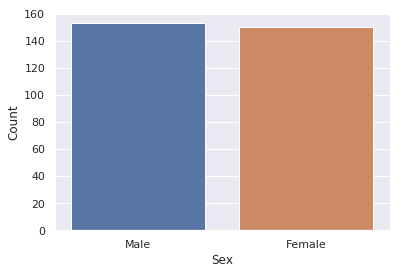

In [841]:
f = sns.countplot(x='sex', data=df_all)
f.set_ylabel('Count')
f.set_xlabel('Sex')
f.set_xticklabels(['Male', 'Female'])
plt.savefig('hallelujah_reaction_countplot_sex.pdf')

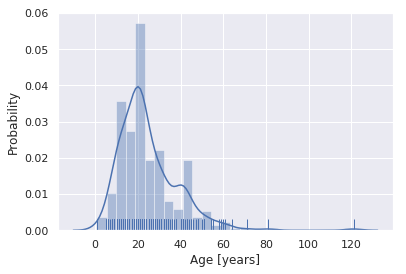

In [849]:
f = sns.distplot(df_all['age'], rug=True)
f.set_xlabel('Age [years]')
f.set_ylabel('Probability')
plt.savefig('hallelujah_reaction_hist_age.pdf')

In [70]:
def invert_scale(series):
    return (series * -1) + 6

df_all ['extraversion'] = (df_all['artistic'] + invert_scale(df_all['reserved'])) / 2.
df_all ['agreeableness'] = (df_all['trusting'] + invert_scale(df_all['fault'])) / 2.
df_all ['conscientiousness'] = (df_all['thorough'] + invert_scale(df_all['lazy'])) / 2.
df_all ['neuroticism'] = (df_all['nervous'] + invert_scale(df_all['stress'])) / 2.
df_all ['openness'] = (df_all['imagination'] + invert_scale(df_all['artistic'])) / 2.

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Extraversion between Hallelujah Reaction groups
T test statistic: -0.7648
T test p-value: 0.4454
Mann-Whitney U test statistic: 3412.0000
Mann-Whitney U test p-value: 0.4590


{'mean_true': 2.5272727272727273,
 'mean_false': 2.6240601503759398,
 'median_true': 2.5,
 'median_false': 2.5,
 't_stat': -0.7647848141396487,
 't_p': 0.4453689143090779,
 'u_stat': 3412.0,
 'u_p': 0.4590333142845482}

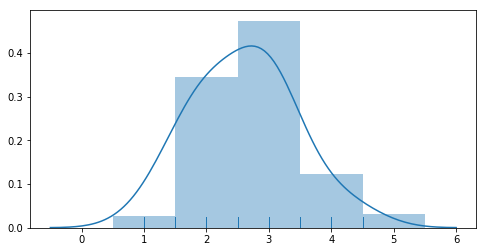

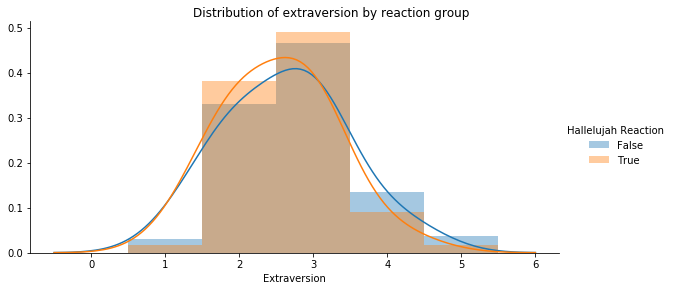

In [71]:
run_tests('Extraversion', 'extraversion', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Agreeableness between Hallelujah Reaction groups
T test statistic: -2.3086
T test p-value: 0.0221
Mann-Whitney U test statistic: 2982.0000
Mann-Whitney U test p-value: 0.0620
**** Significant Result ****


{'mean_true': 3.0555555555555554,
 'mean_false': 3.338345864661654,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': -2.308648715698901,
 't_p': 0.02206849032867011,
 'u_stat': 2982.0,
 'u_p': 0.06202684940745641}

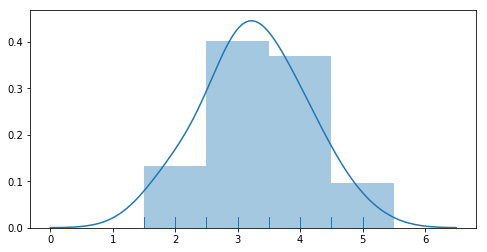

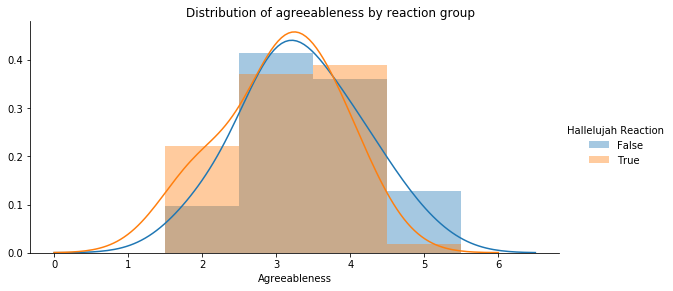

In [72]:
run_tests('Agreeableness', 'agreeableness', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Conscientiousness between Hallelujah Reaction groups
T test statistic: 0.0980
T test p-value: 0.9221
Mann-Whitney U test statistic: 3637.5000
Mann-Whitney U test p-value: 0.8880


{'mean_true': 2.712962962962963,
 'mean_false': 2.699248120300752,
 'median_true': 3.0,
 'median_false': 3.0,
 't_stat': 0.09795993240724857,
 't_p': 0.9220701626787239,
 'u_stat': 3637.5,
 'u_p': 0.8880230537731499}

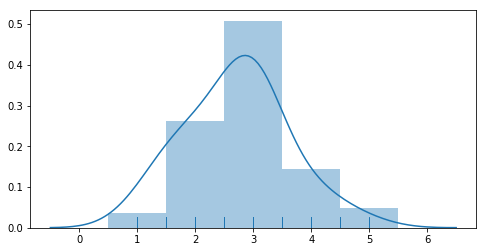

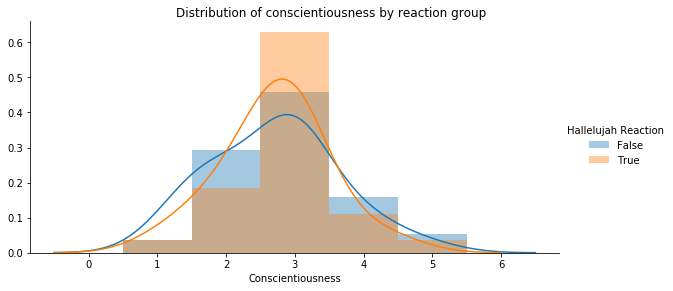

In [73]:
run_tests('Conscientiousness', 'conscientiousness', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Neuroticism between Hallelujah Reaction groups
T test statistic: 2.2607
T test p-value: 0.0249
Mann-Whitney U test statistic: 4285.0000
Mann-Whitney U test p-value: 0.0343
**** Significant Result ****


{'mean_true': 3.5,
 'mean_false': 3.1954887218045114,
 'median_true': 3.5,
 'median_false': 3.0,
 't_stat': 2.2606615843587083,
 't_p': 0.024945015169796036,
 'u_stat': 4285.0,
 'u_p': 0.03428039311015956}

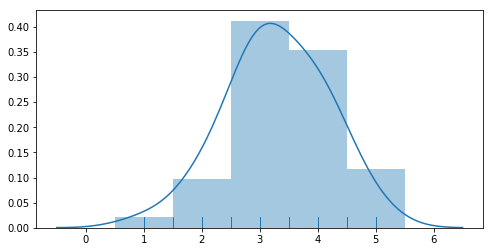

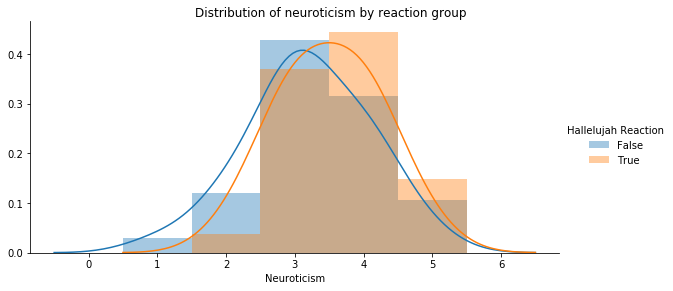

In [74]:
run_tests('Neuroticism', 'neuroticism', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

All normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
No-reaction normal test results: NormaltestResult(statistic=nan, pvalue=nan)
Student's t-test for difference in mean Openness to experience between Hallelujah Reaction groups
T test statistic: -0.2288
T test p-value: 0.8193
Mann-Whitney U test statistic: 3493.5000
Mann-Whitney U test p-value: 0.7682


{'mean_true': 3.740740740740741,
 'mean_false': 3.7706766917293235,
 'median_true': 3.75,
 'median_false': 4.0,
 't_stat': -0.22880609626658824,
 't_p': 0.8192723613638038,
 'u_stat': 3493.5,
 'u_p': 0.7681917560758771}

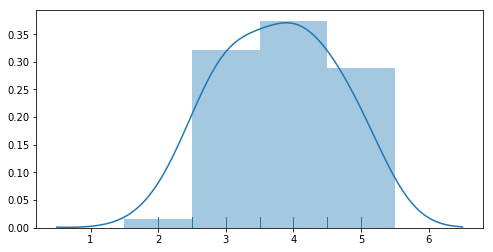

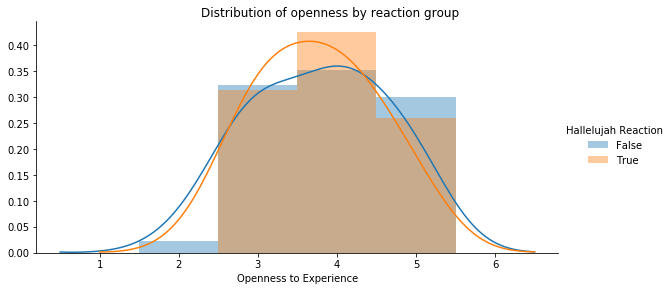

In [75]:
run_tests('Openness to Experience', 'openness', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5, plots=True, print_output=True)

In [997]:
df_all[df_all['hallelujah_reaction'] == True]['agreeableness'].mean()

3.0555555555555554

In [998]:
df_all[df_all['hallelujah_reaction'] == True]['agreeableness'].median()

3.0

In [999]:
df_all[df_all['hallelujah_reaction'] == False]['agreeableness'].mean()

3.3383458646616542

In [1000]:
df_all[df_all['hallelujah_reaction'] == False]['agreeableness'].median()

3.0

# "Interaction" Plots

In [1097]:
def interaction_plot(var_a, var_b):
    f, ax = plt.subplots()
    reaction_var_a_mean = df_all[df_all['hallelujah_reaction'] == True][var_a].mean()
    no_reaction_var_a_mean = df_all[df_all['hallelujah_reaction'] == False][var_a].mean()
    reaction_var_b_mean = df_all[df_all['hallelujah_reaction'] == True][var_b].mean()
    no_reaction_var_b_mean = df_all[df_all['hallelujah_reaction'] == False][var_b].mean()
    ax.plot([0, 1], [reaction_var_a_mean, reaction_var_b_mean], label='Reaction')
    ax.plot([0, 1], [no_reaction_var_a_mean, no_reaction_var_b_mean], label='No Reaction')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([var_a.replace('_', ' ').capitalize(), var_b.replace('_', ' ').capitalize()])
    ax.set_ylim(
        [
            np.floor(np.minimum(
                df_all[var_a].min(),
                df_all[var_b].min()
            )),
            np.ceil(np.maximum(
                df_all[var_a].max(),
                df_all[var_b].max()
            ))
        ])
    ax.legend()
    plt.savefig('hallelujah_reaction_interaction_{}_{}.pdf'.format(var_a, var_b))

/jet/var/python/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


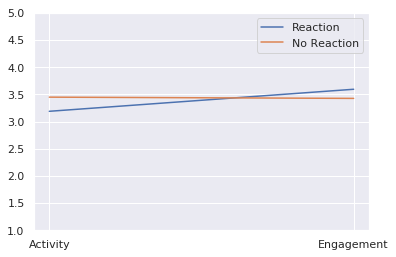

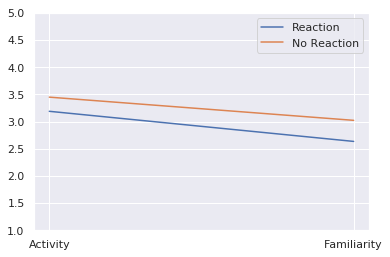

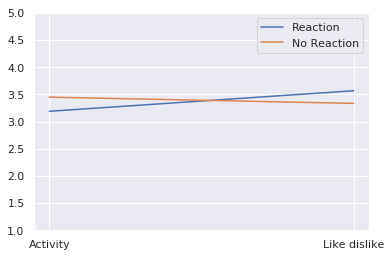

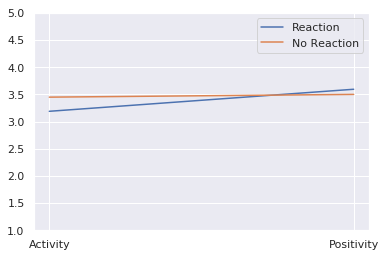

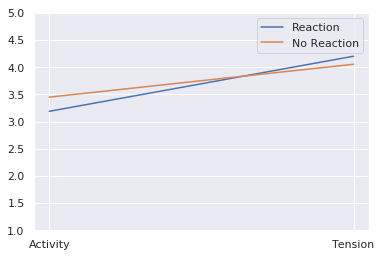

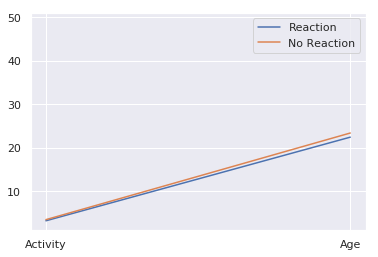

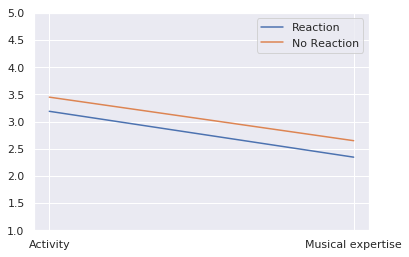

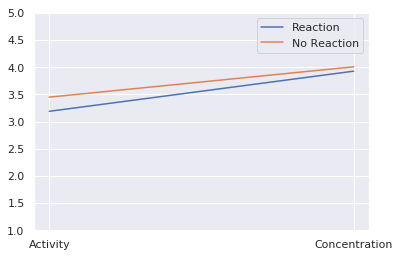

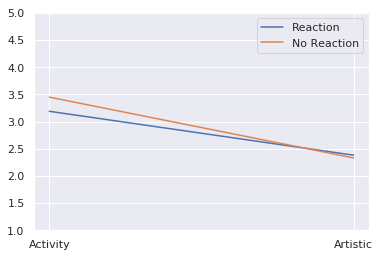

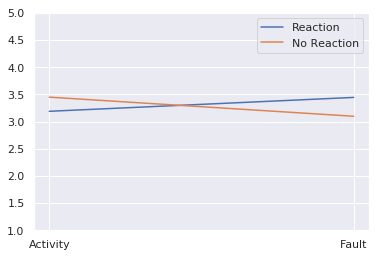

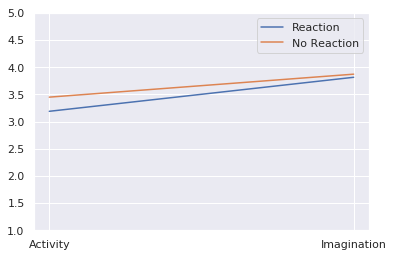

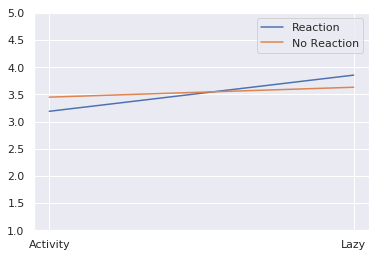

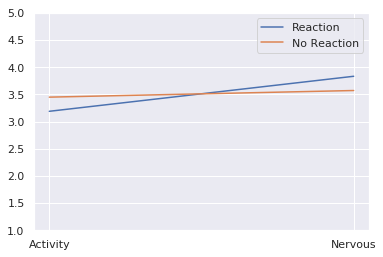

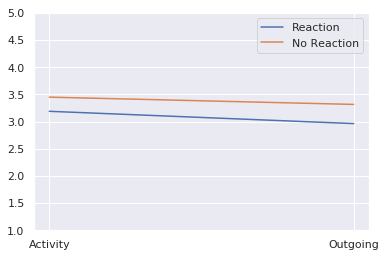

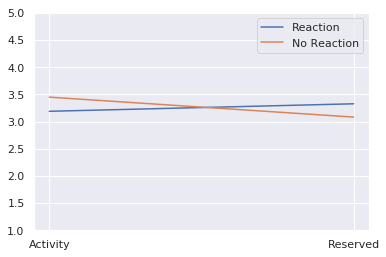

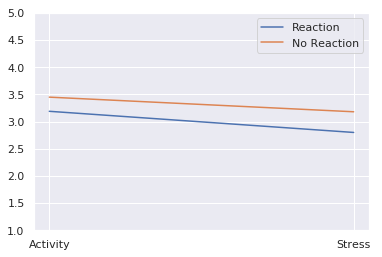

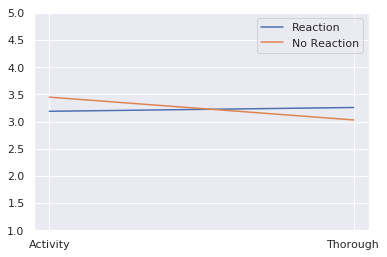

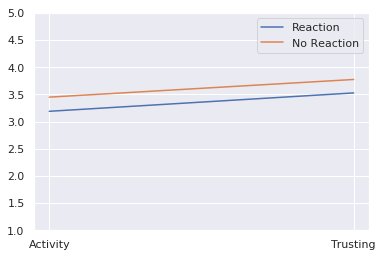

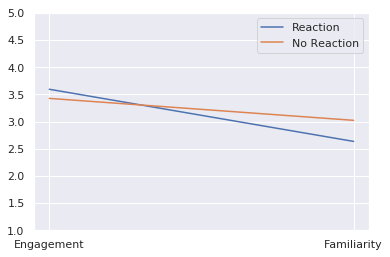

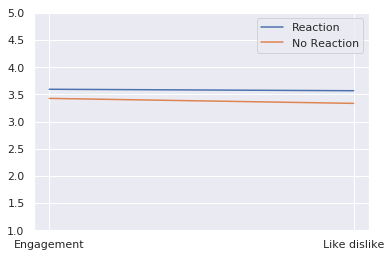

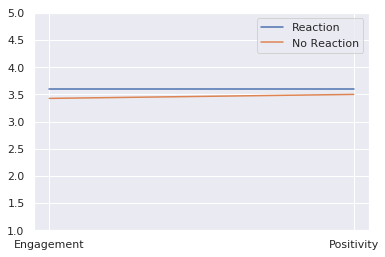

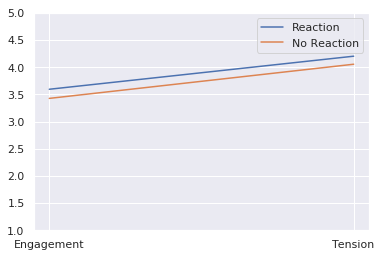

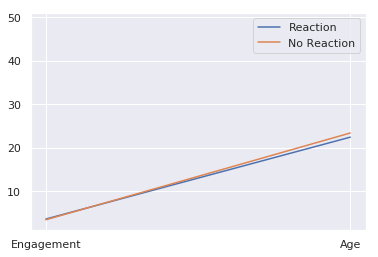

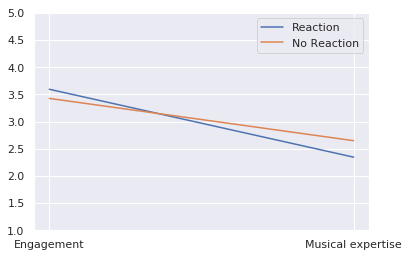

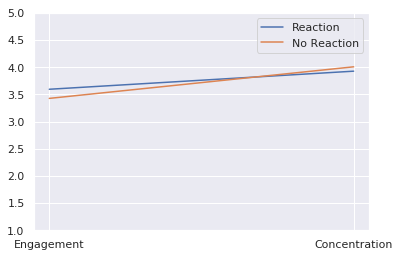

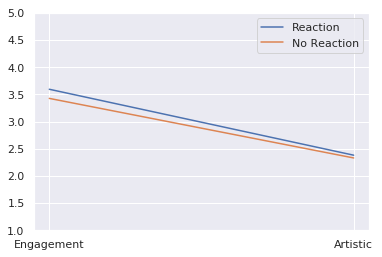

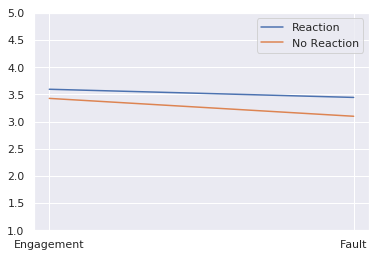

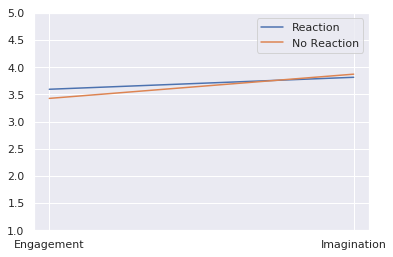

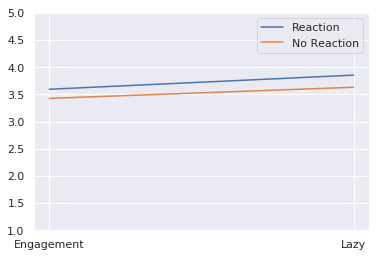

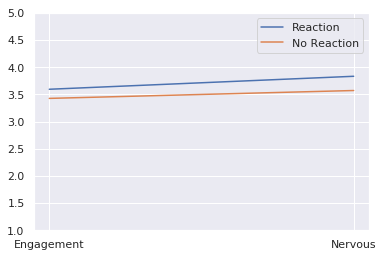

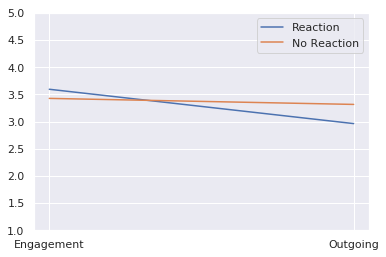

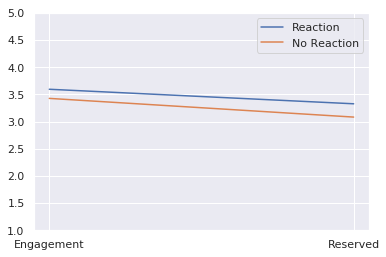

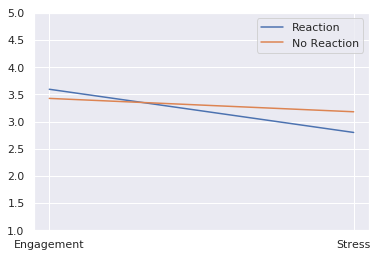

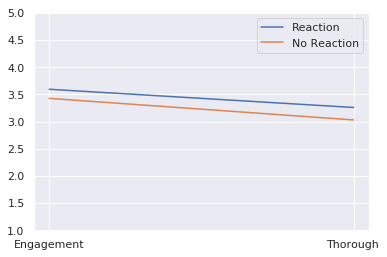

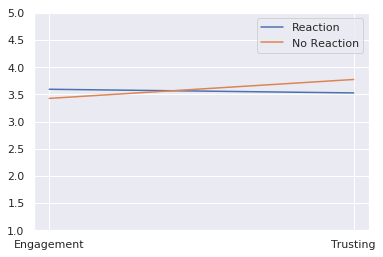

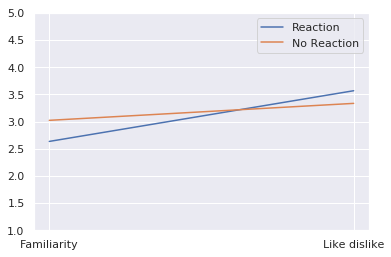

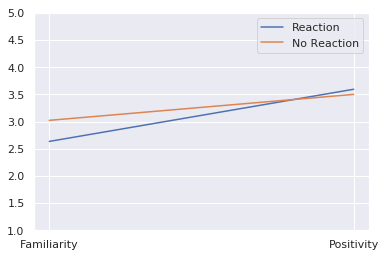

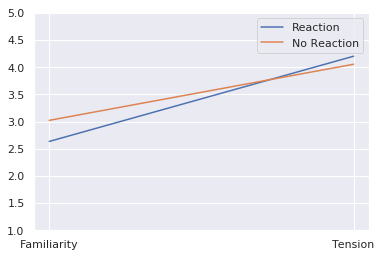

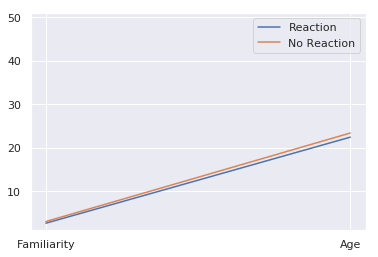

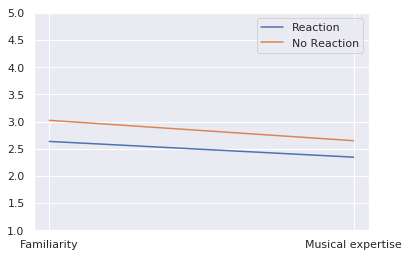

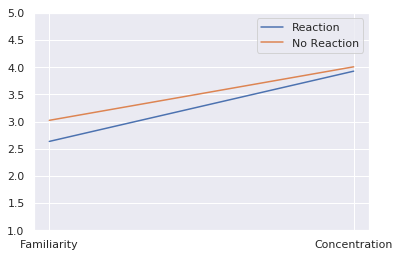

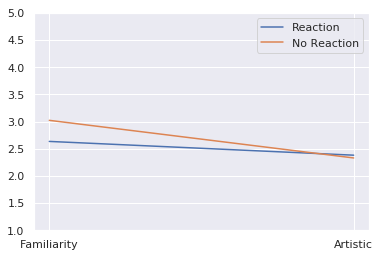

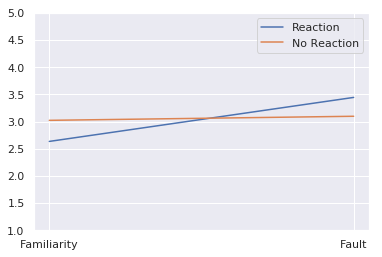

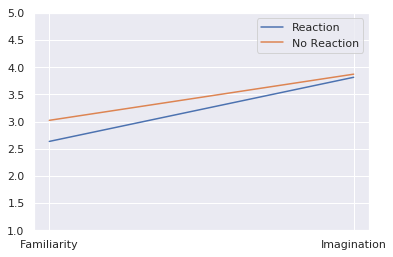

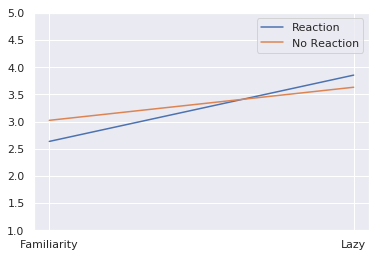

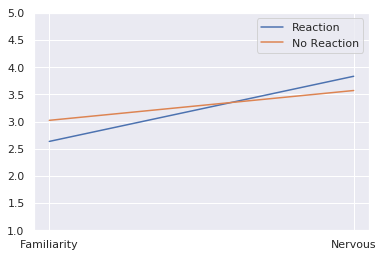

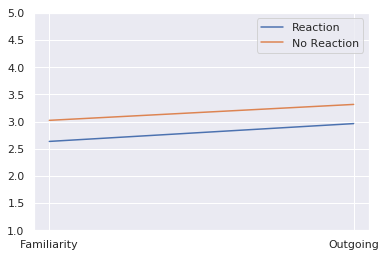

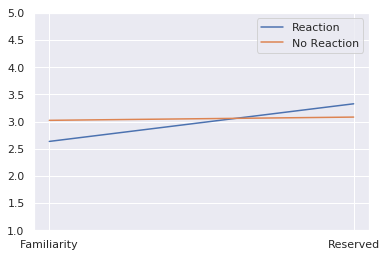

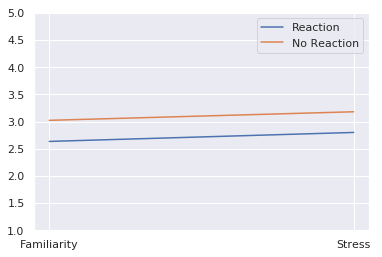

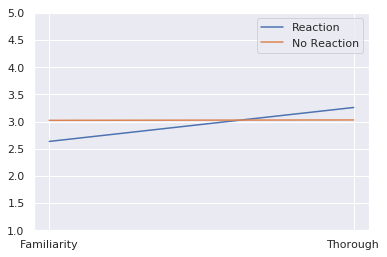

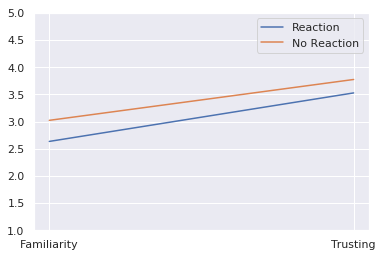

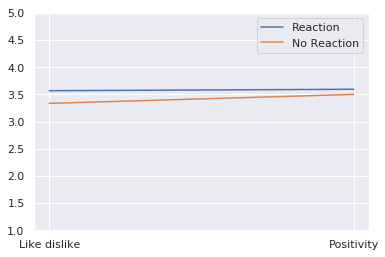

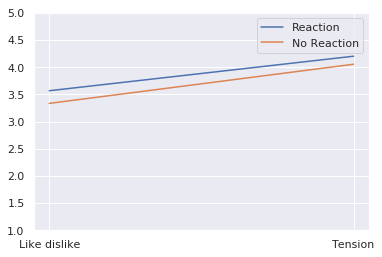

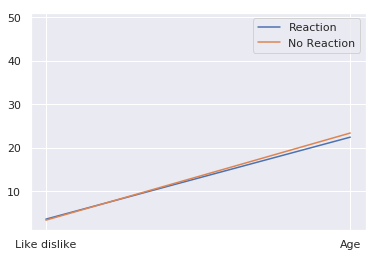

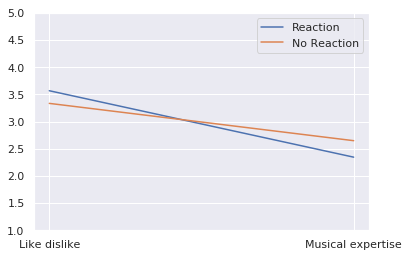

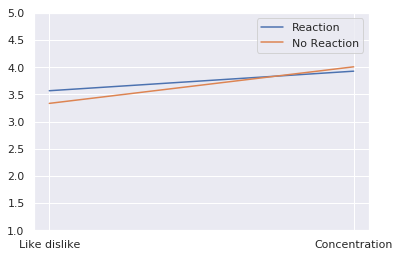

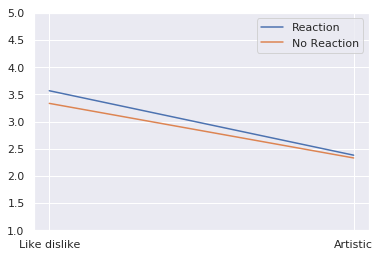

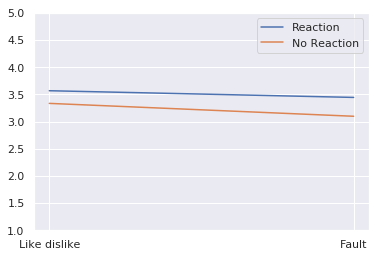

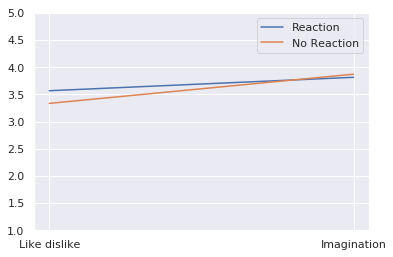

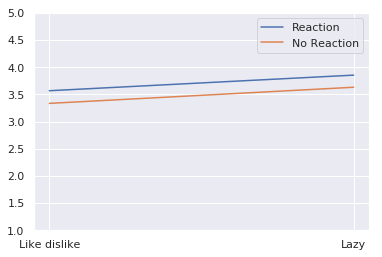

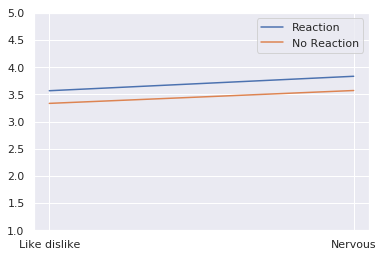

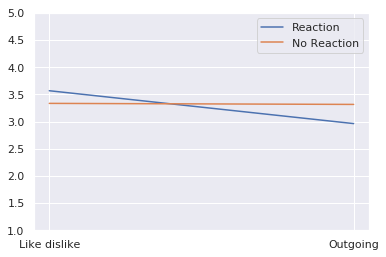

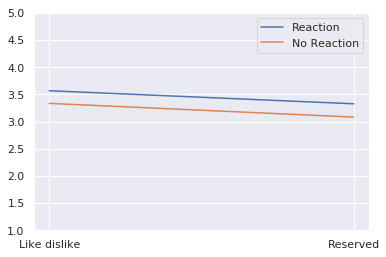

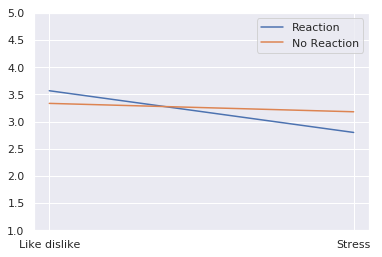

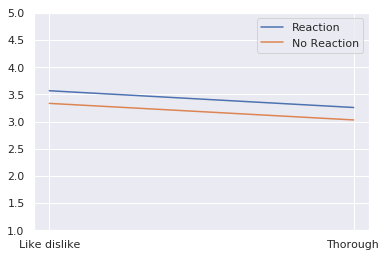

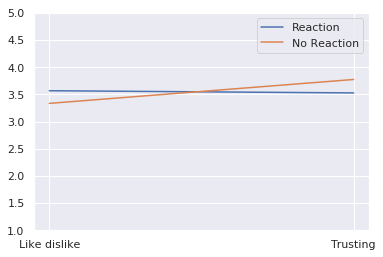

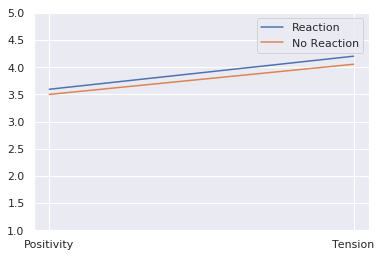

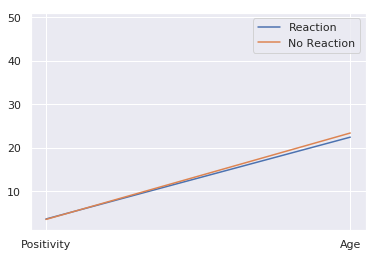

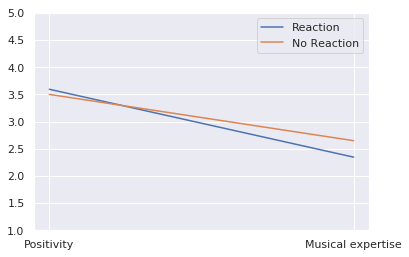

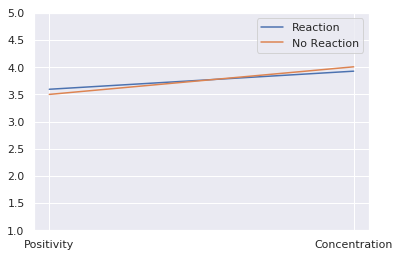

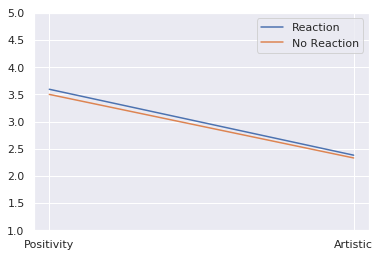

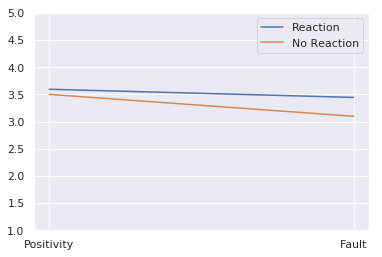

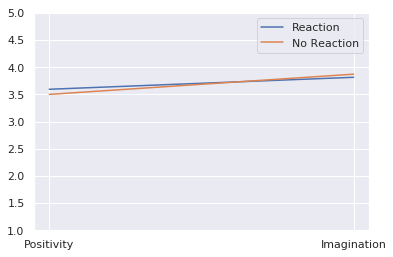

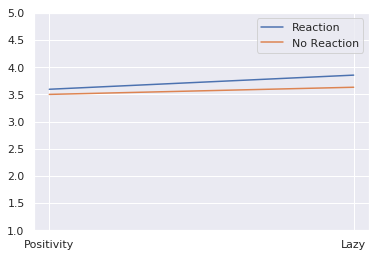

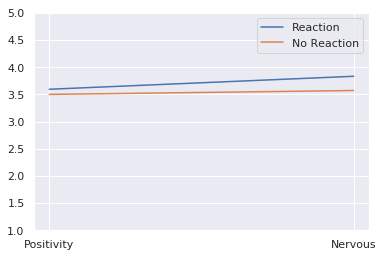

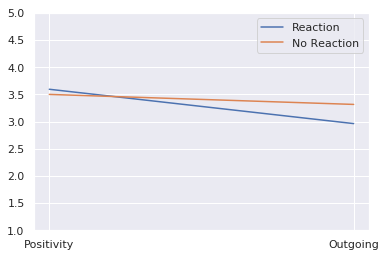

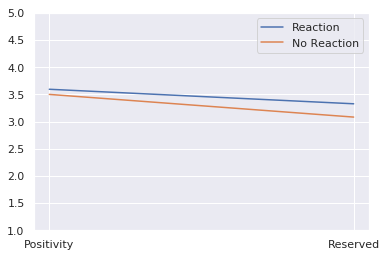

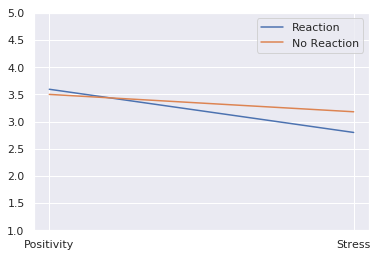

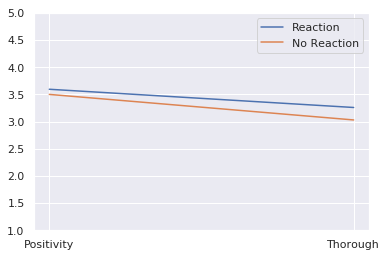

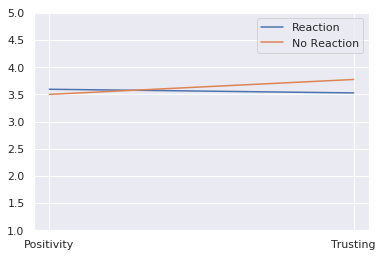

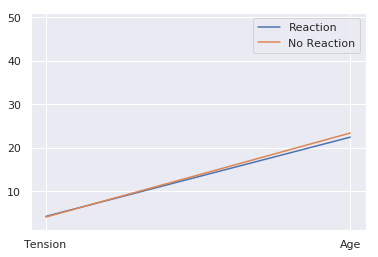

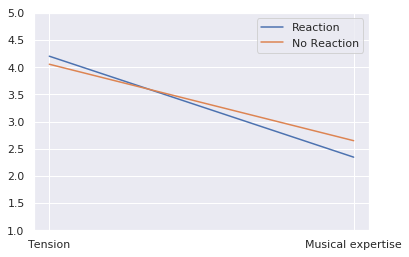

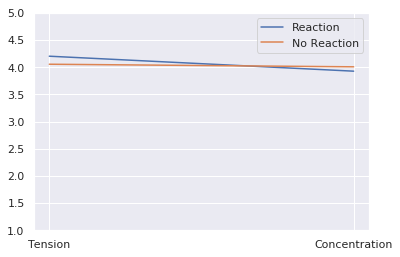

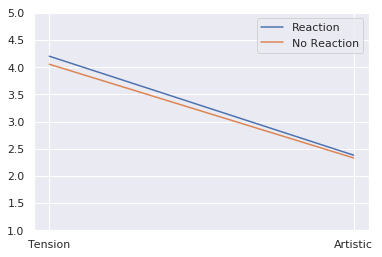

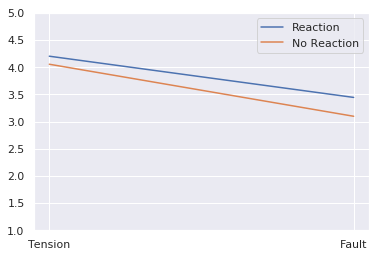

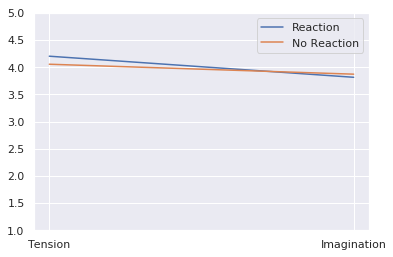

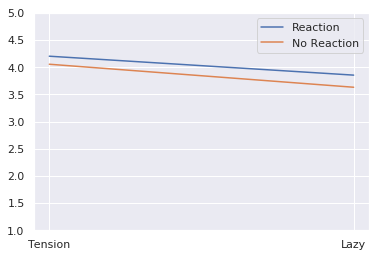

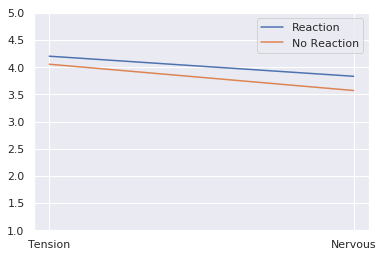

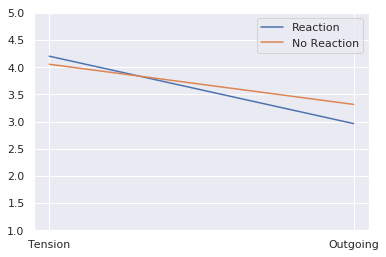

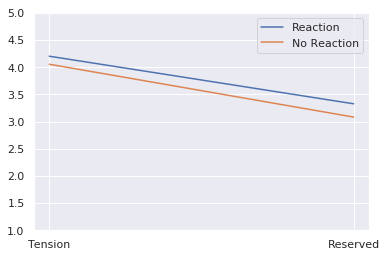

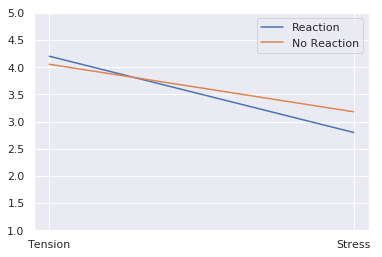

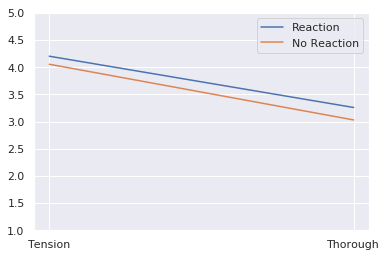

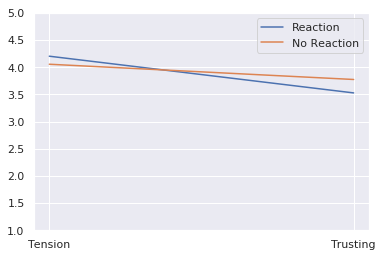

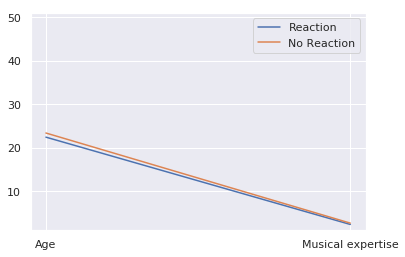

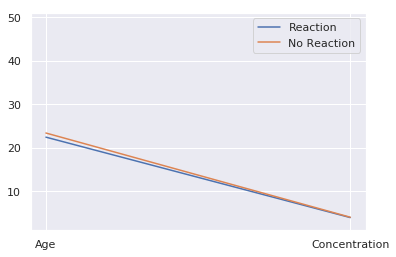

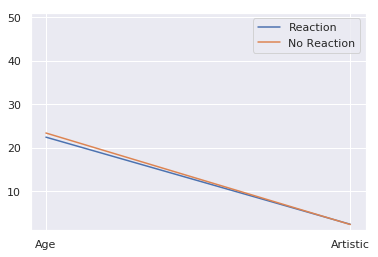

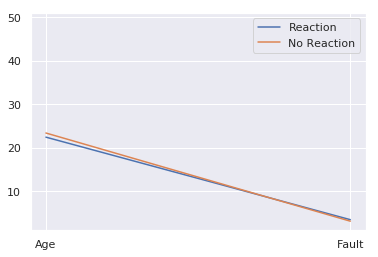

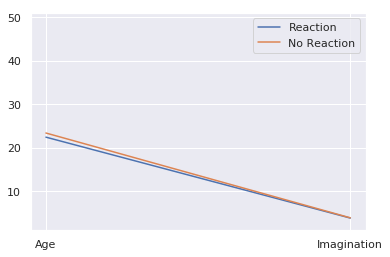

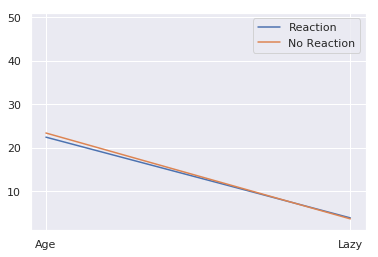

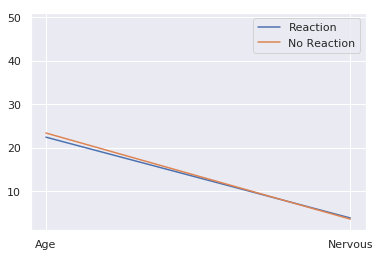

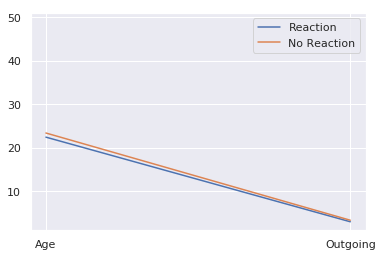

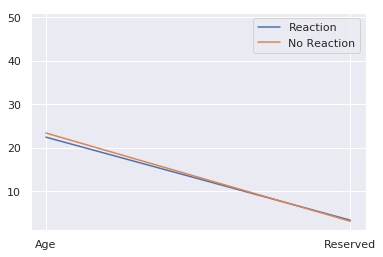

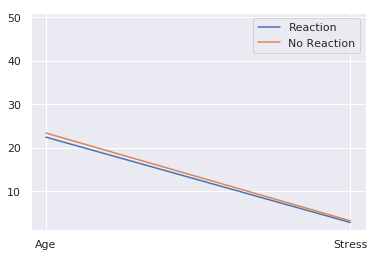

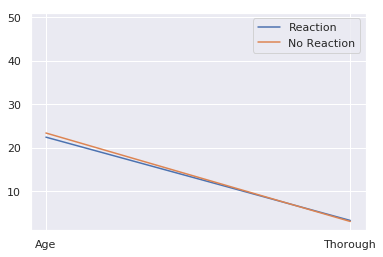

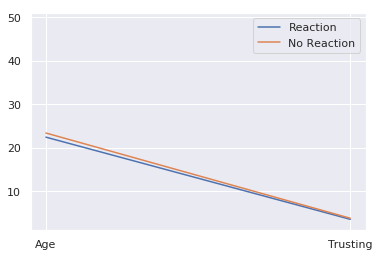

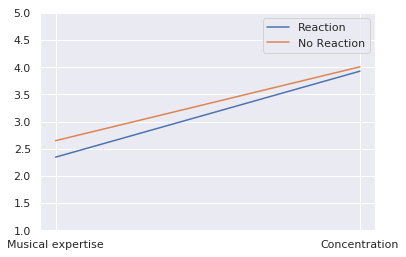

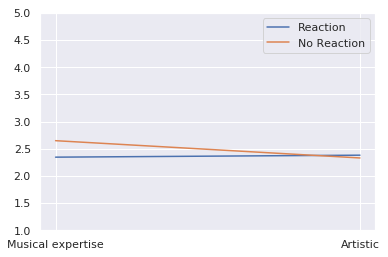

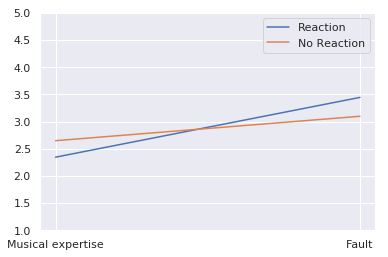

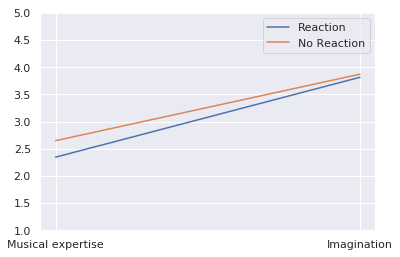

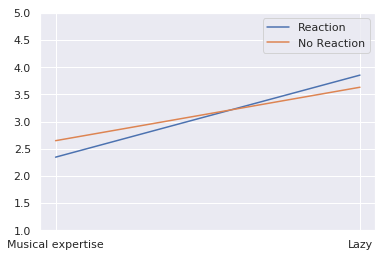

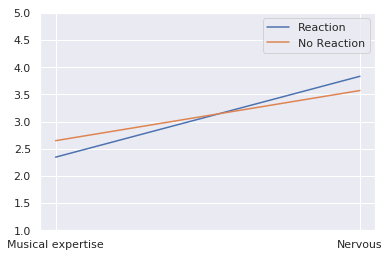

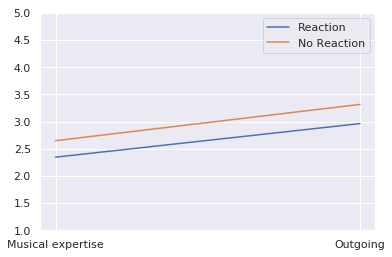

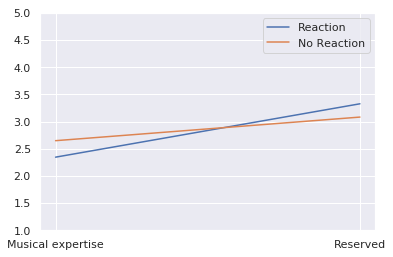

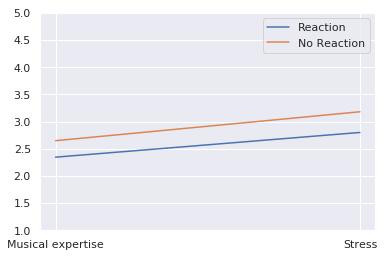

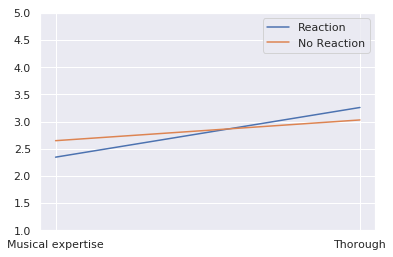

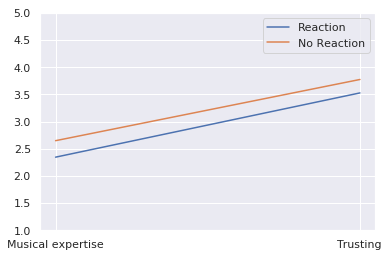

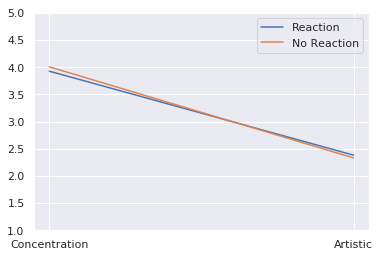

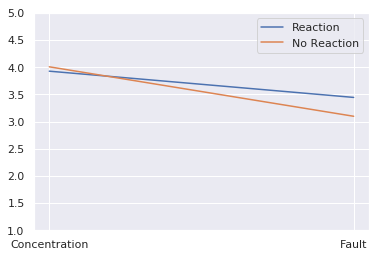

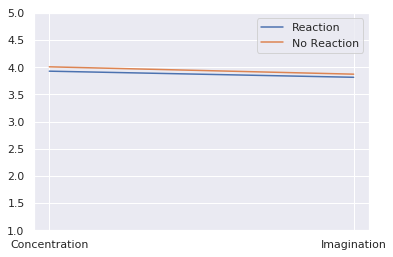

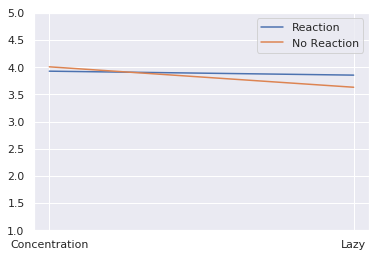

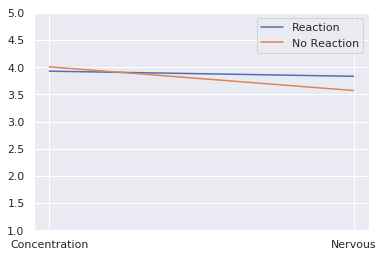

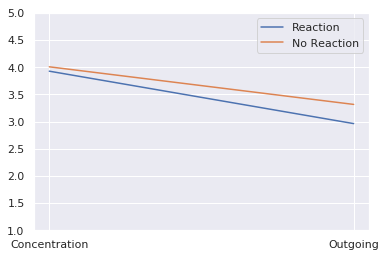

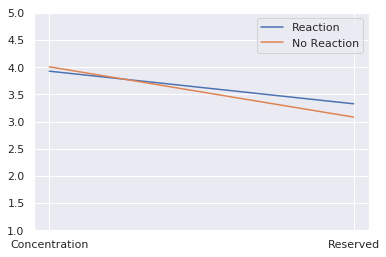

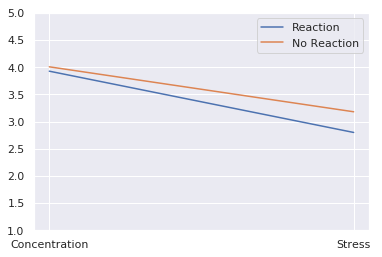

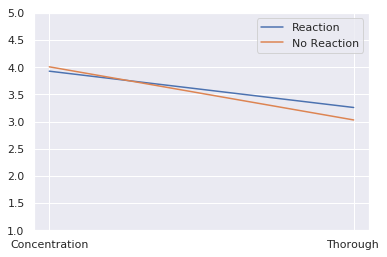

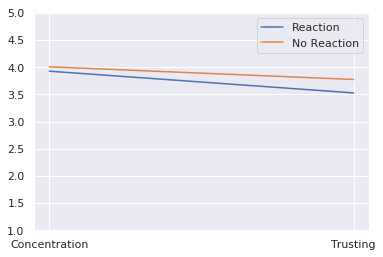

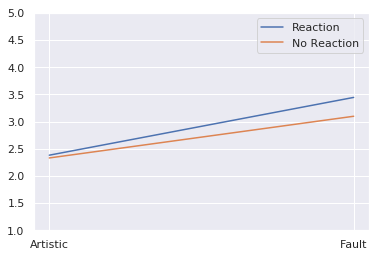

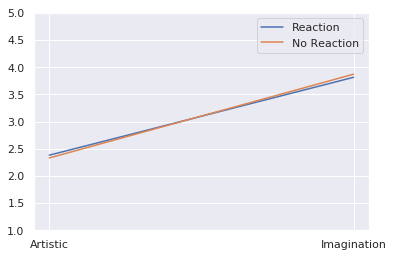

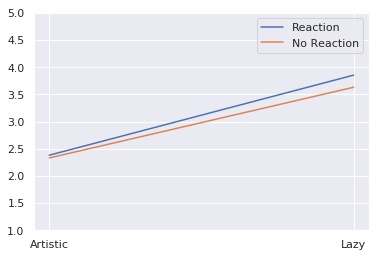

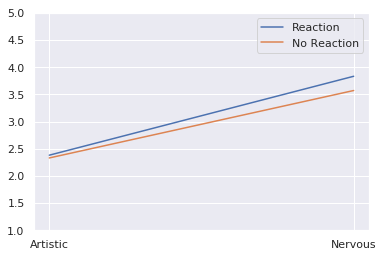

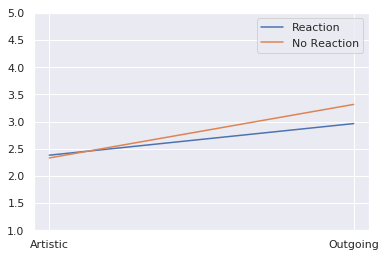

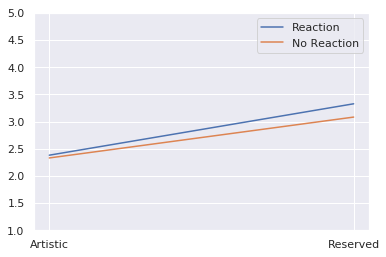

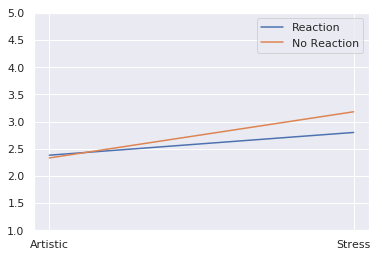

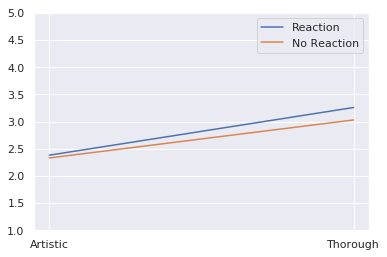

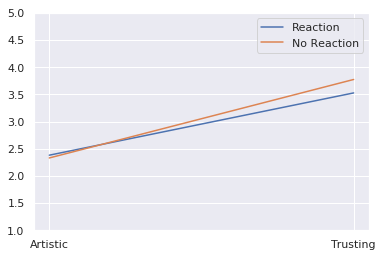

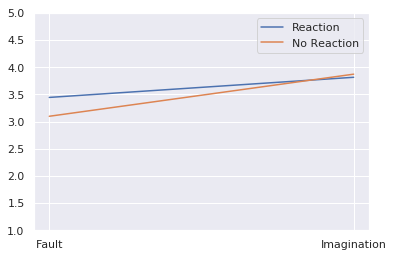

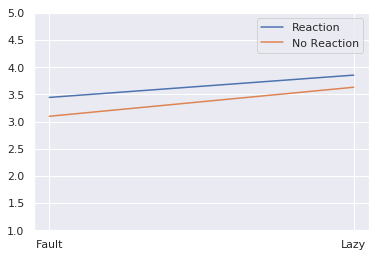

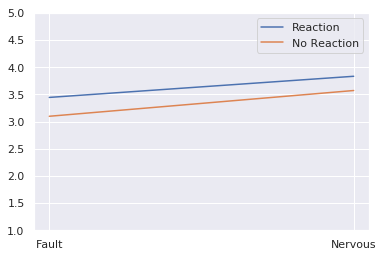

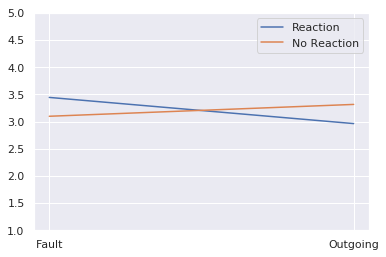

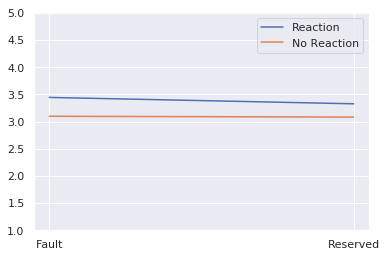

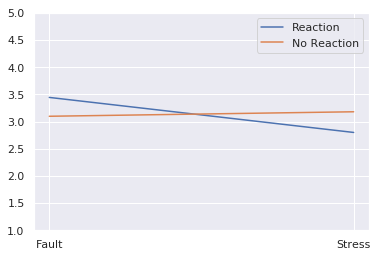

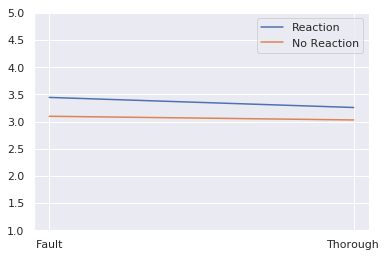

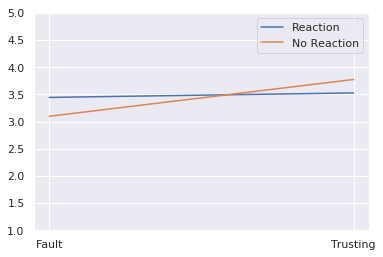

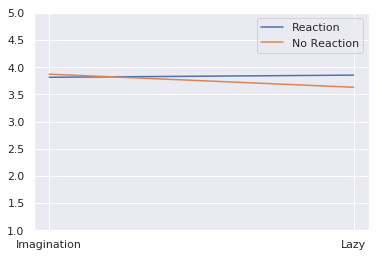

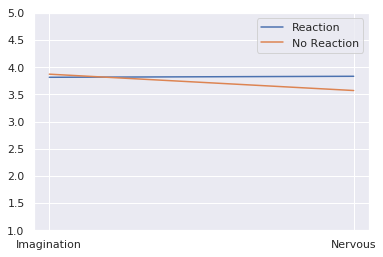

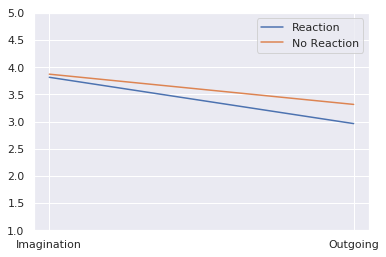

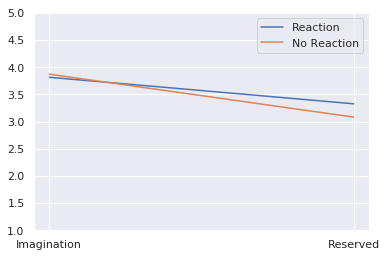

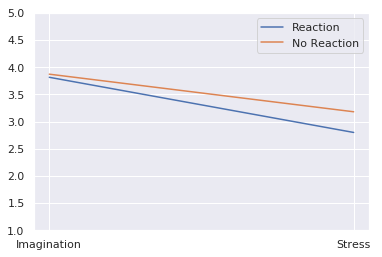

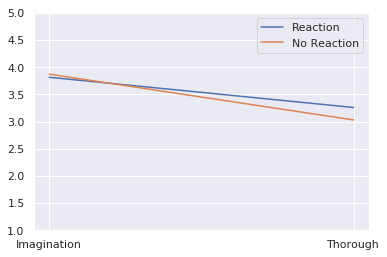

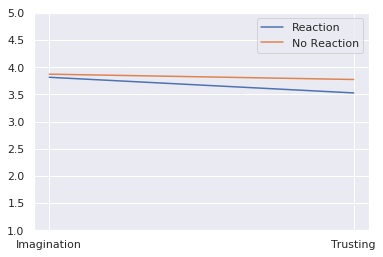

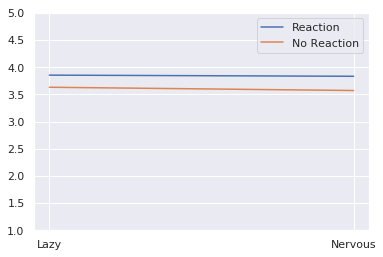

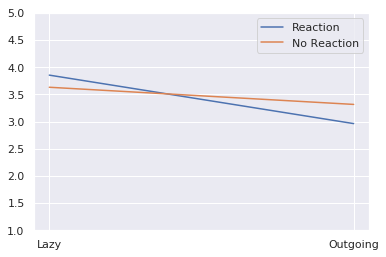

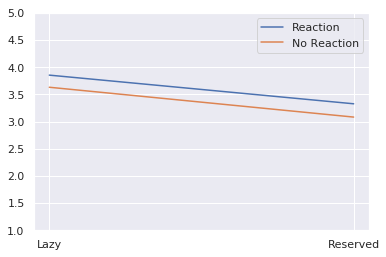

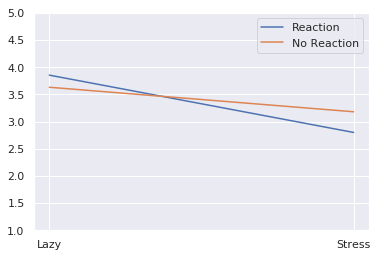

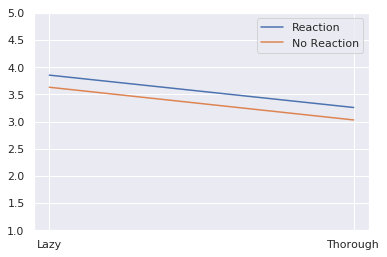

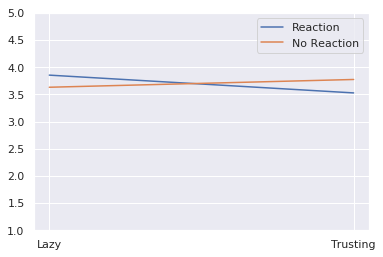

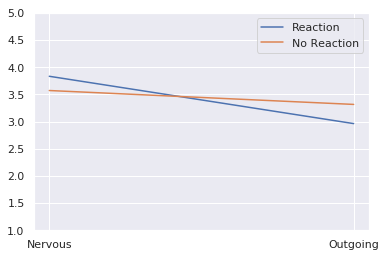

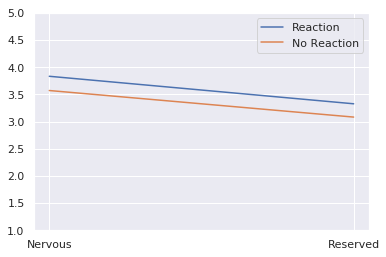

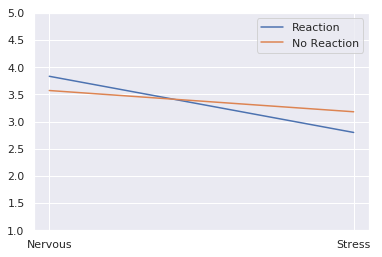

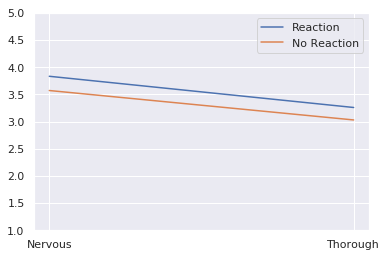

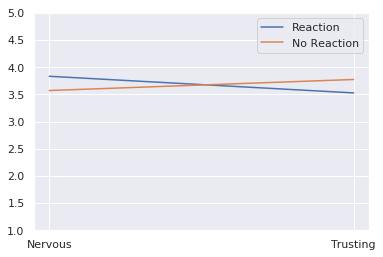

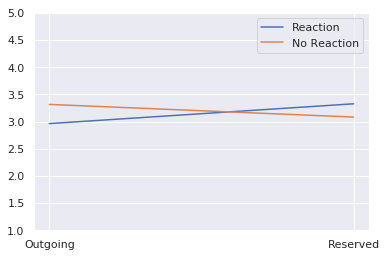

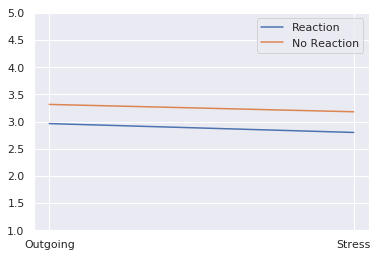

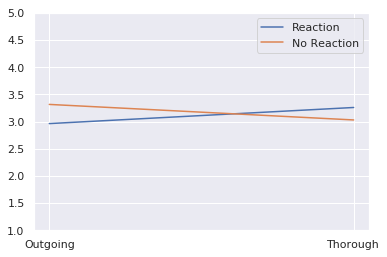

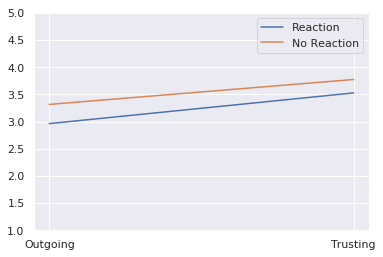

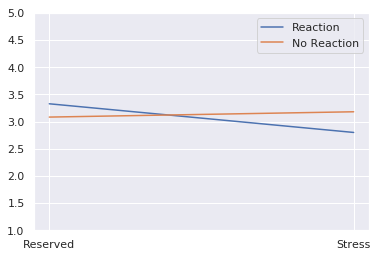

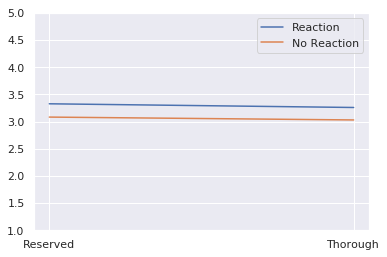

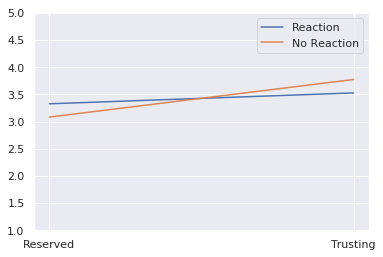

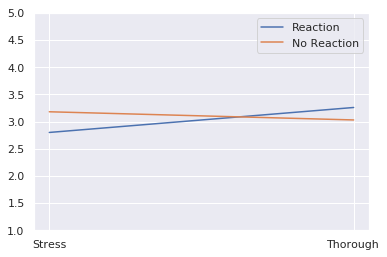

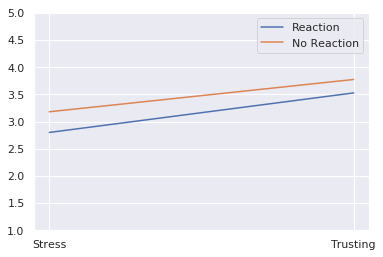

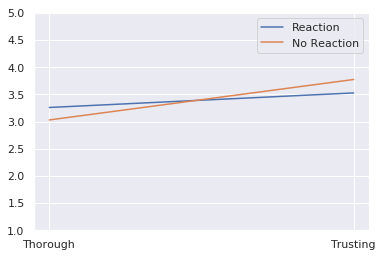

In [1099]:
import itertools

plot_vars = ['activity', 
             'engagement', 
             'familiarity', 
             'like_dislike', 
             'positivity', 
             'tension', 
             'age', 
             'musical_expertise', 
             'concentration', 
             'artistic', 
             'fault', 
             'imagination', 
             'lazy', 
             'nervous', 
             'outgoing', 
             'reserved', 
             'stress', 
             'thorough', 
             'trusting']

pairs = list(itertools.combinations(plot_vars, 2))

for pair in pairs:
    interaction_plot(pair[0], pair[1])